In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import seaborn as sns
from tensorflow.keras import layers, regularizers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

## Downloading Dataset

The [ShapeNet dataset](https://shapenet.org/) is an ongoing effort to establish a richly-annotated,
large-scale dataset of 3D shapes. **ShapeNetCore** is a subset of the full ShapeNet
dataset with clean single 3D models and manually verified category and alignment
annotations. It covers 55 common object categories, with about 51,300 unique 3D models.

For this example, we use one of the 12 object categories of
[PASCAL 3D+](http://cvgl.stanford.edu/projects/pascal3d.html),
included as part of the ShapenetCore dataset.

In [2]:
dataset_url = "https://git.io/JiY4i"
download_path="/kaggle/working/"
dataset_path = keras.utils.get_file(fname="shapenet.zip",origin=dataset_url,cache_subdir="datasets",hash_algorithm="auto",extract=True,
                                                                        archive_format="auto",
                                                                        cache_dir=download_path)

1078925405/1078925405 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


# Load Dataset

In [3]:
with open("/kaggle/working/datasets/PartAnnotation/metadata.json") as json_file:
    metadata = json.load(json_file)

print(metadata)

{'Airplane': {'directory': '02691156', 'lables': ['wing', 'body', 'tail', 'engine'], 'colors': ['blue', 'green', 'red', 'pink']}, 'Bag': {'directory': '02773838', 'lables': ['handle', 'body'], 'colors': ['blue', 'green']}, 'Cap': {'directory': '02954340', 'lables': ['panels', 'peak'], 'colors': ['blue', 'green']}, 'Car': {'directory': '02958343', 'lables': ['wheel', 'hood', 'roof'], 'colors': ['blue', 'green', 'red']}, 'Chair': {'directory': '03001627', 'lables': ['leg', 'arm', 'back', 'seat'], 'colors': ['blue', 'green', 'red', 'pink']}, 'Earphone': {'directory': '03261776', 'lables': ['earphone', 'headband'], 'colors': ['blue', 'green']}, 'Guitar': {'directory': '03467517', 'lables': ['head', 'body', 'neck'], 'colors': ['blue', 'green', 'red']}, 'Knife': {'directory': '03624134', 'lables': ['handle', 'blade'], 'colors': ['blue', 'green']}, 'Lamp': {'directory': '03636649', 'lables': ['canopy', 'lampshade', 'base'], 'colors': ['blue', 'green', 'red']}, 'Laptop': {'directory': '0364280

# Label Name

In [4]:
for class_name in metadata:
    print(class_name)

Airplane
Bag
Cap
Car
Chair
Earphone
Guitar
Knife
Lamp
Laptop
Motorbike
Mug
Pistol
Rocket
Skateboard
Table


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


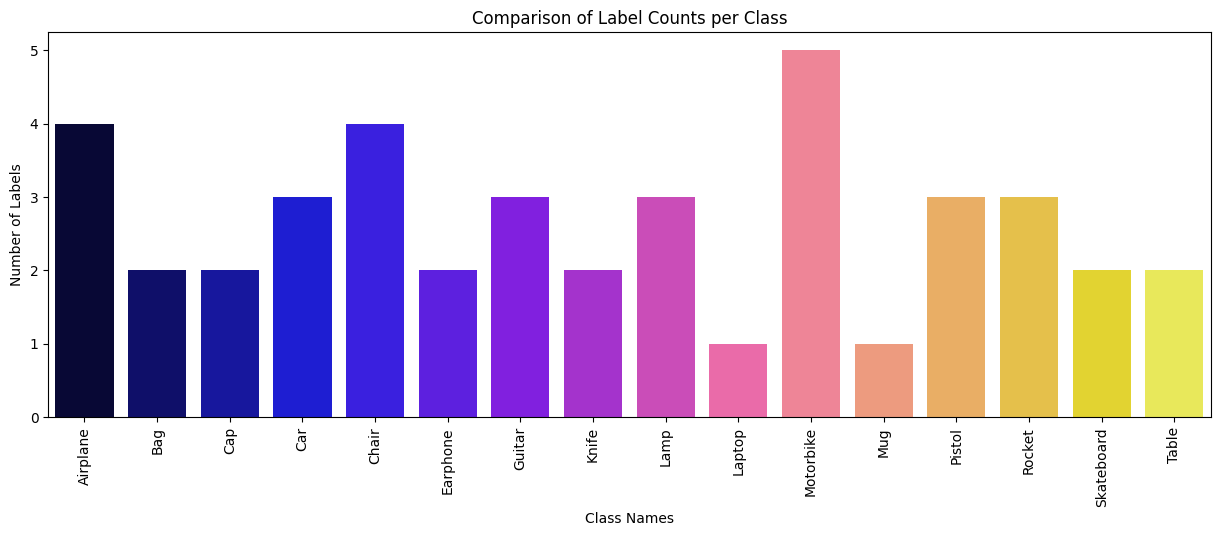

In [5]:

base_path = "/kaggle/working/datasets/PartAnnotation"

if not os.path.exists(base_path):
    raise FileNotFoundError(f"Directory {base_path} not found.")
    
class_names = list(metadata.keys())
class_lengths = [len(info['lables']) for info in metadata.values()]
plt.figure(figsize=(15,5))
sns.barplot(x=class_names, y=class_lengths,palette="gnuplot2")
plt.xticks(rotation=90)
plt.xlabel('Class Names')
plt.ylabel('Number of Labels')
plt.title('Comparison of Label Counts per Class')
plt.show()

In [6]:
points_dir = "/kaggle/working/datasets/PartAnnotation/03790512/points/"
labels_dir = "/kaggle/working/datasets/PartAnnotation/03790512/points_label/"

LABELS = metadata["Motorbike"]["lables"]
COLORS = metadata["Motorbike"]["colors"]

In [7]:
import os
missing_labels = {}

# Loop through each label in LABELS
for label in LABELS:
    label_folder = os.path.join(labels_dir, label)
    
    if not os.path.exists(label_folder):
        missing_labels[label] = "Label folder does not exist"
    else:
        # Check if any label files exist in the folder
        label_files = os.listdir(label_folder)
        if len(label_files) == 0:
            missing_labels[label] = "No files found for this label"
        else:
            missing_labels[label] = "Exists"

# Print the result
if missing_labels:
    print("Missing or incomplete labels:")
    for label, status in missing_labels.items():
        print(f"Label '{label}': {status}")
else:
    print("All labels are present and correctly configured.")


Missing or incomplete labels:
Label 'wheel': Exists
Label 'handle': Exists
Label 'gas_tank': Exists
Label 'light': Exists
Label 'seat': Exists


## Structuring the dataset

We generate the following in-memory data structures from the Airplane point clouds and
their labels:

- `point_clouds` is a list of `np.array` objects that represent the point cloud data in
the form of x, y and z coordinates. Axis 0 represents the number of points in the
point cloud, while axis 1 represents the coordinates. `all_labels` is the list
that represents the label of each coordinate as a string (needed mainly for
visualization purposes).
- `test_point_clouds` is in the same format as `point_clouds`, but doesn't have
corresponding the labels of the point clouds.
- `all_labels` is a list of `np.array` objects that represent the point cloud labels
for each coordinate, corresponding to the `point_clouds` list.
- `point_cloud_labels` is a list of `np.array` objects that represent the point cloud
labels for each coordinate in one-hot encoded form, corresponding to the `point_clouds`
list.

In [8]:
NUM_SAMPLE_POINTS = 1024
point_clouds, test_point_clouds = [], []
point_cloud_labels, all_labels = [], []
points_files = glob(os.path.join(points_dir, "*.pts"))

for point_file in tqdm(points_files):
    point_cloud = np.loadtxt(point_file)
    if point_cloud.shape[0] < NUM_SAMPLE_POINTS:
        continue
        
    file_id = point_file.split("/")[-1].split(".")[0]
    label_data, num_labels = {}, 0
    
    for label in LABELS:
        label_file = os.path.join(labels_dir, label, file_id + ".seg")
        if os.path.exists(label_file):
            label_data[label] = np.loadtxt(label_file).astype("float32")
            num_labels = len(label_data[label])
    
    try:
        label_map = ["none"] * num_labels
        for label in LABELS:
            for i, data in enumerate(label_data[label]):
                label_map[i] = label if data == 1 else label_map[i]
        
        dense_labels = [LABELS.index(label) if label != "none" else len(LABELS) for label in label_map]
        one_hot_labels = keras.utils.to_categorical(dense_labels, num_classes=len(LABELS) + 1)
        
        # Sample the point cloud and corresponding labels with the same indices
        indices = np.random.choice(point_cloud.shape[0], NUM_SAMPLE_POINTS, replace=False)
        sampled_point_cloud = point_cloud[indices]
        sampled_labels = one_hot_labels[indices]
        sampled_label_map = [label_map[i] for i in indices]
        
        point_clouds.append(sampled_point_cloud)
        point_cloud_labels.append(sampled_labels)
        all_labels.append(sampled_label_map)
    except KeyError:
        # For test point clouds, still sample to consistent size
        indices = np.random.choice(point_cloud.shape[0], NUM_SAMPLE_POINTS, replace=False)
        test_point_clouds.append(point_cloud[indices])

100%|██████████| 337/337 [00:10<00:00, 33.06it/s]


In [9]:
if not points_files:
    print("Warning: No point cloud files found!")

# At the end of processing
print(f"Processed {len(point_clouds)} training and {len(test_point_clouds)} test point clouds")
print(f"Skipped {len(points_files) - len(point_clouds) - len(test_point_clouds)} point clouds")

Processed 234 training and 103 test point clouds
Skipped 0 point clouds


In [10]:
print(len(point_clouds), len(all_labels))


234 234


## Next, we take a look at some samples from the in-memory arrays we just generated:

In [11]:
for _ in range(5):
    i = random.randint(0, len(point_clouds) - 1)
    print(f"point_clouds[{i}].shape:", point_clouds[i].shape)
    print(f"point_cloud_labels[{i}].shape:", point_cloud_labels[i].shape)
    for j in range(5):
        print(f"all_labels[{i}][{j}]:", all_labels[i][j], f"\tpoint_cloud_labels[{i}][{j}]:", point_cloud_labels[i][j], "\n")

point_clouds[118].shape: (1024, 3)
point_cloud_labels[118].shape: (1024, 6)
all_labels[118][0]: wheel 	point_cloud_labels[118][0]: [1. 0. 0. 0. 0. 0.] 

all_labels[118][1]: none 	point_cloud_labels[118][1]: [0. 0. 0. 0. 0. 1.] 

all_labels[118][2]: none 	point_cloud_labels[118][2]: [0. 0. 0. 0. 0. 1.] 

all_labels[118][3]: gas_tank 	point_cloud_labels[118][3]: [0. 0. 1. 0. 0. 0.] 

all_labels[118][4]: none 	point_cloud_labels[118][4]: [0. 0. 0. 0. 0. 1.] 

point_clouds[66].shape: (1024, 3)
point_cloud_labels[66].shape: (1024, 6)
all_labels[66][0]: none 	point_cloud_labels[66][0]: [0. 0. 0. 0. 0. 1.] 

all_labels[66][1]: handle 	point_cloud_labels[66][1]: [0. 1. 0. 0. 0. 0.] 

all_labels[66][2]: none 	point_cloud_labels[66][2]: [0. 0. 0. 0. 0. 1.] 

all_labels[66][3]: wheel 	point_cloud_labels[66][3]: [1. 0. 0. 0. 0. 0.] 

all_labels[66][4]: none 	point_cloud_labels[66][4]: [0. 0. 0. 0. 0. 1.] 

point_clouds[97].shape: (1024, 3)
point_cloud_labels[97].shape: (1024, 6)
all_labels[97][0]:

# Now, let's visualize some of the point clouds along with their labels.

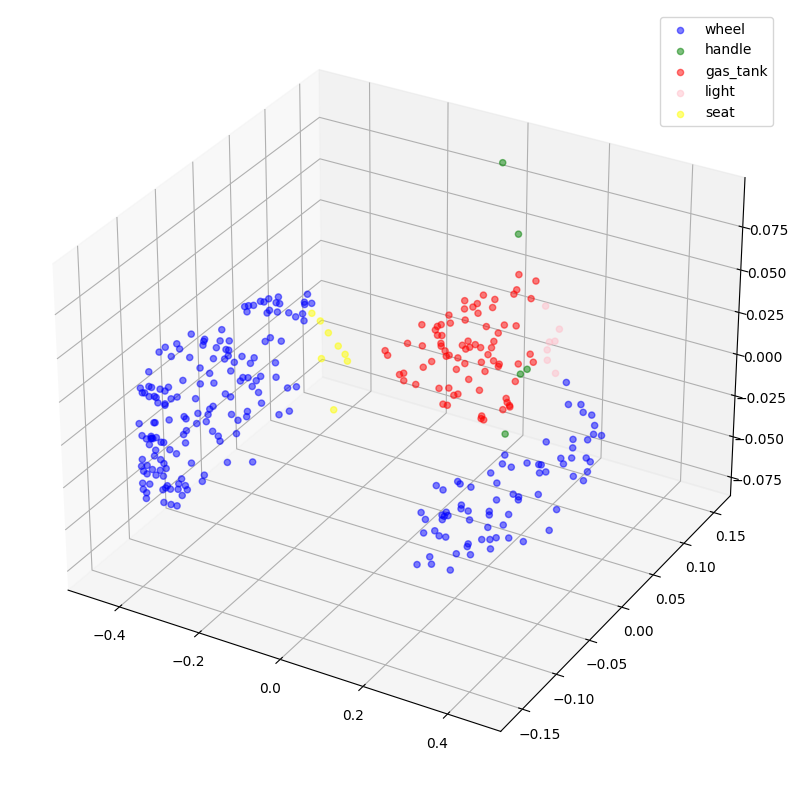

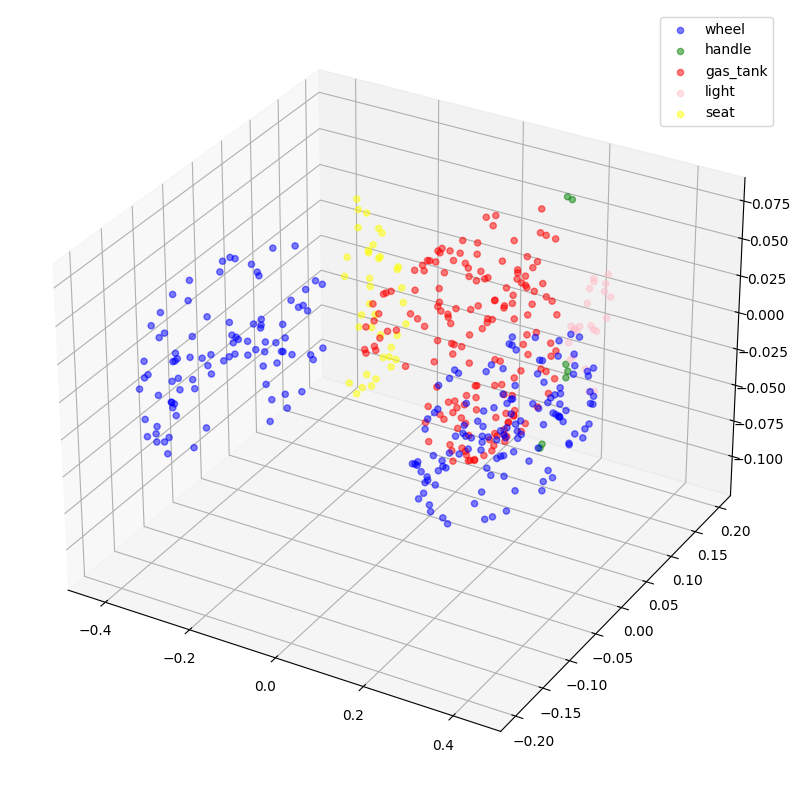

In [12]:
def visualize_data(point_cloud, labels):
    df = pd.DataFrame(data={"x": point_cloud[:, 0],"y": point_cloud[:, 1],"z": point_cloud[:, 2],"label": labels})
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")
    for index, label in enumerate(LABELS):
        c_df = df[df["label"] == label]
        try:
            ax.scatter(c_df["x"], c_df["y"], c_df["z"], label=label, alpha=0.5, c=COLORS[index])
        except IndexError:
            pass
    ax.legend()
    plt.show()


visualize_data(point_clouds[0], all_labels[0])
visualize_data(point_clouds[200], all_labels[200])

In [13]:
points_dir = "/kaggle/working/datasets/PartAnnotation/02691156/points"
labels_dir = "/kaggle/working/datasets/PartAnnotation/02691156/points_label"

LABELS = metadata["Airplane"]["lables"]
COLORS = metadata["Airplane"]["colors"]

In [14]:
import os
missing_labels = {}

# Loop through each label in LABELS
for label in LABELS:
    label_folder = os.path.join(labels_dir, label)
    
    if not os.path.exists(label_folder):
        missing_labels[label] = "Label folder does not exist"
    else:
        # Check if any label files exist in the folder
        label_files = os.listdir(label_folder)
        if len(label_files) == 0:
            missing_labels[label] = "No files found for this label"
        else:
            missing_labels[label] = "Exists"

# Print the result
if missing_labels:
    print("Missing or incomplete labels:")
    for label, status in missing_labels.items():
        print(f"Label '{label}': {status}")
else:
    print("All labels are present and correctly configured.")

Missing or incomplete labels:
Label 'wing': Exists
Label 'body': Exists
Label 'tail': Exists
Label 'engine': Exists


In [15]:
NUM_SAMPLE_POINTS = 1024
point_clouds, test_point_clouds = [], []
point_cloud_labels, all_labels = [], []
points_files = glob(os.path.join(points_dir, "*.pts"))

for point_file in tqdm(points_files):
    point_cloud = np.loadtxt(point_file)
    if point_cloud.shape[0] < NUM_SAMPLE_POINTS:
        continue
        
    file_id = point_file.split("/")[-1].split(".")[0]
    label_data, num_labels = {}, 0
    
    for label in LABELS:
        label_file = os.path.join(labels_dir, label, file_id + ".seg")
        if os.path.exists(label_file):
            label_data[label] = np.loadtxt(label_file).astype("float32")
            num_labels = len(label_data[label])
    
    try:
        label_map = ["none"] * num_labels
        for label in LABELS:
            for i, data in enumerate(label_data[label]):
                label_map[i] = label if data == 1 else label_map[i]
        
        dense_labels = [LABELS.index(label) if label != "none" else len(LABELS) for label in label_map]
        one_hot_labels = keras.utils.to_categorical(dense_labels, num_classes=len(LABELS) + 1)
        
        # Sample the point cloud and corresponding labels with the same indices
        indices = np.random.choice(point_cloud.shape[0], NUM_SAMPLE_POINTS, replace=False)
        sampled_point_cloud = point_cloud[indices]
        sampled_labels = one_hot_labels[indices]
        sampled_label_map = [label_map[i] for i in indices]
        
        point_clouds.append(sampled_point_cloud)
        point_cloud_labels.append(sampled_labels)
        all_labels.append(sampled_label_map)
    except KeyError:
        # For test point clouds, still sample to consistent size
        indices = np.random.choice(point_cloud.shape[0], NUM_SAMPLE_POINTS, replace=False)
        test_point_clouds.append(point_cloud[indices])

100%|██████████| 4045/4045 [01:49<00:00, 36.94it/s]


In [16]:
if not points_files:
    print("Warning: No point cloud files found!")

# At the end of processing
print(f"Processed {len(point_clouds)} training and {len(test_point_clouds)} test point clouds")
print(f"Skipped {len(points_files) - len(point_clouds) - len(test_point_clouds)} point clouds")

Processed 3694 training and 351 test point clouds
Skipped 0 point clouds


In [17]:
print(len(point_clouds), len(all_labels))

3694 3694


In [18]:
for _ in range(5):
    i = random.randint(0, len(point_clouds) - 1)
    print(f"point_clouds[{i}].shape:", point_clouds[i].shape)
    print(f"point_cloud_labels[{i}].shape:", point_cloud_labels[i].shape)
    for j in range(5):
        print(f"all_labels[{i}][{j}]:", all_labels[i][j], f"\tpoint_cloud_labels[{i}][{j}]:", point_cloud_labels[i][j], "\n")

point_clouds[2098].shape: (1024, 3)
point_cloud_labels[2098].shape: (1024, 5)
all_labels[2098][0]: body 	point_cloud_labels[2098][0]: [0. 1. 0. 0. 0.] 

all_labels[2098][1]: wing 	point_cloud_labels[2098][1]: [1. 0. 0. 0. 0.] 

all_labels[2098][2]: tail 	point_cloud_labels[2098][2]: [0. 0. 1. 0. 0.] 

all_labels[2098][3]: wing 	point_cloud_labels[2098][3]: [1. 0. 0. 0. 0.] 

all_labels[2098][4]: engine 	point_cloud_labels[2098][4]: [0. 0. 0. 1. 0.] 

point_clouds[2849].shape: (1024, 3)
point_cloud_labels[2849].shape: (1024, 5)
all_labels[2849][0]: wing 	point_cloud_labels[2849][0]: [1. 0. 0. 0. 0.] 

all_labels[2849][1]: wing 	point_cloud_labels[2849][1]: [1. 0. 0. 0. 0.] 

all_labels[2849][2]: body 	point_cloud_labels[2849][2]: [0. 1. 0. 0. 0.] 

all_labels[2849][3]: wing 	point_cloud_labels[2849][3]: [1. 0. 0. 0. 0.] 

all_labels[2849][4]: wing 	point_cloud_labels[2849][4]: [1. 0. 0. 0. 0.] 

point_clouds[2673].shape: (1024, 3)
point_cloud_labels[2673].shape: (1024, 5)
all_labels[267

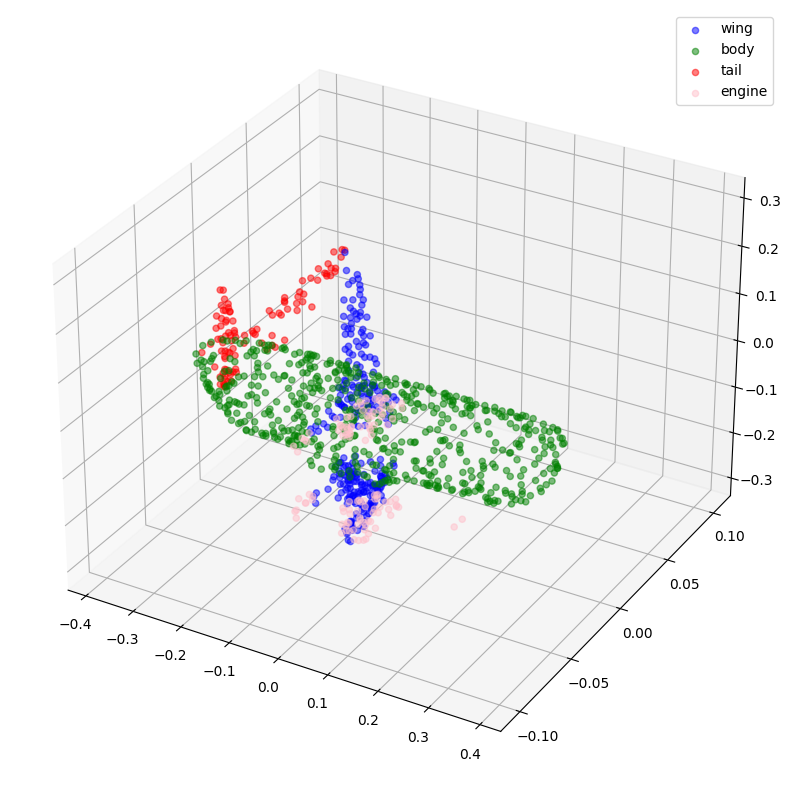

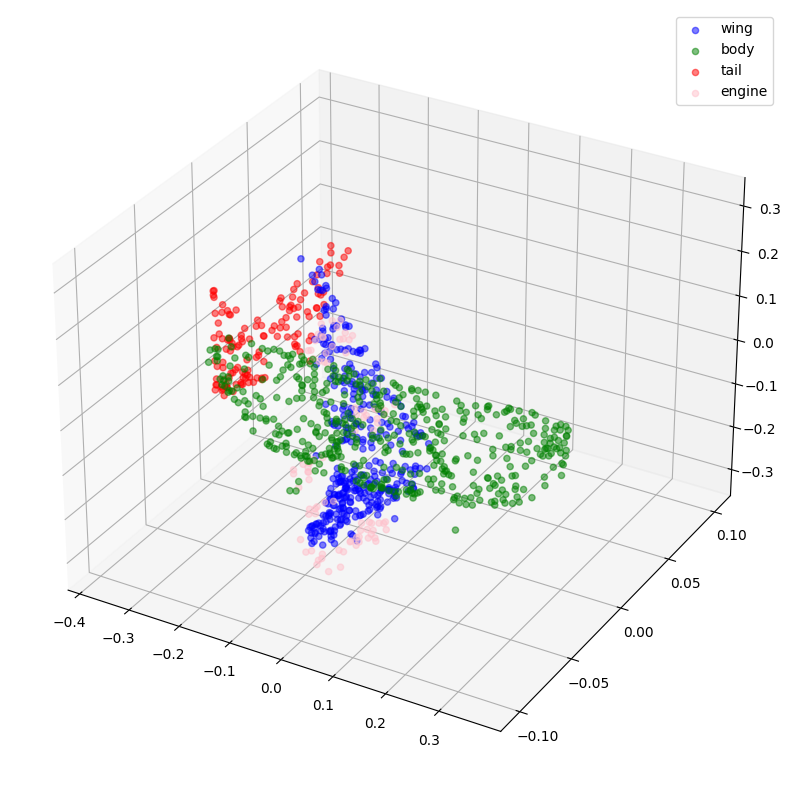

In [19]:
def visualize_data(point_cloud, labels):
    df = pd.DataFrame(data={"x": point_cloud[:, 0],"y": point_cloud[:, 1],"z": point_cloud[:, 2],"label": labels})
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")
    for index, label in enumerate(LABELS):
        c_df = df[df["label"] == label]
        try:
            ax.scatter(c_df["x"], c_df["y"], c_df["z"], label=label, alpha=0.5, c=COLORS[index])
        except IndexError:
            pass
    ax.legend()
    plt.show()


visualize_data(point_clouds[0], all_labels[0])
visualize_data(point_clouds[300], all_labels[300])

# Preprocessing

* Note that all the point clouds that we have loaded consist of a variable number of points,
which makes it difficult for us to batch them together. In order to overcome this problem, we
randomly sample a fixed number of points from each point cloud. We also normalize the
point clouds in order to make the data scale-invariant.

In [20]:
for index in tqdm(range(len(point_clouds))):
    current_point_cloud = point_clouds[index]
    current_label_cloud = point_cloud_labels[index]
    current_labels = all_labels[index]
    num_points = len(current_point_cloud)
    # Randomly sampling respective indices.
    sampled_indices = random.sample(list(range(num_points)), NUM_SAMPLE_POINTS)
    # Sampling points corresponding to sampled indices.
    sampled_point_cloud = np.array([current_point_cloud[i] for i in sampled_indices])
    # Sampling corresponding one-hot encoded labels.
    sampled_label_cloud = np.array([current_label_cloud[i] for i in sampled_indices])
    # Sampling corresponding labels for visualization.
    sampled_labels = np.array([current_labels[i] for i in sampled_indices])
    # Normalizing sampled point cloud.
    norm_point_cloud = sampled_point_cloud - np.mean(sampled_point_cloud, axis=0)
    norm_point_cloud /= np.max(np.linalg.norm(norm_point_cloud, axis=1))
    point_clouds[index] = norm_point_cloud
    point_cloud_labels[index] = sampled_label_cloud
    all_labels[index] = sampled_labels

100%|██████████| 3694/3694 [00:08<00:00, 451.97it/s]


# Let's visualize the sampled and normalized point clouds along with their corresponding labels.

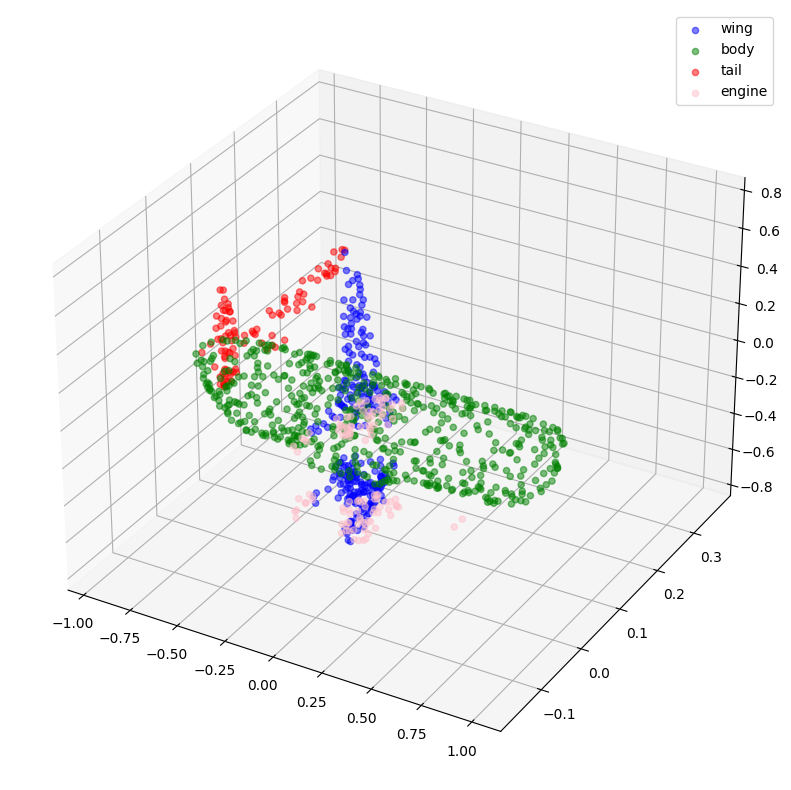

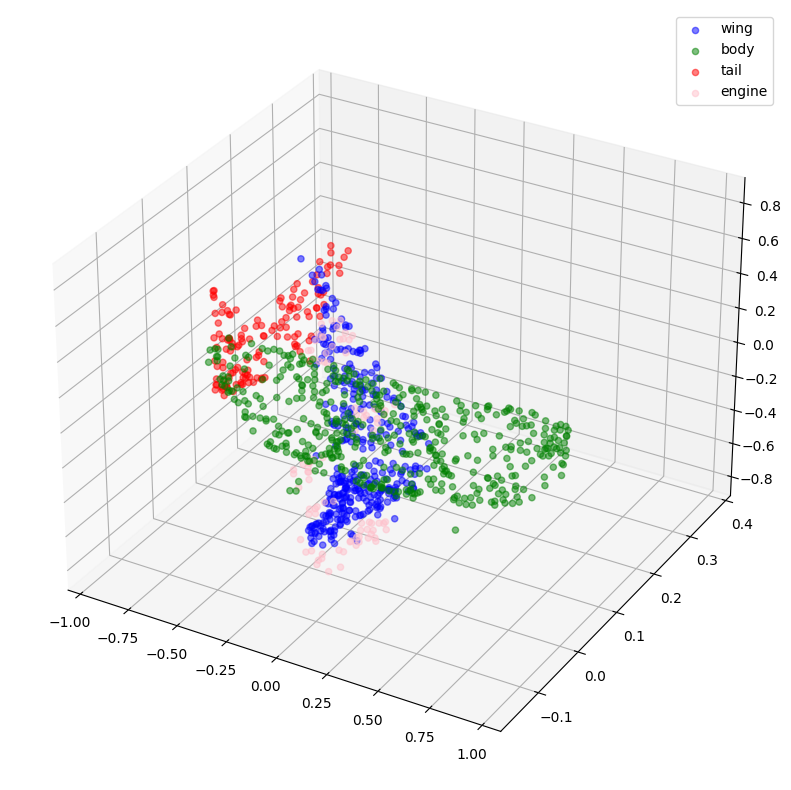

In [21]:
visualize_data(point_clouds[0], all_labels[0])
visualize_data(point_clouds[300], all_labels[300])

In [22]:
import os
import glob
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import keras

# Constants
NUM_SAMPLE_POINTS = 1024
VAL_SPLIT = 0.2
BATCH_SIZE = 16

# Determine the maximum number of labels across all categories
MAX_LABELS = max(len(info["lables"]) for info in metadata.values()) + 1  # +1 for "none"

# Base directory for the dataset
base_dir = "/kaggle/working/datasets/PartAnnotation/"

# Initialize lists
point_clouds, test_point_clouds = [], []
point_cloud_labels, all_labels = [], []

# Process point clouds and labels
for category, info in metadata.items():
    points_dir = os.path.join(base_dir, info["directory"], "points")
    labels_dir = os.path.join(base_dir, info["directory"], "points_label")
    LABELS = info["lables"]
    points_files = glob.glob(os.path.join(points_dir, "*.pts"))
    
    for point_file in tqdm(points_files, desc=f"Processing point clouds in {category}"):
        point_cloud = np.loadtxt(point_file)
        if point_cloud.shape[0] < NUM_SAMPLE_POINTS:
            tqdm.write(f"Skipping {point_file}: Too few points ({point_cloud.shape[0]} < {NUM_SAMPLE_POINTS})")
            continue
            
        file_id = os.path.basename(point_file).split(".")[0]
        label_data = {}
        num_points = point_cloud.shape[0]
        
        labels_loaded = False
        for label in LABELS:
            label_file = os.path.join(labels_dir, label, file_id + ".seg")
            if os.path.exists(label_file):
                label_values = np.loadtxt(label_file).astype("float32")
                if len(label_values) == num_points:
                    label_data[label] = label_values
                    labels_loaded = True
                else:
                    tqdm.write(f"Warning: Label file {label_file} has {len(label_values)} points, but point cloud has {num_points}")
            else:
                tqdm.write(f"Warning: Label file {label_file} does not exist")
        
        if not labels_loaded:
            tqdm.write(f"No valid labels for {point_file}, adding to test_point_clouds")
            indices = np.random.choice(num_points, NUM_SAMPLE_POINTS, replace=False)
            test_point_clouds.append(point_cloud[indices])
            continue
        
        label_map = ["none"] * num_points
        for label in LABELS:
            if label in label_data:
                for i, data in enumerate(label_data[label]):
                    label_map[i] = label if data == 1 else label_map[i]
        
        dense_labels = [LABELS.index(label) if label != "none" else len(LABELS) for label in label_map]
        one_hot_labels = keras.utils.to_categorical(dense_labels, num_classes=len(LABELS) + 1)
        
        if one_hot_labels.shape[1] < MAX_LABELS:
            padding = np.zeros((one_hot_labels.shape[0], MAX_LABELS - one_hot_labels.shape[1]))
            one_hot_labels = np.concatenate([one_hot_labels, padding], axis=1)
        
        if one_hot_labels.shape[0] != num_points:
            tqdm.write(f"Error: one_hot_labels size ({one_hot_labels.shape[0]}) does not match point cloud size ({num_points}) for {point_file}")
            continue
        
        indices = np.random.choice(num_points, NUM_SAMPLE_POINTS, replace=False)
        sampled_point_cloud = point_cloud[indices]
        sampled_labels = one_hot_labels[indices]
        sampled_label_map = [label_map[i] for i in indices]
        
        point_clouds.append(sampled_point_cloud)
        point_cloud_labels.append(sampled_labels)
        all_labels.append(sampled_label_map)

# Convert to numpy arrays
point_clouds = np.array(point_clouds)
point_cloud_labels = np.array(point_cloud_labels)
test_point_clouds = np.array(test_point_clouds)

tqdm.write(f"Processed {len(point_clouds)} training point clouds and {len(test_point_clouds)} test point clouds.")
tqdm.write(f"point_clouds shape: {point_clouds.shape}")
tqdm.write(f"point_cloud_labels shape: {point_cloud_labels.shape}")
tqdm.write(f"test_point_clouds shape: {test_point_clouds.shape}")


Processing point clouds in Airplane:   1%|          | 24/4045 [00:00<01:51, 36.22it/s]

Processing point clouds in Airplane:   1%|          | 32/4045 [00:00<01:50, 36.47it/s]

Processing point clouds in Airplane:   1%|          | 44/4045 [00:01<01:52, 35.44it/s]

Processing point clouds in Airplane:   2%|▏         | 68/4045 [00:01<01:52, 35.24it/s]

Processing point clouds in Airplane:   2%|▏         | 84/4045 [00:02<01:50, 35.71it/s]

Processing point clouds in Airplane:   3%|▎         | 104/4045 [00:02<01:51, 35.31it/s]

Processing point clouds in Airplane:   3%|▎         | 132/4045 [00:03<01:53, 34.61it/s]

Processing point clouds in Airplane:   4%|▍         | 152/4045 [00:04<01:48, 35.94it/s]

Processing point clouds in Airplane:   4%|▍         | 160/4045 [00:04<01:47, 36.18it/s]

Processing point clouds in Airplane:   4%|▍         | 168/4045 [00:04<01:49, 35.56it/s]

Processing point clouds in Airplane:   4%|▍         | 180/4045 [00:05<01:47, 36.00it/s]

Processing point clouds in Airplane:   5%|▍         | 200/4045 [00:05<01:46, 35.94it/s]

Processing point clouds in Airplane:   5%|▌         | 216/4045 [00:06<01:46, 36.04it/s]

Processing point clouds in Airplane:   6%|▌         | 252/4045 [00:07<01:45, 36.06it/s]

Processing point clouds in Airplane:   6%|▋         | 260/4045 [00:07<01:45, 35.98it/s]

Processing point clouds in Airplane:   7%|▋         | 268/4045 [00:07<01:46, 35.61it/s]

Processing point clouds in Airplane:   8%|▊         | 304/4045 [00:08<01:46, 35.02it/s]

Processing point clouds in Airplane:   8%|▊         | 312/4045 [00:08<01:46, 35.20it/s]

Processing point clouds in Airplane:   8%|▊         | 324/4045 [00:09<01:43, 35.93it/s]

Processing point clouds in Airplane:   8%|▊         | 332/4045 [00:09<01:45, 35.22it/s]

Processing point clouds in Airplane:   8%|▊         | 340/4045 [00:09<01:46, 34.84it/s]

Processing point clouds in Airplane:   9%|▉         | 356/4045 [00:10<01:46, 34.53it/s]

Processing point clouds in Airplane:  10%|▉         | 392/4045 [00:11<01:42, 35.77it/s]

Processing point clouds in Airplane:  10%|█         | 424/4045 [00:12<01:41, 35.74it/s]

Processing point clouds in Airplane:  11%|█▏        | 464/4045 [00:13<01:40, 35.48it/s]

Processing point clouds in Airplane:  12%|█▏        | 492/4045 [00:13<01:41, 34.94it/s]

Processing point clouds in Airplane:  12%|█▏        | 500/4045 [00:14<01:38, 35.90it/s]

Processing point clouds in Airplane:  13%|█▎        | 536/4045 [00:15<01:39, 35.26it/s]

Processing point clouds in Airplane:  13%|█▎        | 544/4045 [00:15<01:40, 34.80it/s]

Processing point clouds in Airplane:  14%|█▎        | 552/4045 [00:15<01:40, 34.59it/s]

Processing point clouds in Airplane:  14%|█▍        | 576/4045 [00:16<01:38, 35.38it/s]

Processing point clouds in Airplane:  15%|█▍        | 596/4045 [00:16<01:38, 35.13it/s]

Processing point clouds in Airplane:  15%|█▌        | 616/4045 [00:17<01:40, 34.09it/s]

Processing point clouds in Airplane:  15%|█▌        | 624/4045 [00:17<01:53, 30.24it/s]

Processing point clouds in Airplane:  16%|█▌        | 644/4045 [00:18<01:47, 31.63it/s]

Processing point clouds in Airplane:  16%|█▌        | 656/4045 [00:18<01:41, 33.32it/s]

Processing point clouds in Airplane:  17%|█▋        | 668/4045 [00:19<01:39, 33.84it/s]

Processing point clouds in Airplane:  17%|█▋        | 684/4045 [00:19<01:36, 34.85it/s]

Processing point clouds in Airplane:  17%|█▋        | 700/4045 [00:20<01:34, 35.33it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/02691156/points/4e3e46fa987d0892a185a70f269c2a41.pts, adding to test_point_clouds


Processing point clouds in Airplane:  18%|█▊        | 708/4045 [00:20<01:35, 34.89it/s]

Processing point clouds in Airplane:  18%|█▊        | 724/4045 [00:20<01:37, 34.23it/s]

Processing point clouds in Airplane:  19%|█▊        | 752/4045 [00:21<01:41, 32.48it/s]

Processing point clouds in Airplane:  19%|█▉        | 760/4045 [00:21<01:39, 33.06it/s]

Processing point clouds in Airplane:  20%|█▉        | 792/4045 [00:22<01:36, 33.86it/s]

Processing point clouds in Airplane:  20%|█▉        | 808/4045 [00:23<01:36, 33.41it/s]

Processing point clouds in Airplane:  20%|██        | 820/4045 [00:23<01:34, 34.05it/s]

Processing point clouds in Airplane:  21%|██        | 832/4045 [00:23<01:34, 33.99it/s]

Processing point clouds in Airplane:  21%|██        | 852/4045 [00:24<01:30, 35.33it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/02691156/points/bce1b10c92fb9fc81b7a4091d85f2e8d.pts, adding to test_point_clouds


Processing point clouds in Airplane:  21%|██▏       | 868/4045 [00:25<01:31, 34.88it/s]

Processing point clouds in Airplane:  22%|██▏       | 884/4045 [00:25<01:31, 34.55it/s]

Processing point clouds in Airplane:  23%|██▎       | 936/4045 [00:26<01:27, 35.49it/s]

Processing point clouds in Airplane:  23%|██▎       | 948/4045 [00:27<01:27, 35.22it/s]

Processing point clouds in Airplane:  24%|██▎       | 956/4045 [00:27<01:28, 34.88it/s]

Processing point clouds in Airplane:  24%|██▍       | 964/4045 [00:27<01:28, 34.79it/s]

Processing point clouds in Airplane:  24%|██▍       | 984/4045 [00:28<01:25, 35.95it/s]

Processing point clouds in Airplane:  25%|██▍       | 996/4045 [00:28<01:26, 35.09it/s]

Processing point clouds in Airplane:  25%|██▍       | 1004/4045 [00:29<01:26, 35.17it/s]

Processing point clouds in Airplane:  25%|██▌       | 1016/4045 [00:29<01:26, 34.99it/s]

Processing point clouds in Airplane:  26%|██▌       | 1048/4045 [00:30<01:28, 34.01it/s]

Processing point clouds in Airplane:  27%|██▋       | 1072/4045 [00:30<01:23, 35.48it/s]

Processing point clouds in Airplane:  27%|██▋       | 1104/4045 [00:31<01:23, 35.18it/s]

Processing point clouds in Airplane:  28%|██▊       | 1140/4045 [00:32<01:21, 35.57it/s]

Processing point clouds in Airplane:  29%|██▉       | 1168/4045 [00:33<01:22, 34.97it/s]

Processing point clouds in Airplane:  29%|██▉       | 1180/4045 [00:33<01:19, 35.91it/s]

Processing point clouds in Airplane:  30%|██▉       | 1196/4045 [00:34<01:18, 36.15it/s]

Processing point clouds in Airplane:  30%|██▉       | 1204/4045 [00:34<01:17, 36.48it/s]

Processing point clouds in Airplane:  30%|███       | 1224/4045 [00:35<01:18, 35.98it/s]

Processing point clouds in Airplane:  31%|███       | 1244/4045 [00:35<01:19, 35.28it/s]

Processing point clouds in Airplane:  31%|███▏      | 1272/4045 [00:36<01:17, 35.66it/s]

Processing point clouds in Airplane:  32%|███▏      | 1288/4045 [00:36<01:19, 34.65it/s]

Processing point clouds in Airplane:  32%|███▏      | 1296/4045 [00:37<01:19, 34.58it/s]

Processing point clouds in Airplane:  32%|███▏      | 1312/4045 [00:37<01:19, 34.17it/s]

Processing point clouds in Airplane:  33%|███▎      | 1324/4045 [00:38<01:20, 33.79it/s]

Processing point clouds in Airplane:  33%|███▎      | 1352/4045 [00:38<01:18, 34.21it/s]

Processing point clouds in Airplane:  34%|███▎      | 1360/4045 [00:39<01:16, 34.94it/s]

Processing point clouds in Airplane:  34%|███▍      | 1376/4045 [00:39<01:17, 34.35it/s]

Processing point clouds in Airplane:  36%|███▌      | 1452/4045 [00:41<01:17, 33.35it/s]

Processing point clouds in Airplane:  36%|███▌      | 1460/4045 [00:42<01:15, 34.04it/s]

Processing point clouds in Airplane:  37%|███▋      | 1480/4045 [00:42<01:15, 34.10it/s]

Processing point clouds in Airplane:  38%|███▊      | 1524/4045 [00:43<01:13, 34.16it/s]

Processing point clouds in Airplane:  38%|███▊      | 1536/4045 [00:44<01:13, 34.24it/s]

Processing point clouds in Airplane:  39%|███▉      | 1568/4045 [00:45<01:11, 34.64it/s]

Processing point clouds in Airplane:  39%|███▉      | 1580/4045 [00:45<01:10, 35.14it/s]

Processing point clouds in Airplane:  39%|███▉      | 1596/4045 [00:46<01:10, 34.93it/s]

Processing point clouds in Airplane:  40%|████      | 1624/4045 [00:46<01:09, 34.82it/s]

Processing point clouds in Airplane:  40%|████      | 1632/4045 [00:47<01:08, 35.00it/s]

Processing point clouds in Airplane:  41%|████      | 1640/4045 [00:47<01:10, 34.30it/s]

Processing point clouds in Airplane:  41%|████      | 1664/4045 [00:47<01:09, 34.02it/s]

Processing point clouds in Airplane:  42%|████▏     | 1696/4045 [00:48<01:07, 35.02it/s]

Processing point clouds in Airplane:  42%|████▏     | 1704/4045 [00:49<01:05, 35.79it/s]

Processing point clouds in Airplane:  43%|████▎     | 1720/4045 [00:49<01:13, 31.56it/s]

Processing point clouds in Airplane:  43%|████▎     | 1752/4045 [00:50<01:08, 33.35it/s]

Processing point clouds in Airplane:  44%|████▎     | 1768/4045 [00:51<01:06, 34.22it/s]

Processing point clouds in Airplane:  44%|████▍     | 1780/4045 [00:51<01:10, 32.27it/s]

Processing point clouds in Airplane:  44%|████▍     | 1788/4045 [00:51<01:07, 33.36it/s]

Processing point clouds in Airplane:  45%|████▍     | 1812/4045 [00:52<01:04, 34.47it/s]

Processing point clouds in Airplane:  45%|████▌     | 1832/4045 [00:53<01:03, 34.68it/s]

Processing point clouds in Airplane:  45%|████▌     | 1840/4045 [00:53<01:02, 35.00it/s]

Processing point clouds in Airplane:  46%|████▌     | 1852/4045 [00:53<01:03, 34.36it/s]

Processing point clouds in Airplane:  46%|████▌     | 1860/4045 [00:53<01:02, 34.72it/s]

Processing point clouds in Airplane:  47%|████▋     | 1904/4045 [00:55<01:02, 34.22it/s]

Processing point clouds in Airplane:  48%|████▊     | 1924/4045 [00:55<01:00, 35.11it/s]

Processing point clouds in Airplane:  48%|████▊     | 1940/4045 [00:56<01:01, 34.43it/s]

Processing point clouds in Airplane:  49%|████▊     | 1964/4045 [00:56<01:00, 34.41it/s]

Processing point clouds in Airplane:  49%|████▉     | 1980/4045 [00:57<00:58, 35.08it/s]

Processing point clouds in Airplane:  49%|████▉     | 1996/4045 [00:57<00:58, 35.23it/s]

Processing point clouds in Airplane:  50%|████▉     | 2008/4045 [00:58<00:56, 36.15it/s]

Processing point clouds in Airplane:  50%|█████     | 2028/4045 [00:58<00:57, 34.98it/s]

Processing point clouds in Airplane:  50%|█████     | 2036/4045 [00:58<00:55, 35.99it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/02691156/points/c6009ba1bf947303ca8607f540cc62ba.pts, adding to test_point_clouds


Processing point clouds in Airplane:  51%|█████     | 2048/4045 [00:59<00:56, 35.33it/s]

Processing point clouds in Airplane:  51%|█████     | 2064/4045 [00:59<00:55, 35.59it/s]

Processing point clouds in Airplane:  52%|█████▏    | 2112/4045 [01:01<00:54, 35.15it/s]

Processing point clouds in Airplane:  53%|█████▎    | 2152/4045 [01:02<00:55, 34.17it/s]

Processing point clouds in Airplane:  55%|█████▌    | 2240/4045 [01:04<00:51, 34.74it/s]

Processing point clouds in Airplane:  56%|█████▌    | 2248/4045 [01:05<00:52, 34.33it/s]

Processing point clouds in Airplane:  56%|█████▌    | 2260/4045 [01:05<00:50, 35.20it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/02691156/points/692797a818b4630f1aa3e317da5a1267.pts, adding to test_point_clouds


Processing point clouds in Airplane:  56%|█████▋    | 2280/4045 [01:05<00:50, 34.65it/s]

Processing point clouds in Airplane:  57%|█████▋    | 2300/4045 [01:06<00:49, 35.08it/s]

Processing point clouds in Airplane:  57%|█████▋    | 2312/4045 [01:06<00:49, 34.67it/s]

Processing point clouds in Airplane:  57%|█████▋    | 2320/4045 [01:07<00:50, 34.32it/s]

Processing point clouds in Airplane:  58%|█████▊    | 2336/4045 [01:07<00:49, 34.72it/s]

Processing point clouds in Airplane:  58%|█████▊    | 2348/4045 [01:07<00:49, 34.61it/s]

Processing point clouds in Airplane:  58%|█████▊    | 2360/4045 [01:08<00:48, 34.74it/s]

Processing point clouds in Airplane:  59%|█████▉    | 2380/4045 [01:08<00:47, 35.15it/s]

Processing point clouds in Airplane:  59%|█████▉    | 2404/4045 [01:09<00:47, 34.67it/s]

Processing point clouds in Airplane:  60%|█████▉    | 2420/4045 [01:09<00:47, 34.01it/s]

Processing point clouds in Airplane:  60%|██████    | 2440/4045 [01:10<00:45, 35.05it/s]

Processing point clouds in Airplane:  61%|██████    | 2448/4045 [01:10<00:44, 35.73it/s]

Processing point clouds in Airplane:  61%|██████    | 2456/4045 [01:11<00:45, 34.85it/s]

Processing point clouds in Airplane:  61%|██████    | 2472/4045 [01:11<00:48, 32.77it/s]

Processing point clouds in Airplane:  61%|██████▏   | 2484/4045 [01:11<00:45, 34.31it/s]

Processing point clouds in Airplane:  62%|██████▏   | 2496/4045 [01:12<00:44, 34.53it/s]

Processing point clouds in Airplane:  62%|██████▏   | 2504/4045 [01:12<00:44, 34.62it/s]

Processing point clouds in Airplane:  62%|██████▏   | 2516/4045 [01:12<00:43, 35.07it/s]

Processing point clouds in Airplane:  62%|██████▏   | 2524/4045 [01:13<00:43, 34.65it/s]

Processing point clouds in Airplane:  63%|██████▎   | 2548/4045 [01:13<00:42, 34.87it/s]

Processing point clouds in Airplane:  63%|██████▎   | 2560/4045 [01:14<00:43, 34.30it/s]

Processing point clouds in Airplane:  64%|██████▍   | 2584/4045 [01:14<00:41, 35.03it/s]

Processing point clouds in Airplane:  64%|██████▍   | 2600/4045 [01:15<00:41, 34.41it/s]

Processing point clouds in Airplane:  65%|██████▍   | 2620/4045 [01:15<00:41, 34.38it/s]

Processing point clouds in Airplane:  65%|██████▌   | 2632/4045 [01:16<00:41, 34.34it/s]

Processing point clouds in Airplane:  65%|██████▌   | 2644/4045 [01:16<00:39, 35.03it/s]

Processing point clouds in Airplane:  66%|██████▋   | 2680/4045 [01:17<00:39, 34.35it/s]

Processing point clouds in Airplane:  66%|██████▋   | 2688/4045 [01:17<00:39, 34.35it/s]

Processing point clouds in Airplane:  67%|██████▋   | 2704/4045 [01:18<00:40, 33.21it/s]

Processing point clouds in Airplane:  67%|██████▋   | 2712/4045 [01:18<00:39, 33.53it/s]

Processing point clouds in Airplane:  67%|██████▋   | 2724/4045 [01:18<00:39, 33.72it/s]

Processing point clouds in Airplane:  68%|██████▊   | 2744/4045 [01:19<00:37, 35.09it/s]

Processing point clouds in Airplane:  68%|██████▊   | 2768/4045 [01:20<00:37, 34.28it/s]

Processing point clouds in Airplane:  69%|██████▊   | 2776/4045 [01:20<00:36, 34.68it/s]

Processing point clouds in Airplane:  69%|██████▉   | 2808/4045 [01:21<00:46, 26.88it/s]

Processing point clouds in Airplane:  70%|██████▉   | 2820/4045 [01:21<00:39, 31.07it/s]

Processing point clouds in Airplane:  70%|██████▉   | 2828/4045 [01:22<00:36, 32.89it/s]

Processing point clouds in Airplane:  70%|███████   | 2840/4045 [01:22<00:36, 33.32it/s]

Processing point clouds in Airplane:  71%|███████   | 2872/4045 [01:23<00:34, 34.37it/s]

Processing point clouds in Airplane:  71%|███████▏  | 2892/4045 [01:23<00:33, 33.97it/s]

Processing point clouds in Airplane:  72%|███████▏  | 2904/4045 [01:24<00:32, 34.80it/s]

Processing point clouds in Airplane:  72%|███████▏  | 2920/4045 [01:24<00:32, 34.95it/s]

Processing point clouds in Airplane:  73%|███████▎  | 2968/4045 [01:26<00:30, 35.13it/s]

Processing point clouds in Airplane:  74%|███████▍  | 2984/4045 [01:26<00:29, 35.62it/s]

Processing point clouds in Airplane:  75%|███████▍  | 3020/4045 [01:27<00:29, 34.84it/s]

Processing point clouds in Airplane:  75%|███████▍  | 3028/4045 [01:27<00:29, 34.80it/s]

Processing point clouds in Airplane:  75%|███████▌  | 3044/4045 [01:28<00:28, 34.79it/s]

Processing point clouds in Airplane:  76%|███████▌  | 3060/4045 [01:28<00:27, 35.35it/s]

Processing point clouds in Airplane:  76%|███████▌  | 3084/4045 [01:29<00:27, 34.74it/s]

Processing point clouds in Airplane:  77%|███████▋  | 3096/4045 [01:29<00:27, 34.22it/s]

Processing point clouds in Airplane:  77%|███████▋  | 3124/4045 [01:30<00:26, 34.64it/s]

Processing point clouds in Airplane:  77%|███████▋  | 3132/4045 [01:30<00:25, 35.25it/s]

Processing point clouds in Airplane:  78%|███████▊  | 3144/4045 [01:31<00:26, 33.94it/s]

Processing point clouds in Airplane:  78%|███████▊  | 3156/4045 [01:31<00:26, 33.35it/s]

Processing point clouds in Airplane:  79%|███████▉  | 3192/4045 [01:32<00:24, 34.36it/s]

Processing point clouds in Airplane:  79%|███████▉  | 3200/4045 [01:32<00:24, 34.66it/s]

Processing point clouds in Airplane:  80%|███████▉  | 3224/4045 [01:33<00:23, 35.48it/s]

Processing point clouds in Airplane:  80%|████████  | 3248/4045 [01:34<00:22, 35.64it/s]

Processing point clouds in Airplane:  81%|████████▏ | 3288/4045 [01:35<00:21, 35.48it/s]

Processing point clouds in Airplane:  81%|████████▏ | 3296/4045 [01:35<00:21, 34.95it/s]

Processing point clouds in Airplane:  82%|████████▏ | 3304/4045 [01:35<00:21, 35.26it/s]

Processing point clouds in Airplane:  82%|████████▏ | 3336/4045 [01:36<00:19, 36.45it/s]

Processing point clouds in Airplane:  83%|████████▎ | 3348/4045 [01:36<00:19, 36.05it/s]

Processing point clouds in Airplane:  83%|████████▎ | 3360/4045 [01:37<00:19, 35.93it/s]

Processing point clouds in Airplane:  84%|████████▍ | 3396/4045 [01:38<00:18, 34.55it/s]

Processing point clouds in Airplane:  85%|████████▌ | 3440/4045 [01:39<00:16, 35.69it/s]

Processing point clouds in Airplane:  86%|████████▌ | 3460/4045 [01:40<00:16, 35.10it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/02691156/points/72fcc9dfb927311935fc197bbabcd5bd.pts, adding to test_point_clouds


Processing point clouds in Airplane:  86%|████████▌ | 3480/4045 [01:40<00:16, 34.88it/s]

Processing point clouds in Airplane:  86%|████████▋ | 3496/4045 [01:41<00:15, 35.03it/s]

Processing point clouds in Airplane:  87%|████████▋ | 3524/4045 [01:42<00:14, 34.88it/s]

Processing point clouds in Airplane:  88%|████████▊ | 3540/4045 [01:42<00:14, 35.65it/s]

Processing point clouds in Airplane:  88%|████████▊ | 3568/4045 [01:43<00:13, 35.49it/s]

Processing point clouds in Airplane:  89%|████████▉ | 3592/4045 [01:43<00:12, 35.65it/s]

Processing point clouds in Airplane:  89%|████████▉ | 3620/4045 [01:44<00:12, 34.99it/s]

Processing point clouds in Airplane:  90%|█████████ | 3652/4045 [01:45<00:11, 35.58it/s]

Processing point clouds in Airplane:  90%|█████████ | 3660/4045 [01:45<00:10, 36.33it/s]

Processing point clouds in Airplane:  91%|█████████ | 3676/4045 [01:46<00:10, 35.63it/s]

Processing point clouds in Airplane:  91%|█████████▏| 3696/4045 [01:46<00:09, 35.17it/s]

Processing point clouds in Airplane:  92%|█████████▏| 3704/4045 [01:47<00:09, 35.42it/s]

Processing point clouds in Airplane:  92%|█████████▏| 3716/4045 [01:47<00:09, 35.31it/s]

Processing point clouds in Airplane:  92%|█████████▏| 3740/4045 [01:48<00:08, 35.51it/s]

Processing point clouds in Airplane:  93%|█████████▎| 3764/4045 [01:48<00:08, 34.76it/s]

Processing point clouds in Airplane:  94%|█████████▎| 3792/4045 [01:49<00:07, 34.10it/s]

Processing point clouds in Airplane:  94%|█████████▍| 3808/4045 [01:50<00:06, 34.98it/s]

Processing point clouds in Airplane:  95%|█████████▌| 3844/4045 [01:51<00:05, 34.94it/s]

Processing point clouds in Airplane:  96%|█████████▌| 3864/4045 [01:51<00:05, 34.39it/s]

Processing point clouds in Airplane:  96%|█████████▌| 3884/4045 [01:52<00:04, 35.11it/s]

Processing point clouds in Airplane:  96%|█████████▋| 3900/4045 [01:52<00:04, 33.41it/s]

Processing point clouds in Airplane:  97%|█████████▋| 3912/4045 [01:53<00:04, 30.78it/s]

Processing point clouds in Airplane:  98%|█████████▊| 3948/4045 [01:54<00:02, 34.46it/s]

Processing point clouds in Airplane:  98%|█████████▊| 3976/4045 [01:55<00:01, 34.78it/s]

Processing point clouds in Airplane:  99%|█████████▉| 3996/4045 [01:55<00:01, 34.05it/s]

Processing point clouds in Airplane:  99%|█████████▉| 4024/4045 [01:56<00:00, 33.54it/s]

Processing point clouds in Airplane: 100%|█████████▉| 4040/4045 [01:56<00:00, 34.03it/s]

Processing point clouds in Airplane: 100%|██████████| 4045/4045 [01:57<00:00, 34.55it/s]


Processing point clouds in Bag:   8%|▊         | 7/83 [00:00<00:01, 64.83it/s]

Processing point clouds in Bag:  51%|█████     | 42/83 [00:00<00:00, 61.68it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/02773838/points/7565e6f425dd6d376d987ae9a225629c.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/02773838/points/774fcae246e7ad25c8724d5673a063a6.pts, adding to test_point_clouds


Processing point clouds in Cap:  75%|███████▌  | 42/56 [00:00<00:00, 65.21it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/02954340/points/6c607b6b3d6fc1cdf0d11ae402ef940e.pts, adding to test_point_clouds


Processing point clouds in Cap: 100%|██████████| 56/56 [00:00<00:00, 64.64it/s]


Processing point clouds in Car:   0%|          | 15/7497 [00:00<02:48, 44.30it/s]

Processing point clouds in Car:   0%|          | 30/7497 [00:00<02:55, 42.44it/s]

Processing point clouds in Car:   1%|          | 45/7497 [00:01<02:53, 42.88it/s]

Processing point clouds in Car:   1%|          | 75/7497 [00:01<02:55, 42.37it/s]

Processing point clouds in Car:   1%|▏         | 110/7497 [00:02<02:57, 41.60it/s]

Processing point clouds in Car:   2%|▏         | 145/7497 [00:03<02:55, 42.00it/s]

Processing point clouds in Car:   2%|▏         | 155/7497 [00:03<02:53, 42.24it/s]

Processing point clouds in Car:   2%|▏         | 185/7497 [00:04<02:54, 41.93it/s]

Processing point clouds in Car:   3%|▎         | 195/7497 [00:04<02:54, 41.73it/s]

Processing point clouds in Car:   3%|▎         | 225/7497 [00:05<02:45, 43.86it/s]

Processing point clouds in Car:   3%|▎         | 250/7497 [00:05<02:49, 42.83it/s]

Processing point clouds in Car:   4%|▎         | 265/7497 [00:06<02:46, 43.45it/s]

Processing point clouds in Car:   4%|▍         | 285/7497 [00:06<02:50, 42.24it/s]

Processing point clouds in Car:   4%|▍         | 295/7497 [00:06<02:45, 43.44it/s]

Processing point clouds in Car:   5%|▍         | 360/7497 [00:08<02:49, 42.16it/s]

Processing point clouds in Car:   5%|▍         | 370/7497 [00:08<02:48, 42.28it/s]

Processing point clouds in Car:   5%|▌         | 375/7497 [00:08<02:48, 42.29it/s]

Processing point clouds in Car:   5%|▌         | 390/7497 [00:09<02:49, 41.81it/s]

Processing point clouds in Car:   5%|▌         | 405/7497 [00:09<02:48, 42.00it/s]

Processing point clouds in Car:   6%|▌         | 425/7497 [00:10<02:47, 42.33it/s]

Processing point clouds in Car:   6%|▌         | 435/7497 [00:10<02:45, 42.64it/s]

Processing point clouds in Car:   6%|▌         | 455/7497 [00:10<02:46, 42.40it/s]

Processing point clouds in Car:   6%|▋         | 470/7497 [00:11<02:45, 42.34it/s]

Processing point clouds in Car:   7%|▋         | 490/7497 [00:11<02:46, 42.11it/s]

Processing point clouds in Car:   7%|▋         | 500/7497 [00:11<02:46, 41.93it/s]

Processing point clouds in Car:   7%|▋         | 515/7497 [00:12<02:52, 40.53it/s]

Processing point clouds in Car:   7%|▋         | 550/7497 [00:13<02:41, 42.96it/s]

Processing point clouds in Car:   8%|▊         | 575/7497 [00:13<02:45, 41.93it/s]

Processing point clouds in Car:   8%|▊         | 585/7497 [00:13<02:44, 41.94it/s]

Processing point clouds in Car:   8%|▊         | 600/7497 [00:14<02:42, 42.34it/s]

Processing point clouds in Car:   8%|▊         | 635/7497 [00:15<02:42, 42.22it/s]

Processing point clouds in Car:   9%|▊         | 650/7497 [00:15<02:40, 42.62it/s]

Processing point clouds in Car:   9%|▉         | 665/7497 [00:15<02:40, 42.57it/s]

Processing point clouds in Car:   9%|▉         | 710/7497 [00:16<02:41, 42.13it/s]

Processing point clouds in Car:  10%|▉         | 720/7497 [00:17<02:37, 43.00it/s]

Processing point clouds in Car:  10%|▉         | 745/7497 [00:17<02:38, 42.65it/s]

Processing point clouds in Car:  10%|█         | 760/7497 [00:18<02:40, 41.92it/s]

Processing point clouds in Car:  10%|█         | 765/7497 [00:18<02:41, 41.60it/s]

Processing point clouds in Car:  10%|█         | 775/7497 [00:18<02:40, 41.82it/s]

Processing point clouds in Car:  10%|█         | 785/7497 [00:18<02:41, 41.62it/s]

Processing point clouds in Car:  11%|█         | 810/7497 [00:19<02:40, 41.59it/s]

Processing point clouds in Car:  11%|█         | 820/7497 [00:19<02:40, 41.47it/s]

Processing point clouds in Car:  11%|█▏        | 845/7497 [00:20<02:37, 42.31it/s]

Processing point clouds in Car:  12%|█▏        | 905/7497 [00:21<02:36, 42.24it/s]

Processing point clouds in Car:  12%|█▏        | 915/7497 [00:21<02:36, 42.18it/s]

Processing point clouds in Car:  12%|█▏        | 930/7497 [00:22<02:46, 39.43it/s]

Processing point clouds in Car:  13%|█▎        | 965/7497 [00:22<02:35, 41.91it/s]

Processing point clouds in Car:  13%|█▎        | 990/7497 [00:23<02:34, 42.19it/s]

Processing point clouds in Car:  13%|█▎        | 1010/7497 [00:24<02:43, 39.68it/s]

Processing point clouds in Car:  14%|█▎        | 1020/7497 [00:24<02:35, 41.62it/s]

Processing point clouds in Car:  14%|█▍        | 1040/7497 [00:24<02:41, 40.05it/s]

Processing point clouds in Car:  14%|█▍        | 1053/7497 [00:25<02:44, 39.17it/s]

Processing point clouds in Car:  14%|█▍        | 1061/7497 [00:25<02:48, 38.12it/s]

Processing point clouds in Car:  14%|█▍        | 1071/7497 [00:25<02:38, 40.46it/s]

Processing point clouds in Car:  15%|█▌        | 1126/7497 [00:26<02:32, 41.76it/s]

Processing point clouds in Car:  15%|█▌        | 1136/7497 [00:27<02:31, 41.97it/s]

Processing point clouds in Car:  15%|█▌        | 1156/7497 [00:27<02:29, 42.42it/s]

Processing point clouds in Car:  16%|█▌        | 1171/7497 [00:28<02:32, 41.61it/s]

Processing point clouds in Car:  16%|█▌        | 1196/7497 [00:28<02:31, 41.61it/s]

Processing point clouds in Car:  16%|█▌        | 1211/7497 [00:28<02:32, 41.32it/s]

Processing point clouds in Car:  16%|█▋        | 1221/7497 [00:29<02:32, 41.28it/s]

Processing point clouds in Car:  16%|█▋        | 1231/7497 [00:29<02:31, 41.48it/s]

Processing point clouds in Car:  17%|█▋        | 1251/7497 [00:29<02:31, 41.36it/s]

Processing point clouds in Car:  17%|█▋        | 1261/7497 [00:30<02:27, 42.16it/s]

Processing point clouds in Car:  17%|█▋        | 1281/7497 [00:30<02:22, 43.75it/s]

Processing point clouds in Car:  17%|█▋        | 1291/7497 [00:30<02:22, 43.70it/s]

Processing point clouds in Car:  17%|█▋        | 1301/7497 [00:31<02:22, 43.54it/s]

Processing point clouds in Car:  18%|█▊        | 1326/7497 [00:31<02:24, 42.62it/s]

Processing point clouds in Car:  18%|█▊        | 1346/7497 [00:32<02:30, 40.89it/s]

Processing point clouds in Car:  18%|█▊        | 1366/7497 [00:32<02:21, 43.45it/s]

Processing point clouds in Car:  18%|█▊        | 1386/7497 [00:33<02:25, 42.02it/s]

Processing point clouds in Car:  19%|█▉        | 1421/7497 [00:33<02:24, 41.94it/s]

Processing point clouds in Car:  19%|█▉        | 1431/7497 [00:34<02:21, 42.91it/s]

Processing point clouds in Car:  19%|█▉        | 1441/7497 [00:34<02:20, 42.99it/s]

Processing point clouds in Car:  19%|█▉        | 1456/7497 [00:34<02:16, 44.23it/s]

Processing point clouds in Car:  20%|█▉        | 1481/7497 [00:35<02:24, 41.69it/s]

Processing point clouds in Car:  20%|█▉        | 1491/7497 [00:35<02:25, 41.31it/s]

Processing point clouds in Car:  20%|██        | 1501/7497 [00:35<02:25, 41.09it/s]

Processing point clouds in Car:  20%|██        | 1516/7497 [00:36<02:25, 41.12it/s]

Processing point clouds in Car:  20%|██        | 1536/7497 [00:36<02:23, 41.58it/s]

Processing point clouds in Car:  21%|██        | 1591/7497 [00:38<02:24, 40.77it/s]

Processing point clouds in Car:  21%|██▏       | 1606/7497 [00:38<02:21, 41.70it/s]

Processing point clouds in Car:  22%|██▏       | 1626/7497 [00:38<02:21, 41.59it/s]

Processing point clouds in Car:  22%|██▏       | 1636/7497 [00:39<02:19, 41.92it/s]

Processing point clouds in Car:  22%|██▏       | 1656/7497 [00:39<02:18, 42.07it/s]

Processing point clouds in Car:  22%|██▏       | 1676/7497 [00:40<02:17, 42.28it/s]

Processing point clouds in Car:  23%|██▎       | 1696/7497 [00:40<02:19, 41.59it/s]

Processing point clouds in Car:  23%|██▎       | 1706/7497 [00:40<02:18, 41.85it/s]

Processing point clouds in Car:  23%|██▎       | 1731/7497 [00:41<02:16, 42.17it/s]

Processing point clouds in Car:  23%|██▎       | 1756/7497 [00:42<02:27, 38.90it/s]

Processing point clouds in Car:  24%|██▍       | 1786/7497 [00:42<02:20, 40.66it/s]

Processing point clouds in Car:  24%|██▍       | 1811/7497 [00:43<02:17, 41.38it/s]

Processing point clouds in Car:  24%|██▍       | 1826/7497 [00:43<02:16, 41.53it/s]

Processing point clouds in Car:  25%|██▍       | 1846/7497 [00:44<02:17, 41.25it/s]

Processing point clouds in Car:  25%|██▍       | 1861/7497 [00:44<02:14, 41.90it/s]

Processing point clouds in Car:  25%|██▌       | 1881/7497 [00:45<02:11, 42.77it/s]

Processing point clouds in Car:  25%|██▌       | 1896/7497 [00:45<02:13, 41.98it/s]

Processing point clouds in Car:  26%|██▌       | 1941/7497 [00:46<02:12, 41.82it/s]

Processing point clouds in Car:  26%|██▌       | 1961/7497 [00:46<02:13, 41.34it/s]

Processing point clouds in Car:  26%|██▋       | 1981/7497 [00:47<02:11, 41.83it/s]

Processing point clouds in Car:  27%|██▋       | 2006/7497 [00:48<02:13, 41.28it/s]

Processing point clouds in Car:  27%|██▋       | 2016/7497 [00:48<02:10, 41.86it/s]

Processing point clouds in Car:  27%|██▋       | 2026/7497 [00:48<02:11, 41.54it/s]

Processing point clouds in Car:  27%|██▋       | 2051/7497 [00:49<02:08, 42.46it/s]

Processing point clouds in Car:  28%|██▊       | 2091/7497 [00:50<02:10, 41.46it/s]

Processing point clouds in Car:  28%|██▊       | 2101/7497 [00:50<02:09, 41.74it/s]

Processing point clouds in Car:  28%|██▊       | 2121/7497 [00:50<02:06, 42.43it/s]

Processing point clouds in Car:  29%|██▉       | 2156/7497 [00:51<02:08, 41.41it/s]

Processing point clouds in Car:  29%|██▉       | 2166/7497 [00:51<02:07, 41.68it/s]

Processing point clouds in Car:  29%|██▉       | 2181/7497 [00:52<02:13, 39.78it/s]

Processing point clouds in Car:  30%|██▉       | 2221/7497 [00:53<02:07, 41.31it/s]

Processing point clouds in Car:  30%|██▉       | 2246/7497 [00:53<02:07, 41.16it/s]

Processing point clouds in Car:  30%|███       | 2251/7497 [00:54<02:07, 41.06it/s]

Processing point clouds in Car:  30%|███       | 2271/7497 [00:54<02:05, 41.63it/s]

Processing point clouds in Car:  30%|███       | 2281/7497 [00:54<02:04, 41.91it/s]

Processing point clouds in Car:  31%|███       | 2301/7497 [00:55<02:04, 41.73it/s]

Processing point clouds in Car:  31%|███       | 2316/7497 [00:55<02:05, 41.30it/s]

Processing point clouds in Car:  31%|███▏      | 2351/7497 [00:56<02:13, 38.59it/s]

Processing point clouds in Car:  32%|███▏      | 2373/7497 [00:57<02:16, 37.50it/s]

Processing point clouds in Car:  32%|███▏      | 2408/7497 [00:57<02:18, 36.84it/s]

Processing point clouds in Car:  32%|███▏      | 2417/7497 [00:58<02:10, 39.07it/s]

Processing point clouds in Car:  32%|███▏      | 2432/7497 [00:58<02:05, 40.34it/s]

Processing point clouds in Car:  33%|███▎      | 2462/7497 [00:59<02:02, 41.02it/s]

Processing point clouds in Car:  33%|███▎      | 2482/7497 [00:59<01:58, 42.36it/s]

Processing point clouds in Car:  33%|███▎      | 2492/7497 [01:00<01:57, 42.46it/s]

Processing point clouds in Car:  34%|███▎      | 2527/7497 [01:00<02:02, 40.63it/s]

Processing point clouds in Car:  34%|███▍      | 2577/7497 [01:02<02:08, 38.17it/s]

Processing point clouds in Car:  35%|███▌      | 2646/7497 [01:03<01:52, 42.94it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/02958343/points/4473248660e07e47e5102ed6b4c335af.pts, adding to test_point_clouds


Processing point clouds in Car:  35%|███▌      | 2661/7497 [01:04<01:53, 42.55it/s]

Processing point clouds in Car:  36%|███▌      | 2671/7497 [01:04<01:53, 42.59it/s]

Processing point clouds in Car:  36%|███▌      | 2681/7497 [01:04<01:52, 42.63it/s]

Processing point clouds in Car:  36%|███▌      | 2716/7497 [01:05<01:52, 42.51it/s]

Processing point clouds in Car:  36%|███▋      | 2726/7497 [01:05<01:54, 41.81it/s]

Processing point clouds in Car:  37%|███▋      | 2746/7497 [01:06<01:53, 41.82it/s]

Processing point clouds in Car:  37%|███▋      | 2766/7497 [01:06<01:51, 42.33it/s]

Processing point clouds in Car:  37%|███▋      | 2771/7497 [01:06<01:51, 42.41it/s]

Processing point clouds in Car:  37%|███▋      | 2791/7497 [01:07<01:52, 41.83it/s]

Processing point clouds in Car:  37%|███▋      | 2801/7497 [01:07<01:50, 42.33it/s]

Processing point clouds in Car:  37%|███▋      | 2811/7497 [01:07<01:48, 43.17it/s]

Processing point clouds in Car:  38%|███▊      | 2831/7497 [01:08<01:52, 41.47it/s]

Processing point clouds in Car:  38%|███▊      | 2841/7497 [01:08<01:52, 41.55it/s]

Processing point clouds in Car:  38%|███▊      | 2851/7497 [01:08<01:52, 41.42it/s]

Processing point clouds in Car:  38%|███▊      | 2876/7497 [01:09<01:50, 41.65it/s]

Processing point clouds in Car:  39%|███▊      | 2891/7497 [01:09<01:50, 41.75it/s]

Processing point clouds in Car:  39%|███▉      | 2921/7497 [01:10<01:48, 42.31it/s]

Processing point clouds in Car:  39%|███▉      | 2931/7497 [01:10<01:49, 41.88it/s]

Processing point clouds in Car:  39%|███▉      | 2961/7497 [01:11<01:49, 41.52it/s]

Processing point clouds in Car:  40%|███▉      | 2991/7497 [01:12<01:53, 39.82it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/02958343/points/88fc7d197310ea4b961b666ad9ed1438.pts, adding to test_point_clouds


Processing point clouds in Car:  40%|███▉      | 2996/7497 [01:12<01:51, 40.29it/s]

Processing point clouds in Car:  40%|████      | 3006/7497 [01:12<01:48, 41.55it/s]

Processing point clouds in Car:  40%|████      | 3021/7497 [01:12<01:48, 41.38it/s]

Processing point clouds in Car:  40%|████      | 3031/7497 [01:13<01:48, 41.02it/s]

Processing point clouds in Car:  41%|████      | 3066/7497 [01:13<01:45, 42.05it/s]

Processing point clouds in Car:  41%|████      | 3076/7497 [01:14<01:45, 42.02it/s]

Processing point clouds in Car:  41%|████▏     | 3096/7497 [01:14<01:43, 42.46it/s]

Processing point clouds in Car:  41%|████▏     | 3111/7497 [01:14<01:43, 42.17it/s]

Processing point clouds in Car:  42%|████▏     | 3121/7497 [01:15<01:42, 42.70it/s]

Processing point clouds in Car:  42%|████▏     | 3131/7497 [01:15<01:42, 42.49it/s]

Processing point clouds in Car:  42%|████▏     | 3146/7497 [01:15<01:42, 42.29it/s]

Processing point clouds in Car:  42%|████▏     | 3156/7497 [01:15<01:43, 41.78it/s]

Processing point clouds in Car:  42%|████▏     | 3186/7497 [01:16<01:44, 41.22it/s]

Processing point clouds in Car:  43%|████▎     | 3196/7497 [01:16<01:42, 41.84it/s]

Processing point clouds in Car:  43%|████▎     | 3231/7497 [01:17<01:41, 41.86it/s]

Processing point clouds in Car:  43%|████▎     | 3256/7497 [01:18<01:42, 41.23it/s]

Processing point clouds in Car:  44%|████▎     | 3276/7497 [01:18<01:40, 42.20it/s]

Processing point clouds in Car:  44%|████▍     | 3281/7497 [01:18<01:39, 42.17it/s]

Processing point clouds in Car:  44%|████▍     | 3306/7497 [01:19<01:39, 41.98it/s]

Processing point clouds in Car:  44%|████▍     | 3326/7497 [01:20<01:39, 41.72it/s]

Processing point clouds in Car:  45%|████▍     | 3341/7497 [01:20<01:37, 42.61it/s]

Processing point clouds in Car:  45%|████▍     | 3351/7497 [01:20<01:39, 41.72it/s]

Processing point clouds in Car:  45%|████▌     | 3396/7497 [01:21<01:39, 41.18it/s]

Processing point clouds in Car:  45%|████▌     | 3406/7497 [01:22<01:46, 38.32it/s]

Processing point clouds in Car:  46%|████▌     | 3416/7497 [01:22<01:40, 40.56it/s]

Processing point clouds in Car:  46%|████▌     | 3441/7497 [01:22<01:37, 41.60it/s]

Processing point clouds in Car:  46%|████▌     | 3466/7497 [01:23<01:37, 41.51it/s]

Processing point clouds in Car:  46%|████▋     | 3481/7497 [01:23<01:34, 42.46it/s]

Processing point clouds in Car:  47%|████▋     | 3501/7497 [01:24<01:32, 43.40it/s]

Processing point clouds in Car:  47%|████▋     | 3506/7497 [01:24<01:33, 42.79it/s]

Processing point clouds in Car:  47%|████▋     | 3521/7497 [01:24<01:34, 42.01it/s]

Processing point clouds in Car:  47%|████▋     | 3531/7497 [01:25<01:35, 41.60it/s]

Processing point clouds in Car:  47%|████▋     | 3541/7497 [01:25<01:35, 41.39it/s]

Processing point clouds in Car:  47%|████▋     | 3551/7497 [01:25<01:35, 41.15it/s]

Processing point clouds in Car:  47%|████▋     | 3561/7497 [01:25<01:36, 40.83it/s]

Processing point clouds in Car:  48%|████▊     | 3571/7497 [01:25<01:37, 40.39it/s]

Processing point clouds in Car:  48%|████▊     | 3586/7497 [01:26<01:33, 41.80it/s]

Processing point clouds in Car:  48%|████▊     | 3596/7497 [01:26<01:34, 41.38it/s]

Processing point clouds in Car:  48%|████▊     | 3611/7497 [01:26<01:34, 41.21it/s]

Processing point clouds in Car:  48%|████▊     | 3626/7497 [01:27<01:34, 40.96it/s]

Processing point clouds in Car:  49%|████▊     | 3646/7497 [01:27<01:33, 41.11it/s]

Processing point clouds in Car:  49%|████▉     | 3656/7497 [01:28<01:32, 41.41it/s]

Processing point clouds in Car:  49%|████▉     | 3666/7497 [01:28<01:38, 38.90it/s]

Processing point clouds in Car:  49%|████▉     | 3679/7497 [01:28<01:39, 38.23it/s]

Processing point clouds in Car:  49%|████▉     | 3694/7497 [01:29<01:34, 40.37it/s]

Processing point clouds in Car:  50%|████▉     | 3719/7497 [01:29<01:31, 41.13it/s]

Processing point clouds in Car:  50%|████▉     | 3734/7497 [01:29<01:28, 42.39it/s]

Processing point clouds in Car:  50%|████▉     | 3744/7497 [01:30<01:29, 42.13it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/02958343/points/ace1af6daec27706123e00a072f0742d.pts, adding to test_point_clouds


Processing point clouds in Car:  50%|█████     | 3779/7497 [01:31<01:30, 41.01it/s]

Processing point clouds in Car:  51%|█████     | 3794/7497 [01:31<01:29, 41.43it/s]

Processing point clouds in Car:  51%|█████     | 3813/7497 [01:31<01:33, 39.57it/s]

Processing point clouds in Car:  51%|█████     | 3822/7497 [01:32<01:37, 37.56it/s]

Processing point clouds in Car:  51%|█████     | 3842/7497 [01:32<01:28, 41.41it/s]

Processing point clouds in Car:  51%|█████▏    | 3852/7497 [01:32<01:27, 41.48it/s]

Processing point clouds in Car:  52%|█████▏    | 3862/7497 [01:33<01:28, 41.14it/s]

Processing point clouds in Car:  52%|█████▏    | 3872/7497 [01:33<01:27, 41.34it/s]

Processing point clouds in Car:  52%|█████▏    | 3907/7497 [01:34<01:26, 41.47it/s]

Processing point clouds in Car:  52%|█████▏    | 3927/7497 [01:34<01:25, 41.66it/s]

Processing point clouds in Car:  53%|█████▎    | 3957/7497 [01:35<01:25, 41.58it/s]

Processing point clouds in Car:  53%|█████▎    | 3967/7497 [01:35<01:24, 41.65it/s]

Processing point clouds in Car:  53%|█████▎    | 3977/7497 [01:35<01:23, 42.18it/s]

Processing point clouds in Car:  53%|█████▎    | 3997/7497 [01:36<01:22, 42.63it/s]

Processing point clouds in Car:  54%|█████▍    | 4032/7497 [01:37<01:22, 41.85it/s]

Processing point clouds in Car:  54%|█████▍    | 4047/7497 [01:37<01:22, 41.97it/s]

Processing point clouds in Car:  54%|█████▍    | 4057/7497 [01:37<01:20, 42.95it/s]

Processing point clouds in Car:  54%|█████▍    | 4077/7497 [01:38<01:20, 42.53it/s]

Processing point clouds in Car:  55%|█████▍    | 4102/7497 [01:38<01:20, 42.04it/s]

Processing point clouds in Car:  55%|█████▍    | 4117/7497 [01:39<01:18, 43.01it/s]

Processing point clouds in Car:  55%|█████▌    | 4132/7497 [01:39<01:19, 42.51it/s]

Processing point clouds in Car:  55%|█████▌    | 4157/7497 [01:40<01:18, 42.45it/s]

Processing point clouds in Car:  56%|█████▌    | 4177/7497 [01:40<01:20, 41.35it/s]

Processing point clouds in Car:  56%|█████▌    | 4187/7497 [01:40<01:20, 40.89it/s]

Processing point clouds in Car:  56%|█████▌    | 4207/7497 [01:41<01:21, 40.53it/s]

Processing point clouds in Car:  57%|█████▋    | 4237/7497 [01:42<01:22, 39.44it/s]

Processing point clouds in Car:  57%|█████▋    | 4262/7497 [01:42<01:18, 41.03it/s]

Processing point clouds in Car:  57%|█████▋    | 4297/7497 [01:43<01:16, 42.10it/s]

Processing point clouds in Car:  57%|█████▋    | 4307/7497 [01:43<01:15, 42.25it/s]

Processing point clouds in Car:  58%|█████▊    | 4322/7497 [01:44<01:14, 42.67it/s]

Processing point clouds in Car:  58%|█████▊    | 4352/7497 [01:44<01:15, 41.85it/s]

Processing point clouds in Car:  58%|█████▊    | 4362/7497 [01:45<01:14, 42.01it/s]

Processing point clouds in Car:  58%|█████▊    | 4382/7497 [01:45<01:14, 41.80it/s]

Processing point clouds in Car:  59%|█████▊    | 4397/7497 [01:46<01:14, 41.70it/s]

Processing point clouds in Car:  59%|█████▉    | 4407/7497 [01:46<01:14, 41.27it/s]

Processing point clouds in Car:  59%|█████▉    | 4417/7497 [01:46<01:14, 41.54it/s]

Processing point clouds in Car:  59%|█████▉    | 4457/7497 [01:47<01:13, 41.33it/s]

Processing point clouds in Car:  60%|██████    | 4532/7497 [01:49<01:10, 41.81it/s]

Processing point clouds in Car:  61%|██████    | 4567/7497 [01:50<01:08, 42.53it/s]

Processing point clouds in Car:  61%|██████    | 4577/7497 [01:50<01:08, 42.91it/s]

Processing point clouds in Car:  61%|██████    | 4587/7497 [01:50<01:07, 43.21it/s]

Processing point clouds in Car:  61%|██████▏   | 4597/7497 [01:50<01:07, 42.93it/s]

Processing point clouds in Car:  62%|██████▏   | 4622/7497 [01:51<01:08, 41.82it/s]

Processing point clouds in Car:  62%|██████▏   | 4642/7497 [01:51<01:09, 41.03it/s]

Processing point clouds in Car:  62%|██████▏   | 4652/7497 [01:52<01:11, 39.57it/s]

Processing point clouds in Car:  62%|██████▏   | 4682/7497 [01:52<01:07, 41.68it/s]

Processing point clouds in Car:  63%|██████▎   | 4692/7497 [01:53<01:07, 41.43it/s]

Processing point clouds in Car:  63%|██████▎   | 4707/7497 [01:53<01:07, 41.62it/s]

Processing point clouds in Car:  63%|██████▎   | 4727/7497 [01:54<01:05, 42.28it/s]

Processing point clouds in Car:  63%|██████▎   | 4752/7497 [01:54<01:04, 42.84it/s]

Processing point clouds in Car:  64%|██████▎   | 4777/7497 [01:55<01:04, 41.88it/s]

Processing point clouds in Car:  64%|██████▍   | 4792/7497 [01:55<01:03, 42.62it/s]

Processing point clouds in Car:  64%|██████▍   | 4802/7497 [01:55<01:04, 42.01it/s]

Processing point clouds in Car:  64%|██████▍   | 4832/7497 [01:56<01:03, 41.82it/s]

Processing point clouds in Car:  65%|██████▍   | 4842/7497 [01:56<01:03, 41.78it/s]

Processing point clouds in Car:  65%|██████▍   | 4862/7497 [01:57<01:01, 43.08it/s]

Processing point clouds in Car:  65%|██████▌   | 4887/7497 [01:57<01:02, 41.43it/s]

Processing point clouds in Car:  65%|██████▌   | 4902/7497 [01:58<01:03, 40.56it/s]

Processing point clouds in Car:  66%|██████▌   | 4947/7497 [01:59<01:01, 41.29it/s]

Processing point clouds in Car:  66%|██████▌   | 4962/7497 [01:59<01:00, 42.03it/s]

Processing point clouds in Car:  66%|██████▋   | 4979/7497 [02:00<01:09, 36.32it/s]

Processing point clouds in Car:  67%|██████▋   | 4993/7497 [02:00<01:05, 38.36it/s]

Processing point clouds in Car:  67%|██████▋   | 5012/7497 [02:00<01:01, 40.47it/s]

Processing point clouds in Car:  67%|██████▋   | 5022/7497 [02:01<00:59, 41.26it/s]

Processing point clouds in Car:  67%|██████▋   | 5052/7497 [02:01<00:58, 42.00it/s]

Processing point clouds in Car:  68%|██████▊   | 5076/7497 [02:02<00:59, 40.40it/s]

Processing point clouds in Car:  68%|██████▊   | 5091/7497 [02:02<00:58, 41.26it/s]

Processing point clouds in Car:  68%|██████▊   | 5111/7497 [02:03<00:58, 41.13it/s]

Processing point clouds in Car:  68%|██████▊   | 5131/7497 [02:03<00:57, 40.82it/s]

Processing point clouds in Car:  69%|██████▊   | 5141/7497 [02:04<00:56, 41.93it/s]

Processing point clouds in Car:  69%|██████▉   | 5156/7497 [02:04<00:56, 41.25it/s]

Processing point clouds in Car:  69%|██████▉   | 5176/7497 [02:04<00:53, 43.19it/s]

Processing point clouds in Car:  69%|██████▉   | 5186/7497 [02:05<00:53, 43.10it/s]

Processing point clouds in Car:  69%|██████▉   | 5196/7497 [02:05<00:54, 42.22it/s]

Processing point clouds in Car:  70%|██████▉   | 5221/7497 [02:06<00:53, 42.61it/s]

Processing point clouds in Car:  70%|███████   | 5251/7497 [02:06<00:53, 41.66it/s]

Processing point clouds in Car:  70%|███████   | 5276/7497 [02:07<00:53, 41.53it/s]

Processing point clouds in Car:  71%|███████   | 5286/7497 [02:07<00:52, 41.99it/s]

Processing point clouds in Car:  71%|███████   | 5296/7497 [02:07<00:51, 42.74it/s]

Processing point clouds in Car:  71%|███████   | 5306/7497 [02:08<00:51, 42.61it/s]

Processing point clouds in Car:  71%|███████   | 5331/7497 [02:08<00:52, 41.63it/s]

Processing point clouds in Car:  71%|███████▏  | 5351/7497 [02:09<00:51, 41.83it/s]

Processing point clouds in Car:  72%|███████▏  | 5366/7497 [02:09<00:49, 42.83it/s]

Processing point clouds in Car:  72%|███████▏  | 5401/7497 [02:10<00:49, 42.40it/s]

Processing point clouds in Car:  72%|███████▏  | 5431/7497 [02:11<00:49, 41.46it/s]

Processing point clouds in Car:  73%|███████▎  | 5446/7497 [02:11<00:48, 42.24it/s]

Processing point clouds in Car:  73%|███████▎  | 5471/7497 [02:11<00:49, 40.54it/s]

Processing point clouds in Car:  73%|███████▎  | 5481/7497 [02:12<00:50, 40.29it/s]

Processing point clouds in Car:  73%|███████▎  | 5496/7497 [02:12<00:48, 41.25it/s]

Processing point clouds in Car:  74%|███████▎  | 5511/7497 [02:12<00:46, 42.93it/s]

Processing point clouds in Car:  74%|███████▎  | 5521/7497 [02:13<00:46, 42.78it/s]

Processing point clouds in Car:  74%|███████▍  | 5541/7497 [02:13<00:45, 43.02it/s]

Processing point clouds in Car:  74%|███████▍  | 5551/7497 [02:13<00:45, 42.57it/s]

Processing point clouds in Car:  74%|███████▍  | 5561/7497 [02:14<00:45, 42.81it/s]

Processing point clouds in Car:  74%|███████▍  | 5576/7497 [02:14<00:45, 42.11it/s]

Processing point clouds in Car:  75%|███████▍  | 5586/7497 [02:14<00:45, 42.23it/s]

Processing point clouds in Car:  75%|███████▍  | 5606/7497 [02:15<00:44, 42.38it/s]

Processing point clouds in Car:  75%|███████▌  | 5626/7497 [02:15<00:44, 42.13it/s]

Processing point clouds in Car:  75%|███████▌  | 5631/7497 [02:15<00:43, 42.43it/s]

Processing point clouds in Car:  75%|███████▌  | 5646/7497 [02:16<00:44, 42.06it/s]

Processing point clouds in Car:  75%|███████▌  | 5656/7497 [02:16<00:44, 41.43it/s]

Processing point clouds in Car:  76%|███████▌  | 5671/7497 [02:16<00:44, 41.30it/s]

Processing point clouds in Car:  76%|███████▌  | 5706/7497 [02:17<00:43, 41.48it/s]

Processing point clouds in Car:  76%|███████▋  | 5726/7497 [02:18<00:41, 42.64it/s]

Processing point clouds in Car:  77%|███████▋  | 5736/7497 [02:18<00:41, 41.99it/s]

Processing point clouds in Car:  77%|███████▋  | 5761/7497 [02:18<00:41, 41.69it/s]

Processing point clouds in Car:  77%|███████▋  | 5771/7497 [02:19<00:41, 42.05it/s]

Processing point clouds in Car:  77%|███████▋  | 5786/7497 [02:19<00:41, 41.71it/s]

Processing point clouds in Car:  78%|███████▊  | 5816/7497 [02:20<00:39, 43.01it/s]

Processing point clouds in Car:  78%|███████▊  | 5826/7497 [02:20<00:39, 42.37it/s]

Processing point clouds in Car:  78%|███████▊  | 5846/7497 [02:20<00:39, 42.05it/s]

Processing point clouds in Car:  78%|███████▊  | 5871/7497 [02:21<00:38, 42.41it/s]

Processing point clouds in Car:  79%|███████▊  | 5886/7497 [02:21<00:38, 41.82it/s]

Processing point clouds in Car:  79%|███████▉  | 5910/7497 [02:22<00:38, 40.95it/s]

Processing point clouds in Car:  79%|███████▉  | 5915/7497 [02:22<00:38, 41.19it/s]

Processing point clouds in Car:  79%|███████▉  | 5945/7497 [02:23<00:37, 41.36it/s]

Processing point clouds in Car:  80%|███████▉  | 5965/7497 [02:23<00:37, 41.22it/s]

Processing point clouds in Car:  80%|███████▉  | 5990/7497 [02:24<00:35, 42.30it/s]

Processing point clouds in Car:  80%|████████  | 6000/7497 [02:24<00:35, 42.71it/s]

Processing point clouds in Car:  81%|████████  | 6050/7497 [02:25<00:33, 42.72it/s]

Processing point clouds in Car:  81%|████████  | 6060/7497 [02:26<00:33, 42.85it/s]

Processing point clouds in Car:  81%|████████  | 6070/7497 [02:26<00:33, 42.67it/s]

Processing point clouds in Car:  81%|████████  | 6090/7497 [02:26<00:33, 42.28it/s]

Processing point clouds in Car:  82%|████████▏ | 6115/7497 [02:27<00:32, 42.31it/s]

Processing point clouds in Car:  82%|████████▏ | 6140/7497 [02:27<00:32, 41.76it/s]

Processing point clouds in Car:  82%|████████▏ | 6150/7497 [02:28<00:32, 41.48it/s]

Processing point clouds in Car:  82%|████████▏ | 6160/7497 [02:28<00:32, 41.56it/s]

Processing point clouds in Car:  82%|████████▏ | 6170/7497 [02:28<00:32, 41.30it/s]

Processing point clouds in Car:  83%|████████▎ | 6190/7497 [02:29<00:31, 41.78it/s]

Processing point clouds in Car:  83%|████████▎ | 6200/7497 [02:29<00:31, 41.64it/s]

Processing point clouds in Car:  83%|████████▎ | 6220/7497 [02:29<00:29, 42.95it/s]

Processing point clouds in Car:  83%|████████▎ | 6235/7497 [02:30<00:29, 42.48it/s]

Processing point clouds in Car:  83%|████████▎ | 6245/7497 [02:30<00:29, 42.94it/s]

Processing point clouds in Car:  83%|████████▎ | 6255/7497 [02:30<00:29, 42.39it/s]

Processing point clouds in Car:  84%|████████▎ | 6270/7497 [02:31<00:28, 42.86it/s]

Processing point clouds in Car:  84%|████████▍ | 6285/7497 [02:31<00:32, 37.84it/s]

Processing point clouds in Car:  84%|████████▍ | 6316/7497 [02:32<00:32, 36.74it/s]

Processing point clouds in Car:  84%|████████▍ | 6325/7497 [02:32<00:29, 39.09it/s]

Processing point clouds in Car:  85%|████████▍ | 6365/7497 [02:33<00:27, 41.84it/s]

Processing point clouds in Car:  85%|████████▌ | 6375/7497 [02:33<00:26, 42.35it/s]

Processing point clouds in Car:  85%|████████▌ | 6405/7497 [02:34<00:26, 41.62it/s]

Processing point clouds in Car:  86%|████████▌ | 6420/7497 [02:34<00:25, 42.17it/s]

Processing point clouds in Car:  86%|████████▌ | 6435/7497 [02:35<00:24, 43.30it/s]

Processing point clouds in Car:  86%|████████▋ | 6470/7497 [02:36<00:24, 42.39it/s]

Processing point clouds in Car:  87%|████████▋ | 6490/7497 [02:36<00:23, 42.20it/s]

Processing point clouds in Car:  87%|████████▋ | 6505/7497 [02:36<00:23, 42.62it/s]

Processing point clouds in Car:  87%|████████▋ | 6515/7497 [02:37<00:23, 42.59it/s]

Processing point clouds in Car:  87%|████████▋ | 6550/7497 [02:37<00:22, 42.54it/s]

Processing point clouds in Car:  88%|████████▊ | 6565/7497 [02:38<00:21, 42.59it/s]

Processing point clouds in Car:  88%|████████▊ | 6580/7497 [02:38<00:21, 42.18it/s]

Processing point clouds in Car:  88%|████████▊ | 6590/7497 [02:38<00:21, 42.25it/s]

Processing point clouds in Car:  88%|████████▊ | 6615/7497 [02:39<00:21, 41.92it/s]

Processing point clouds in Car:  88%|████████▊ | 6625/7497 [02:39<00:20, 42.66it/s]

Processing point clouds in Car:  89%|████████▊ | 6650/7497 [02:40<00:20, 42.02it/s]

Processing point clouds in Car:  89%|████████▉ | 6660/7497 [02:40<00:19, 41.92it/s]

Processing point clouds in Car:  89%|████████▉ | 6675/7497 [02:40<00:19, 42.07it/s]

Processing point clouds in Car:  89%|████████▉ | 6685/7497 [02:41<00:19, 42.14it/s]

Processing point clouds in Car:  90%|████████▉ | 6725/7497 [02:42<00:19, 38.70it/s]

Processing point clouds in Car:  90%|████████▉ | 6740/7497 [02:42<00:18, 40.93it/s]

Processing point clouds in Car:  90%|█████████ | 6750/7497 [02:42<00:17, 41.58it/s]

Processing point clouds in Car:  90%|█████████ | 6760/7497 [02:42<00:17, 42.60it/s]

Processing point clouds in Car:  90%|█████████ | 6770/7497 [02:43<00:17, 42.44it/s]

Processing point clouds in Car:  91%|█████████ | 6800/7497 [02:43<00:16, 41.54it/s]

Processing point clouds in Car:  91%|█████████ | 6810/7497 [02:44<00:16, 42.16it/s]

Processing point clouds in Car:  91%|█████████ | 6820/7497 [02:44<00:16, 42.01it/s]

Processing point clouds in Car:  91%|█████████ | 6835/7497 [02:44<00:15, 41.88it/s]

Processing point clouds in Car:  91%|█████████▏| 6850/7497 [02:45<00:15, 43.05it/s]

Processing point clouds in Car:  92%|█████████▏| 6860/7497 [02:45<00:15, 42.32it/s]

Processing point clouds in Car:  92%|█████████▏| 6895/7497 [02:46<00:14, 42.09it/s]

Processing point clouds in Car:  92%|█████████▏| 6915/7497 [02:46<00:14, 41.50it/s]

Processing point clouds in Car:  92%|█████████▏| 6930/7497 [02:46<00:13, 42.99it/s]

Processing point clouds in Car:  93%|█████████▎| 6975/7497 [02:48<00:12, 42.09it/s]

Processing point clouds in Car:  93%|█████████▎| 6985/7497 [02:48<00:12, 41.54it/s]

Processing point clouds in Car:  94%|█████████▍| 7045/7497 [02:49<00:10, 42.60it/s]

Processing point clouds in Car:  94%|█████████▍| 7060/7497 [02:50<00:10, 42.16it/s]

Processing point clouds in Car:  95%|█████████▍| 7090/7497 [02:50<00:09, 42.01it/s]

Processing point clouds in Car:  95%|█████████▌| 7135/7497 [02:51<00:08, 40.56it/s]

Processing point clouds in Car:  95%|█████████▌| 7159/7497 [02:52<00:08, 41.01it/s]

Processing point clouds in Car:  96%|█████████▌| 7169/7497 [02:52<00:07, 41.25it/s]

Processing point clouds in Car:  96%|█████████▌| 7184/7497 [02:53<00:07, 40.89it/s]

Processing point clouds in Car:  96%|█████████▌| 7194/7497 [02:53<00:07, 40.69it/s]

Processing point clouds in Car:  96%|█████████▌| 7204/7497 [02:53<00:07, 41.40it/s]

Processing point clouds in Car:  96%|█████████▋| 7224/7497 [02:54<00:06, 41.74it/s]

Processing point clouds in Car:  97%|█████████▋| 7294/7497 [02:55<00:04, 41.49it/s]

Processing point clouds in Car:  97%|█████████▋| 7304/7497 [02:55<00:04, 41.44it/s]

Processing point clouds in Car:  98%|█████████▊| 7314/7497 [02:56<00:04, 41.57it/s]

Processing point clouds in Car:  98%|█████████▊| 7329/7497 [02:56<00:04, 41.74it/s]

Processing point clouds in Car:  98%|█████████▊| 7339/7497 [02:56<00:03, 41.83it/s]

Processing point clouds in Car:  98%|█████████▊| 7359/7497 [02:57<00:03, 43.03it/s]

Processing point clouds in Car:  98%|█████████▊| 7374/7497 [02:57<00:02, 43.30it/s]

Processing point clouds in Car:  99%|█████████▉| 7404/7497 [02:58<00:02, 42.21it/s]

Processing point clouds in Car:  99%|█████████▉| 7429/7497 [02:58<00:01, 41.91it/s]

Processing point clouds in Car:  99%|█████████▉| 7439/7497 [02:59<00:01, 42.72it/s]

Processing point clouds in Car:  99%|█████████▉| 7459/7497 [02:59<00:00, 42.59it/s]

Processing point clouds in Car: 100%|█████████▉| 7469/7497 [02:59<00:00, 42.89it/s]

Processing point clouds in Car: 100%|█████████▉| 7484/7497 [03:00<00:00, 42.67it/s]

Processing point clouds in Chair:   0%|          | 4/6778 [00:00<03:24, 33.11it/s]

Processing point clouds in Chair:   0%|          | 16/6778 [00:00<03:24, 33.01it/s]

Processing point clouds in Chair:   1%|          | 40/6778 [00:01<03:23, 33.08it/s]

Processing point clouds in Chair:   1%|          | 48/6778 [00:01<03:40, 30.53it/s]

Processing point clouds in Chair:   1%|          | 56/6778 [00:01<03:31, 31.85it/s]

Processing point clouds in Chair:   1%|          | 68/6778 [00:02<03:27, 32.38it/s]

Processing point clouds in Chair:   1%|          | 72/6778 [00:02<03:23, 32.92it/s]

Processing point clouds in Chair:   1%|▏         | 88/6778 [00:02<03:44, 29.81it/s]

Processing point clouds in Chair:   2%|▏         | 120/6778 [00:03<03:29, 31.85it/s]

Processing point clouds in Chair:   2%|▏         | 128/6778 [00:04<03:26, 32.19it/s]

Processing point clouds in Chair:   2%|▏         | 140/6778 [00:04<03:17, 33.57it/s]

Processing point clouds in Chair:   2%|▏         | 152/6778 [00:04<03:21, 32.81it/s]

Processing point clouds in Chair:   2%|▏         | 168/6778 [00:05<03:19, 33.07it/s]

Processing point clouds in Chair:   3%|▎         | 176/6778 [00:05<03:19, 33.13it/s]

Processing point clouds in Chair:   3%|▎         | 196/6778 [00:06<03:14, 33.88it/s]

Processing point clouds in Chair:   3%|▎         | 204/6778 [00:06<03:14, 33.76it/s]

Processing point clouds in Chair:   3%|▎         | 212/6778 [00:06<03:11, 34.31it/s]

Processing point clouds in Chair:   3%|▎         | 224/6778 [00:06<03:13, 33.81it/s]

Processing point clouds in Chair:   3%|▎         | 232/6778 [00:07<03:16, 33.32it/s]

Processing point clouds in Chair:   4%|▎         | 244/6778 [00:07<03:16, 33.19it/s]

Processing point clouds in Chair:   4%|▍         | 268/6778 [00:08<03:16, 33.19it/s]

Processing point clouds in Chair:   4%|▍         | 284/6778 [00:08<03:17, 32.92it/s]

Processing point clouds in Chair:   4%|▍         | 292/6778 [00:09<03:17, 32.81it/s]

Processing point clouds in Chair:   4%|▍         | 304/6778 [00:09<03:11, 33.77it/s]

Processing point clouds in Chair:   5%|▍         | 320/6778 [00:09<03:15, 33.03it/s]

Processing point clouds in Chair:   5%|▍         | 336/6778 [00:10<03:19, 32.31it/s]

Processing point clouds in Chair:   5%|▌         | 356/6778 [00:10<03:12, 33.41it/s]

Processing point clouds in Chair:   5%|▌         | 364/6778 [00:11<03:12, 33.40it/s]

Processing point clouds in Chair:   5%|▌         | 372/6778 [00:11<03:15, 32.81it/s]

Processing point clouds in Chair:   6%|▌         | 392/6778 [00:12<03:16, 32.55it/s]

Processing point clouds in Chair:   6%|▌         | 404/6778 [00:12<03:12, 33.04it/s]

Processing point clouds in Chair:   6%|▋         | 428/6778 [00:13<03:13, 32.82it/s]

Processing point clouds in Chair:   7%|▋         | 444/6778 [00:13<03:06, 33.95it/s]

Processing point clouds in Chair:   7%|▋         | 464/6778 [00:14<03:06, 33.80it/s]

Processing point clouds in Chair:   7%|▋         | 476/6778 [00:14<03:02, 34.60it/s]

Processing point clouds in Chair:   7%|▋         | 484/6778 [00:14<03:08, 33.38it/s]

Processing point clouds in Chair:   7%|▋         | 492/6778 [00:15<03:08, 33.26it/s]

Processing point clouds in Chair:   7%|▋         | 504/6778 [00:15<03:05, 33.79it/s]

Processing point clouds in Chair:   8%|▊         | 520/6778 [00:15<03:06, 33.62it/s]

Processing point clouds in Chair:   8%|▊         | 544/6778 [00:16<03:01, 34.31it/s]

Processing point clouds in Chair:   9%|▊         | 584/6778 [00:17<03:10, 32.49it/s]

Processing point clouds in Chair:   9%|▉         | 596/6778 [00:18<03:08, 32.73it/s]

Processing point clouds in Chair:   9%|▉         | 608/6778 [00:18<03:04, 33.51it/s]

Processing point clouds in Chair:  10%|▉         | 644/6778 [00:19<03:04, 33.32it/s]

Processing point clouds in Chair:  10%|▉         | 652/6778 [00:19<03:06, 32.87it/s]

Processing point clouds in Chair:  10%|▉         | 664/6778 [00:20<03:03, 33.24it/s]

Processing point clouds in Chair:  10%|▉         | 676/6778 [00:20<03:02, 33.52it/s]

Processing point clouds in Chair:  10%|█         | 684/6778 [00:20<03:02, 33.44it/s]

Processing point clouds in Chair:  10%|█         | 692/6778 [00:21<03:03, 33.15it/s]

Processing point clouds in Chair:  10%|█         | 704/6778 [00:21<03:02, 33.26it/s]

Processing point clouds in Chair:  11%|█         | 748/6778 [00:22<03:01, 33.27it/s]

Processing point clouds in Chair:  11%|█         | 760/6778 [00:23<03:00, 33.42it/s]

Processing point clouds in Chair:  11%|█▏        | 772/6778 [00:23<02:57, 33.82it/s]

Processing point clouds in Chair:  12%|█▏        | 788/6778 [00:23<03:01, 33.02it/s]

Processing point clouds in Chair:  12%|█▏        | 796/6778 [00:24<02:59, 33.24it/s]

Processing point clouds in Chair:  12%|█▏        | 804/6778 [00:24<03:01, 32.92it/s]

Processing point clouds in Chair:  12%|█▏        | 812/6778 [00:24<02:58, 33.46it/s]

Processing point clouds in Chair:  12%|█▏        | 824/6778 [00:25<02:58, 33.37it/s]

Processing point clouds in Chair:  12%|█▏        | 840/6778 [00:25<02:53, 34.17it/s]

Processing point clouds in Chair:  13%|█▎        | 848/6778 [00:25<02:55, 33.69it/s]

Processing point clouds in Chair:  13%|█▎        | 860/6778 [00:26<02:53, 34.05it/s]

Processing point clouds in Chair:  13%|█▎        | 872/6778 [00:26<02:52, 34.25it/s]

Processing point clouds in Chair:  13%|█▎        | 884/6778 [00:26<02:54, 33.79it/s]

Processing point clouds in Chair:  13%|█▎        | 892/6778 [00:27<02:57, 33.10it/s]

Processing point clouds in Chair:  13%|█▎        | 900/6778 [00:27<02:56, 33.40it/s]

Processing point clouds in Chair:  13%|█▎        | 912/6778 [00:27<02:58, 32.95it/s]

Processing point clouds in Chair:  14%|█▎        | 924/6778 [00:28<02:58, 32.71it/s]

Processing point clouds in Chair:  14%|█▍        | 932/6778 [00:28<02:59, 32.52it/s]

Processing point clouds in Chair:  14%|█▍        | 972/6778 [00:29<02:55, 33.17it/s]

Processing point clouds in Chair:  14%|█▍        | 976/6778 [00:29<02:54, 33.33it/s]

Processing point clouds in Chair:  15%|█▍        | 992/6778 [00:30<02:54, 33.12it/s]

Processing point clouds in Chair:  15%|█▍        | 1004/6778 [00:30<02:52, 33.46it/s]

Processing point clouds in Chair:  15%|█▍        | 1012/6778 [00:30<02:53, 33.30it/s]

Processing point clouds in Chair:  15%|█▌        | 1028/6778 [00:31<03:07, 30.70it/s]

Processing point clouds in Chair:  15%|█▌        | 1040/6778 [00:31<03:13, 29.65it/s]

Processing point clouds in Chair:  16%|█▌        | 1052/6778 [00:32<03:00, 31.64it/s]

Processing point clouds in Chair:  16%|█▌        | 1072/6778 [00:32<02:51, 33.31it/s]

Processing point clouds in Chair:  16%|█▌        | 1084/6778 [00:32<02:49, 33.60it/s]

Processing point clouds in Chair:  16%|█▌        | 1100/6778 [00:33<02:47, 33.85it/s]

Processing point clouds in Chair:  17%|█▋        | 1124/6778 [00:34<03:02, 30.95it/s]

Processing point clouds in Chair:  17%|█▋        | 1144/6778 [00:34<02:59, 31.40it/s]

Processing point clouds in Chair:  17%|█▋        | 1168/6778 [00:35<02:44, 34.19it/s]

Processing point clouds in Chair:  17%|█▋        | 1176/6778 [00:35<02:45, 33.84it/s]

Processing point clouds in Chair:  18%|█▊        | 1192/6778 [00:36<02:45, 33.80it/s]

Processing point clouds in Chair:  18%|█▊        | 1200/6778 [00:36<02:44, 33.86it/s]

Processing point clouds in Chair:  18%|█▊        | 1216/6778 [00:36<02:47, 33.24it/s]

Processing point clouds in Chair:  18%|█▊        | 1224/6778 [00:37<02:45, 33.58it/s]

Processing point clouds in Chair:  18%|█▊        | 1232/6778 [00:37<02:47, 33.07it/s]

Processing point clouds in Chair:  18%|█▊        | 1248/6778 [00:37<02:50, 32.36it/s]

Processing point clouds in Chair:  19%|█▊        | 1256/6778 [00:38<02:50, 32.42it/s]

Processing point clouds in Chair:  19%|█▊        | 1268/6778 [00:38<02:41, 34.18it/s]

Processing point clouds in Chair:  19%|█▉        | 1280/6778 [00:38<02:41, 34.01it/s]

Processing point clouds in Chair:  20%|█▉        | 1328/6778 [00:40<02:45, 32.84it/s]

Processing point clouds in Chair:  20%|█▉        | 1340/6778 [00:40<02:41, 33.59it/s]

Processing point clouds in Chair:  20%|█▉        | 1348/6778 [00:40<02:39, 34.10it/s]

Processing point clouds in Chair:  20%|██        | 1360/6778 [00:41<02:40, 33.68it/s]

Processing point clouds in Chair:  20%|██        | 1376/6778 [00:41<02:48, 32.04it/s]

Processing point clouds in Chair:  20%|██        | 1384/6778 [00:42<02:44, 32.82it/s]

Processing point clouds in Chair:  21%|██        | 1392/6778 [00:42<02:41, 33.40it/s]

Processing point clouds in Chair:  21%|██        | 1400/6778 [00:42<02:40, 33.47it/s]

Processing point clouds in Chair:  21%|██        | 1428/6778 [00:43<02:40, 33.29it/s]

Processing point clouds in Chair:  21%|██        | 1436/6778 [00:43<02:40, 33.24it/s]

Processing point clouds in Chair:  21%|██▏       | 1444/6778 [00:43<02:41, 33.05it/s]

Processing point clouds in Chair:  22%|██▏       | 1460/6778 [00:44<02:34, 34.38it/s]

Processing point clouds in Chair:  22%|██▏       | 1468/6778 [00:44<02:28, 35.69it/s]

Processing point clouds in Chair:  22%|██▏       | 1492/6778 [00:45<02:36, 33.86it/s]

Processing point clouds in Chair:  22%|██▏       | 1516/6778 [00:45<02:31, 34.62it/s]

Processing point clouds in Chair:  23%|██▎       | 1540/6778 [00:46<02:31, 34.46it/s]

Processing point clouds in Chair:  23%|██▎       | 1552/6778 [00:47<02:33, 33.98it/s]

Processing point clouds in Chair:  23%|██▎       | 1572/6778 [00:47<02:36, 33.19it/s]

Processing point clouds in Chair:  23%|██▎       | 1584/6778 [00:47<02:37, 32.97it/s]

Processing point clouds in Chair:  24%|██▎       | 1596/6778 [00:48<02:32, 34.06it/s]

Processing point clouds in Chair:  24%|██▎       | 1608/6778 [00:48<02:30, 34.36it/s]

Processing point clouds in Chair:  24%|██▍       | 1624/6778 [00:49<02:26, 35.17it/s]

Processing point clouds in Chair:  24%|██▍       | 1636/6778 [00:49<02:25, 35.40it/s]

Processing point clouds in Chair:  24%|██▍       | 1652/6778 [00:49<02:30, 34.11it/s]

Processing point clouds in Chair:  25%|██▍       | 1664/6778 [00:50<02:27, 34.70it/s]

Processing point clouds in Chair:  25%|██▍       | 1684/6778 [00:50<02:27, 34.60it/s]

Processing point clouds in Chair:  25%|██▍       | 1692/6778 [00:51<02:24, 35.13it/s]

Processing point clouds in Chair:  25%|██▌       | 1700/6778 [00:51<02:28, 34.21it/s]

Processing point clouds in Chair:  25%|██▌       | 1704/6778 [00:51<02:41, 31.47it/s]

Processing point clouds in Chair:  25%|██▌       | 1720/6778 [00:52<02:37, 32.02it/s]

Processing point clouds in Chair:  25%|██▌       | 1728/6778 [00:52<02:35, 32.49it/s]

Processing point clouds in Chair:  26%|██▌       | 1736/6778 [00:52<02:34, 32.57it/s]

Processing point clouds in Chair:  26%|██▌       | 1768/6778 [00:53<02:24, 34.60it/s]

Processing point clouds in Chair:  26%|██▌       | 1776/6778 [00:53<02:26, 34.07it/s]

Processing point clouds in Chair:  26%|██▋       | 1796/6778 [00:54<02:25, 34.27it/s]

Processing point clouds in Chair:  27%|██▋       | 1808/6778 [00:54<02:25, 34.05it/s]

Processing point clouds in Chair:  27%|██▋       | 1820/6778 [00:54<02:22, 34.79it/s]

Processing point clouds in Chair:  27%|██▋       | 1840/6778 [00:55<02:25, 33.99it/s]

Processing point clouds in Chair:  28%|██▊       | 1872/6778 [00:56<02:27, 33.33it/s]

Processing point clouds in Chair:  28%|██▊       | 1880/6778 [00:56<02:28, 32.90it/s]

Processing point clouds in Chair:  28%|██▊       | 1888/6778 [00:57<02:25, 33.70it/s]

Processing point clouds in Chair:  28%|██▊       | 1900/6778 [00:57<02:19, 35.05it/s]

Processing point clouds in Chair:  28%|██▊       | 1908/6778 [00:57<02:19, 34.93it/s]

Processing point clouds in Chair:  28%|██▊       | 1916/6778 [00:57<02:22, 34.15it/s]

Processing point clouds in Chair:  28%|██▊       | 1924/6778 [00:58<02:21, 34.34it/s]

Processing point clouds in Chair:  29%|██▊       | 1944/6778 [00:58<02:20, 34.46it/s]

Processing point clouds in Chair:  29%|██▉       | 1960/6778 [00:59<02:18, 34.80it/s]

Processing point clouds in Chair:  29%|██▉       | 1988/6778 [00:59<02:17, 34.96it/s]

Processing point clouds in Chair:  30%|██▉       | 2012/6778 [01:00<02:17, 34.73it/s]

Processing point clouds in Chair:  30%|██▉       | 2024/6778 [01:00<02:21, 33.63it/s]

Processing point clouds in Chair:  30%|██▉       | 2032/6778 [01:01<02:17, 34.58it/s]

Processing point clouds in Chair:  30%|███       | 2040/6778 [01:01<02:16, 34.82it/s]

Processing point clouds in Chair:  30%|███       | 2060/6778 [01:01<02:20, 33.60it/s]

Processing point clouds in Chair:  30%|███       | 2064/6778 [01:02<02:19, 33.83it/s]

Processing point clouds in Chair:  31%|███       | 2076/6778 [01:02<02:15, 34.76it/s]

Processing point clouds in Chair:  31%|███       | 2088/6778 [01:02<02:15, 34.72it/s]

Processing point clouds in Chair:  31%|███       | 2096/6778 [01:03<02:14, 34.90it/s]

Processing point clouds in Chair:  31%|███       | 2104/6778 [01:03<02:17, 34.09it/s]

Processing point clouds in Chair:  31%|███▏      | 2124/6778 [01:03<02:22, 32.77it/s]

Processing point clouds in Chair:  32%|███▏      | 2136/6778 [01:04<02:11, 35.36it/s]

Processing point clouds in Chair:  32%|███▏      | 2148/6778 [01:04<02:12, 35.07it/s]

Processing point clouds in Chair:  32%|███▏      | 2164/6778 [01:04<02:12, 34.91it/s]

Processing point clouds in Chair:  32%|███▏      | 2184/6778 [01:05<02:20, 32.66it/s]

Processing point clouds in Chair:  32%|███▏      | 2200/6778 [01:06<02:20, 32.66it/s]

Processing point clouds in Chair:  33%|███▎      | 2220/6778 [01:06<02:16, 33.34it/s]

Processing point clouds in Chair:  33%|███▎      | 2228/6778 [01:06<02:18, 32.91it/s]

Processing point clouds in Chair:  33%|███▎      | 2244/6778 [01:07<02:13, 33.95it/s]

Processing point clouds in Chair:  33%|███▎      | 2260/6778 [01:07<02:11, 34.24it/s]

Processing point clouds in Chair:  33%|███▎      | 2268/6778 [01:08<02:13, 33.82it/s]

Processing point clouds in Chair:  34%|███▍      | 2292/6778 [01:08<02:12, 33.91it/s]

Processing point clouds in Chair:  34%|███▍      | 2308/6778 [01:09<02:09, 34.55it/s]

Processing point clouds in Chair:  34%|███▍      | 2324/6778 [01:09<02:10, 34.06it/s]

Processing point clouds in Chair:  35%|███▍      | 2352/6778 [01:10<02:11, 33.60it/s]

Processing point clouds in Chair:  36%|███▌      | 2408/6778 [01:12<02:09, 33.67it/s]

Processing point clouds in Chair:  36%|███▌      | 2432/6778 [01:12<02:04, 34.88it/s]

Processing point clouds in Chair:  36%|███▌      | 2448/6778 [01:13<02:08, 33.73it/s]

Processing point clouds in Chair:  36%|███▌      | 2456/6778 [01:13<02:07, 33.83it/s]

Processing point clouds in Chair:  36%|███▋      | 2468/6778 [01:14<02:06, 34.16it/s]

Processing point clouds in Chair:  37%|███▋      | 2488/6778 [01:14<02:09, 33.15it/s]

Processing point clouds in Chair:  37%|███▋      | 2536/6778 [01:16<02:04, 34.05it/s]

Processing point clouds in Chair:  38%|███▊      | 2544/6778 [01:16<02:03, 34.31it/s]

Processing point clouds in Chair:  38%|███▊      | 2552/6778 [01:16<02:02, 34.54it/s]

Processing point clouds in Chair:  38%|███▊      | 2568/6778 [01:16<02:04, 33.82it/s]

Processing point clouds in Chair:  38%|███▊      | 2596/6778 [01:17<02:04, 33.57it/s]

Processing point clouds in Chair:  38%|███▊      | 2604/6778 [01:18<02:05, 33.31it/s]

Processing point clouds in Chair:  39%|███▊      | 2616/6778 [01:18<02:02, 33.84it/s]

Processing point clouds in Chair:  39%|███▊      | 2624/6778 [01:18<02:03, 33.69it/s]

Processing point clouds in Chair:  39%|███▉      | 2632/6778 [01:18<02:05, 33.16it/s]

Processing point clouds in Chair:  39%|███▉      | 2644/6778 [01:19<02:04, 33.32it/s]

Processing point clouds in Chair:  39%|███▉      | 2668/6778 [01:19<02:00, 33.98it/s]

Processing point clouds in Chair:  39%|███▉      | 2676/6778 [01:20<02:01, 33.86it/s]

Processing point clouds in Chair:  40%|███▉      | 2688/6778 [01:20<01:58, 34.54it/s]

Processing point clouds in Chair:  40%|███▉      | 2704/6778 [01:21<01:59, 34.15it/s]

Processing point clouds in Chair:  40%|███▉      | 2708/6778 [01:21<01:59, 34.12it/s]

Processing point clouds in Chair:  40%|████      | 2716/6778 [01:21<01:59, 34.11it/s]

Processing point clouds in Chair:  40%|████      | 2724/6778 [01:21<02:06, 32.04it/s]

Processing point clouds in Chair:  41%|████      | 2752/6778 [01:22<01:58, 33.90it/s]

Processing point clouds in Chair:  41%|████      | 2760/6778 [01:22<01:57, 34.17it/s]

Processing point clouds in Chair:  41%|████      | 2780/6778 [01:23<01:56, 34.37it/s]

Processing point clouds in Chair:  41%|████      | 2792/6778 [01:23<01:57, 33.91it/s]

Processing point clouds in Chair:  41%|████▏     | 2808/6778 [01:24<01:53, 34.90it/s]

Processing point clouds in Chair:  42%|████▏     | 2824/6778 [01:24<01:56, 33.99it/s]

Processing point clouds in Chair:  42%|████▏     | 2848/6778 [01:25<01:57, 33.52it/s]

Processing point clouds in Chair:  42%|████▏     | 2860/6778 [01:25<01:56, 33.72it/s]

Processing point clouds in Chair:  42%|████▏     | 2876/6778 [01:26<01:55, 33.73it/s]

Processing point clouds in Chair:  43%|████▎     | 2884/6778 [01:26<01:55, 33.81it/s]

Processing point clouds in Chair:  43%|████▎     | 2896/6778 [01:26<01:54, 33.83it/s]

Processing point clouds in Chair:  43%|████▎     | 2900/6778 [01:26<01:53, 34.04it/s]

Processing point clouds in Chair:  43%|████▎     | 2920/6778 [01:27<01:51, 34.59it/s]

Processing point clouds in Chair:  43%|████▎     | 2932/6778 [01:27<01:54, 33.69it/s]

Processing point clouds in Chair:  43%|████▎     | 2944/6778 [01:28<01:53, 33.70it/s]

Processing point clouds in Chair:  44%|████▎     | 2964/6778 [01:28<01:55, 33.10it/s]

Processing point clouds in Chair:  44%|████▍     | 2992/6778 [01:29<01:48, 34.99it/s]

Processing point clouds in Chair:  44%|████▍     | 3000/6778 [01:29<01:49, 34.47it/s]

Processing point clouds in Chair:  44%|████▍     | 3012/6778 [01:30<01:50, 34.15it/s]

Processing point clouds in Chair:  45%|████▍     | 3024/6778 [01:30<01:50, 34.09it/s]

Processing point clouds in Chair:  45%|████▍     | 3032/6778 [01:30<01:49, 34.31it/s]

Processing point clouds in Chair:  45%|████▍     | 3040/6778 [01:30<01:49, 34.18it/s]

Processing point clouds in Chair:  45%|████▌     | 3052/6778 [01:31<01:57, 31.68it/s]

Processing point clouds in Chair:  45%|████▌     | 3064/6778 [01:31<01:58, 31.44it/s]

Processing point clouds in Chair:  45%|████▌     | 3080/6778 [01:32<01:49, 33.66it/s]

Processing point clouds in Chair:  46%|████▌     | 3124/6778 [01:33<01:48, 33.76it/s]

Processing point clouds in Chair:  46%|████▌     | 3132/6778 [01:33<01:47, 33.77it/s]

Processing point clouds in Chair:  47%|████▋     | 3164/6778 [01:34<01:45, 34.25it/s]

Processing point clouds in Chair:  47%|████▋     | 3172/6778 [01:34<01:46, 33.96it/s]

Processing point clouds in Chair:  47%|████▋     | 3184/6778 [01:35<01:44, 34.42it/s]

Processing point clouds in Chair:  47%|████▋     | 3204/6778 [01:35<01:43, 34.42it/s]

Processing point clouds in Chair:  47%|████▋     | 3212/6778 [01:36<01:43, 34.31it/s]

Processing point clouds in Chair:  48%|████▊     | 3224/6778 [01:36<01:43, 34.47it/s]

Processing point clouds in Chair:  48%|████▊     | 3252/6778 [01:37<01:55, 30.65it/s]

Processing point clouds in Chair:  48%|████▊     | 3276/6778 [01:38<01:51, 31.40it/s]

Processing point clouds in Chair:  49%|████▊     | 3292/6778 [01:38<01:44, 33.34it/s]

Processing point clouds in Chair:  49%|████▉     | 3316/6778 [01:39<01:41, 34.12it/s]

Processing point clouds in Chair:  49%|████▉     | 3324/6778 [01:39<01:41, 34.06it/s]

Processing point clouds in Chair:  49%|████▉     | 3348/6778 [01:40<01:43, 33.05it/s]

Processing point clouds in Chair:  50%|████▉     | 3380/6778 [01:41<01:40, 33.68it/s]

Processing point clouds in Chair:  50%|█████     | 3392/6778 [01:41<01:45, 31.96it/s]

Processing point clouds in Chair:  50%|█████     | 3400/6778 [01:41<01:43, 32.72it/s]

Processing point clouds in Chair:  50%|█████     | 3408/6778 [01:42<01:40, 33.41it/s]

Processing point clouds in Chair:  50%|█████     | 3420/6778 [01:42<01:40, 33.47it/s]

Processing point clouds in Chair:  51%|█████     | 3428/6778 [01:42<01:38, 34.13it/s]

Processing point clouds in Chair:  51%|█████     | 3440/6778 [01:42<01:40, 33.09it/s]

Processing point clouds in Chair:  51%|█████     | 3452/6778 [01:43<01:40, 33.12it/s]

Processing point clouds in Chair:  51%|█████▏    | 3480/6778 [01:44<01:41, 32.41it/s]

Processing point clouds in Chair:  51%|█████▏    | 3488/6778 [01:44<01:38, 33.32it/s]

Processing point clouds in Chair:  52%|█████▏    | 3500/6778 [01:44<01:36, 33.85it/s]

Processing point clouds in Chair:  52%|█████▏    | 3512/6778 [01:45<01:36, 33.70it/s]

Processing point clouds in Chair:  52%|█████▏    | 3520/6778 [01:45<01:35, 34.16it/s]

Processing point clouds in Chair:  52%|█████▏    | 3536/6778 [01:45<01:34, 34.18it/s]

Processing point clouds in Chair:  52%|█████▏    | 3544/6778 [01:46<01:34, 34.16it/s]

Processing point clouds in Chair:  52%|█████▏    | 3552/6778 [01:46<01:34, 34.15it/s]

Processing point clouds in Chair:  53%|█████▎    | 3560/6778 [01:46<01:32, 34.64it/s]

Processing point clouds in Chair:  53%|█████▎    | 3568/6778 [01:46<01:35, 33.47it/s]

Processing point clouds in Chair:  53%|█████▎    | 3580/6778 [01:47<01:35, 33.48it/s]

Processing point clouds in Chair:  53%|█████▎    | 3592/6778 [01:47<01:34, 33.76it/s]

Processing point clouds in Chair:  53%|█████▎    | 3612/6778 [01:48<01:37, 32.60it/s]

Processing point clouds in Chair:  53%|█████▎    | 3620/6778 [01:48<01:33, 33.76it/s]

Processing point clouds in Chair:  54%|█████▎    | 3636/6778 [01:48<01:32, 34.15it/s]

Processing point clouds in Chair:  54%|█████▍    | 3652/6778 [01:49<01:30, 34.57it/s]

Processing point clouds in Chair:  54%|█████▍    | 3664/6778 [01:49<01:29, 34.75it/s]

Processing point clouds in Chair:  54%|█████▍    | 3676/6778 [01:50<01:30, 34.26it/s]

Processing point clouds in Chair:  54%|█████▍    | 3684/6778 [01:50<01:29, 34.53it/s]

Processing point clouds in Chair:  55%|█████▍    | 3696/6778 [01:50<01:28, 34.63it/s]

Processing point clouds in Chair:  55%|█████▍    | 3712/6778 [01:51<01:27, 34.92it/s]

Processing point clouds in Chair:  55%|█████▌    | 3728/6778 [01:51<01:33, 32.72it/s]

Processing point clouds in Chair:  55%|█████▌    | 3756/6778 [01:52<01:26, 34.99it/s]

Processing point clouds in Chair:  56%|█████▌    | 3764/6778 [01:52<01:25, 35.15it/s]

Processing point clouds in Chair:  56%|█████▌    | 3780/6778 [01:53<01:28, 33.97it/s]

Processing point clouds in Chair:  56%|█████▌    | 3804/6778 [01:53<01:28, 33.59it/s]

Processing point clouds in Chair:  57%|█████▋    | 3836/6778 [01:54<01:26, 34.16it/s]

Processing point clouds in Chair:  57%|█████▋    | 3852/6778 [01:55<01:26, 33.93it/s]

Processing point clouds in Chair:  57%|█████▋    | 3860/6778 [01:55<01:24, 34.62it/s]

Processing point clouds in Chair:  57%|█████▋    | 3868/6778 [01:55<01:24, 34.43it/s]

Processing point clouds in Chair:  57%|█████▋    | 3888/6778 [01:56<01:24, 34.38it/s]

Processing point clouds in Chair:  58%|█████▊    | 3904/6778 [01:56<01:21, 35.47it/s]

Processing point clouds in Chair:  58%|█████▊    | 3916/6778 [01:57<01:23, 34.23it/s]

Processing point clouds in Chair:  58%|█████▊    | 3932/6778 [01:57<01:25, 33.47it/s]

Processing point clouds in Chair:  58%|█████▊    | 3948/6778 [01:57<01:25, 33.05it/s]

Processing point clouds in Chair:  58%|█████▊    | 3956/6778 [01:58<01:25, 33.18it/s]

Processing point clouds in Chair:  59%|█████▊    | 3968/6778 [01:58<01:23, 33.50it/s]

Processing point clouds in Chair:  59%|█████▉    | 3984/6778 [01:59<01:22, 33.96it/s]

Processing point clouds in Chair:  59%|█████▉    | 3996/6778 [01:59<01:19, 34.95it/s]

Processing point clouds in Chair:  59%|█████▉    | 4004/6778 [01:59<01:20, 34.35it/s]

Processing point clouds in Chair:  59%|█████▉    | 4032/6778 [02:00<01:20, 34.09it/s]

Processing point clouds in Chair:  60%|█████▉    | 4052/6778 [02:01<01:18, 34.60it/s]

Processing point clouds in Chair:  60%|█████▉    | 4064/6778 [02:01<01:19, 34.23it/s]

Processing point clouds in Chair:  60%|██████    | 4080/6778 [02:01<01:21, 33.07it/s]

Processing point clouds in Chair:  60%|██████    | 4088/6778 [02:02<01:21, 33.07it/s]

Processing point clouds in Chair:  60%|██████    | 4096/6778 [02:02<01:20, 33.22it/s]

Processing point clouds in Chair:  61%|██████    | 4104/6778 [02:02<01:18, 34.20it/s]

Processing point clouds in Chair:  61%|██████    | 4120/6778 [02:03<01:18, 33.86it/s]

Processing point clouds in Chair:  61%|██████    | 4144/6778 [02:03<01:17, 33.80it/s]

Processing point clouds in Chair:  62%|██████▏   | 4172/6778 [02:04<01:17, 33.76it/s]

Processing point clouds in Chair:  62%|██████▏   | 4196/6778 [02:05<01:16, 33.95it/s]

Processing point clouds in Chair:  62%|██████▏   | 4208/6778 [02:05<01:15, 34.18it/s]

Processing point clouds in Chair:  62%|██████▏   | 4220/6778 [02:06<01:15, 34.02it/s]

Processing point clouds in Chair:  62%|██████▏   | 4232/6778 [02:06<01:14, 34.04it/s]

Processing point clouds in Chair:  63%|██████▎   | 4240/6778 [02:06<01:13, 34.33it/s]

Processing point clouds in Chair:  63%|██████▎   | 4248/6778 [02:06<01:15, 33.40it/s]

Processing point clouds in Chair:  63%|██████▎   | 4256/6778 [02:07<01:14, 34.02it/s]

Processing point clouds in Chair:  63%|██████▎   | 4272/6778 [02:07<01:13, 34.16it/s]

Processing point clouds in Chair:  63%|██████▎   | 4288/6778 [02:08<01:13, 34.09it/s]

Processing point clouds in Chair:  63%|██████▎   | 4300/6778 [02:08<01:13, 33.90it/s]

Processing point clouds in Chair:  64%|██████▎   | 4316/6778 [02:08<01:12, 34.00it/s]

Processing point clouds in Chair:  64%|██████▍   | 4332/6778 [02:09<01:10, 34.53it/s]

Processing point clouds in Chair:  64%|██████▍   | 4340/6778 [02:09<01:11, 34.28it/s]

Processing point clouds in Chair:  64%|██████▍   | 4368/6778 [02:10<01:09, 34.75it/s]

Processing point clouds in Chair:  65%|██████▍   | 4376/6778 [02:10<01:09, 34.65it/s]

Processing point clouds in Chair:  65%|██████▍   | 4388/6778 [02:10<01:06, 35.93it/s]

Processing point clouds in Chair:  65%|██████▍   | 4404/6778 [02:11<01:11, 33.29it/s]

Processing point clouds in Chair:  65%|██████▌   | 4416/6778 [02:11<01:11, 32.93it/s]

Processing point clouds in Chair:  65%|██████▌   | 4424/6778 [02:12<01:11, 33.08it/s]

Processing point clouds in Chair:  65%|██████▌   | 4436/6778 [02:12<01:10, 33.10it/s]

Processing point clouds in Chair:  66%|██████▌   | 4456/6778 [02:13<01:09, 33.39it/s]

Processing point clouds in Chair:  66%|██████▌   | 4464/6778 [02:13<01:09, 33.19it/s]

Processing point clouds in Chair:  66%|██████▌   | 4480/6778 [02:13<01:09, 32.85it/s]

Processing point clouds in Chair:  66%|██████▋   | 4492/6778 [02:14<01:08, 33.40it/s]

Processing point clouds in Chair:  67%|██████▋   | 4512/6778 [02:14<01:08, 33.06it/s]

Processing point clouds in Chair:  67%|██████▋   | 4524/6778 [02:15<01:06, 33.91it/s]

Processing point clouds in Chair:  67%|██████▋   | 4536/6778 [02:15<01:07, 33.29it/s]

Processing point clouds in Chair:  67%|██████▋   | 4552/6778 [02:15<01:04, 34.34it/s]

Processing point clouds in Chair:  68%|██████▊   | 4612/6778 [02:17<01:02, 34.49it/s]

Processing point clouds in Chair:  68%|██████▊   | 4620/6778 [02:17<01:04, 33.70it/s]

Processing point clouds in Chair:  68%|██████▊   | 4636/6778 [02:18<01:02, 34.08it/s]

Processing point clouds in Chair:  69%|██████▊   | 4652/6778 [02:18<01:03, 33.62it/s]

Processing point clouds in Chair:  69%|██████▉   | 4680/6778 [02:19<01:02, 33.81it/s]

Processing point clouds in Chair:  69%|██████▉   | 4692/6778 [02:20<01:01, 34.12it/s]

Processing point clouds in Chair:  69%|██████▉   | 4700/6778 [02:20<01:00, 34.50it/s]

Processing point clouds in Chair:  69%|██████▉   | 4708/6778 [02:20<01:00, 34.02it/s]

Processing point clouds in Chair:  70%|██████▉   | 4716/6778 [02:20<01:00, 33.89it/s]

Processing point clouds in Chair:  70%|██████▉   | 4732/6778 [02:21<01:00, 33.65it/s]

Processing point clouds in Chair:  70%|██████▉   | 4744/6778 [02:21<01:03, 31.88it/s]

Processing point clouds in Chair:  70%|███████   | 4776/6778 [02:22<00:57, 34.61it/s]

Processing point clouds in Chair:  71%|███████   | 4796/6778 [02:23<00:57, 34.68it/s]

Processing point clouds in Chair:  71%|███████   | 4808/6778 [02:23<00:57, 34.39it/s]

Processing point clouds in Chair:  71%|███████   | 4816/6778 [02:23<00:56, 34.61it/s]

Processing point clouds in Chair:  71%|███████   | 4828/6778 [02:24<00:55, 34.94it/s]

Processing point clouds in Chair:  71%|███████▏  | 4840/6778 [02:24<00:55, 34.77it/s]

Processing point clouds in Chair:  72%|███████▏  | 4856/6778 [02:24<00:55, 34.65it/s]

Processing point clouds in Chair:  72%|███████▏  | 4868/6778 [02:25<00:55, 34.29it/s]

Processing point clouds in Chair:  72%|███████▏  | 4876/6778 [02:25<00:55, 34.37it/s]

Processing point clouds in Chair:  72%|███████▏  | 4892/6778 [02:25<00:54, 34.44it/s]

Processing point clouds in Chair:  72%|███████▏  | 4900/6778 [02:26<00:55, 34.02it/s]

Processing point clouds in Chair:  73%|███████▎  | 4920/6778 [02:26<00:53, 34.80it/s]

Processing point clouds in Chair:  73%|███████▎  | 4940/6778 [02:27<00:54, 33.72it/s]

Processing point clouds in Chair:  73%|███████▎  | 4952/6778 [02:27<00:53, 33.84it/s]

Processing point clouds in Chair:  73%|███████▎  | 4968/6778 [02:28<00:54, 33.45it/s]

Processing point clouds in Chair:  73%|███████▎  | 4980/6778 [02:28<00:54, 32.80it/s]

Processing point clouds in Chair:  74%|███████▎  | 4988/6778 [02:28<00:53, 33.57it/s]

Processing point clouds in Chair:  74%|███████▍  | 5008/6778 [02:29<00:52, 33.77it/s]

Processing point clouds in Chair:  74%|███████▍  | 5012/6778 [02:29<00:52, 33.76it/s]

Processing point clouds in Chair:  74%|███████▍  | 5028/6778 [02:29<00:51, 33.78it/s]

Processing point clouds in Chair:  74%|███████▍  | 5036/6778 [02:30<00:50, 34.23it/s]

Processing point clouds in Chair:  75%|███████▌  | 5104/6778 [02:32<00:50, 33.10it/s]

Processing point clouds in Chair:  76%|███████▌  | 5124/6778 [02:32<00:47, 34.77it/s]

Processing point clouds in Chair:  76%|███████▌  | 5144/6778 [02:33<00:47, 34.51it/s]

Processing point clouds in Chair:  76%|███████▌  | 5164/6778 [02:34<00:47, 33.91it/s]

Processing point clouds in Chair:  76%|███████▋  | 5180/6778 [02:34<00:47, 33.55it/s]

Processing point clouds in Chair:  77%|███████▋  | 5192/6778 [02:34<00:48, 32.78it/s]

Processing point clouds in Chair:  77%|███████▋  | 5204/6778 [02:35<00:46, 33.69it/s]

Processing point clouds in Chair:  77%|███████▋  | 5228/6778 [02:35<00:45, 34.00it/s]

Processing point clouds in Chair:  77%|███████▋  | 5240/6778 [02:36<00:45, 33.92it/s]

Processing point clouds in Chair:  78%|███████▊  | 5256/6778 [02:36<00:44, 33.83it/s]

Processing point clouds in Chair:  78%|███████▊  | 5264/6778 [02:36<00:45, 33.39it/s]

Processing point clouds in Chair:  78%|███████▊  | 5272/6778 [02:37<00:45, 33.44it/s]

Processing point clouds in Chair:  78%|███████▊  | 5296/6778 [02:37<00:43, 33.92it/s]

Processing point clouds in Chair:  78%|███████▊  | 5304/6778 [02:38<00:44, 33.11it/s]

Processing point clouds in Chair:  78%|███████▊  | 5316/6778 [02:38<00:43, 33.57it/s]

Processing point clouds in Chair:  79%|███████▊  | 5324/6778 [02:38<00:43, 33.31it/s]

Processing point clouds in Chair:  79%|███████▊  | 5332/6778 [02:39<00:42, 34.02it/s]

Processing point clouds in Chair:  79%|███████▉  | 5344/6778 [02:39<00:42, 33.70it/s]

Processing point clouds in Chair:  79%|███████▉  | 5360/6778 [02:39<00:42, 33.04it/s]

Processing point clouds in Chair:  79%|███████▉  | 5380/6778 [02:40<00:42, 32.95it/s]

Processing point clouds in Chair:  80%|███████▉  | 5404/6778 [02:41<00:41, 33.00it/s]

Processing point clouds in Chair:  80%|███████▉  | 5416/6778 [02:41<00:44, 30.90it/s]

Processing point clouds in Chair:  80%|████████  | 5432/6778 [02:42<00:41, 32.52it/s]

Processing point clouds in Chair:  80%|████████  | 5436/6778 [02:42<00:41, 32.49it/s]

Processing point clouds in Chair:  80%|████████  | 5444/6778 [02:42<00:39, 33.45it/s]

Processing point clouds in Chair:  81%|████████  | 5460/6778 [02:42<00:39, 33.21it/s]

Processing point clouds in Chair:  81%|████████  | 5472/6778 [02:43<00:40, 32.33it/s]

Processing point clouds in Chair:  81%|████████  | 5488/6778 [02:43<00:39, 32.48it/s]

Processing point clouds in Chair:  81%|████████  | 5500/6778 [02:44<00:39, 32.60it/s]

Processing point clouds in Chair:  81%|████████▏ | 5512/6778 [02:44<00:37, 33.96it/s]

Processing point clouds in Chair:  81%|████████▏ | 5524/6778 [02:44<00:37, 33.28it/s]

Processing point clouds in Chair:  82%|████████▏ | 5544/6778 [02:45<00:36, 34.00it/s]

Processing point clouds in Chair:  82%|████████▏ | 5556/6778 [02:45<00:35, 34.38it/s]

Processing point clouds in Chair:  82%|████████▏ | 5588/6778 [02:46<00:35, 33.15it/s]

Processing point clouds in Chair:  83%|████████▎ | 5636/6778 [02:48<00:34, 32.95it/s]

Processing point clouds in Chair:  83%|████████▎ | 5644/6778 [02:48<00:33, 33.51it/s]

Processing point clouds in Chair:  83%|████████▎ | 5656/6778 [02:48<00:33, 33.53it/s]

Processing point clouds in Chair:  84%|████████▎ | 5660/6778 [02:48<00:33, 33.27it/s]

Processing point clouds in Chair:  84%|████████▎ | 5668/6778 [02:49<00:33, 33.62it/s]

Processing point clouds in Chair:  84%|████████▍ | 5680/6778 [02:49<00:33, 33.26it/s]

Processing point clouds in Chair:  84%|████████▍ | 5700/6778 [02:50<00:31, 33.91it/s]

Processing point clouds in Chair:  84%|████████▍ | 5708/6778 [02:50<00:32, 33.39it/s]

Processing point clouds in Chair:  84%|████████▍ | 5720/6778 [02:50<00:30, 34.34it/s]

Processing point clouds in Chair:  85%|████████▍ | 5728/6778 [02:50<00:30, 34.44it/s]

Processing point clouds in Chair:  85%|████████▍ | 5744/6778 [02:51<00:30, 33.42it/s]

Processing point clouds in Chair:  85%|████████▍ | 5756/6778 [02:51<00:31, 32.44it/s]

Processing point clouds in Chair:  86%|████████▌ | 5804/6778 [02:53<00:28, 34.50it/s]

Processing point clouds in Chair:  86%|████████▌ | 5824/6778 [02:53<00:28, 33.84it/s]

Processing point clouds in Chair:  86%|████████▌ | 5832/6778 [02:54<00:27, 34.77it/s]

Processing point clouds in Chair:  86%|████████▋ | 5848/6778 [02:54<00:26, 35.67it/s]

Processing point clouds in Chair:  86%|████████▋ | 5856/6778 [02:54<00:26, 34.28it/s]

Processing point clouds in Chair:  87%|████████▋ | 5872/6778 [02:55<00:26, 34.49it/s]

Processing point clouds in Chair:  87%|████████▋ | 5904/6778 [02:56<00:24, 35.32it/s]

Processing point clouds in Chair:  87%|████████▋ | 5912/6778 [02:56<00:24, 34.98it/s]

Processing point clouds in Chair:  87%|████████▋ | 5920/6778 [02:56<00:24, 35.10it/s]

Processing point clouds in Chair:  88%|████████▊ | 5936/6778 [02:57<00:24, 34.84it/s]

Processing point clouds in Chair:  88%|████████▊ | 5948/6778 [02:57<00:23, 34.60it/s]

Processing point clouds in Chair:  88%|████████▊ | 5952/6778 [02:57<00:23, 34.77it/s]

Processing point clouds in Chair:  88%|████████▊ | 5960/6778 [02:57<00:23, 34.88it/s]

Processing point clouds in Chair:  88%|████████▊ | 5980/6778 [02:58<00:24, 33.17it/s]

Processing point clouds in Chair:  88%|████████▊ | 5992/6778 [02:58<00:22, 34.38it/s]

Processing point clouds in Chair:  89%|████████▊ | 6004/6778 [02:59<00:22, 33.98it/s]

Processing point clouds in Chair:  89%|████████▉ | 6024/6778 [02:59<00:21, 34.36it/s]

Processing point clouds in Chair:  89%|████████▉ | 6032/6778 [02:59<00:21, 34.63it/s]

Processing point clouds in Chair:  89%|████████▉ | 6060/6778 [03:00<00:21, 33.31it/s]

Processing point clouds in Chair:  90%|████████▉ | 6076/6778 [03:01<00:20, 34.08it/s]

Processing point clouds in Chair:  90%|████████▉ | 6084/6778 [03:01<00:20, 33.26it/s]

Processing point clouds in Chair:  90%|█████████ | 6112/6778 [03:02<00:20, 32.97it/s]

Processing point clouds in Chair:  91%|█████████ | 6144/6778 [03:03<00:19, 32.52it/s]

Processing point clouds in Chair:  91%|█████████ | 6156/6778 [03:03<00:19, 32.47it/s]

Processing point clouds in Chair:  91%|█████████ | 6176/6778 [03:04<00:18, 32.53it/s]

Processing point clouds in Chair:  92%|█████████▏| 6228/6778 [03:05<00:16, 33.90it/s]

Processing point clouds in Chair:  92%|█████████▏| 6244/6778 [03:06<00:15, 34.17it/s]

Processing point clouds in Chair:  92%|█████████▏| 6260/6778 [03:06<00:15, 34.12it/s]

Processing point clouds in Chair:  92%|█████████▏| 6268/6778 [03:06<00:15, 33.32it/s]

Processing point clouds in Chair:  93%|█████████▎| 6288/6778 [03:07<00:14, 33.92it/s]

Processing point clouds in Chair:  93%|█████████▎| 6308/6778 [03:08<00:13, 34.12it/s]

Processing point clouds in Chair:  93%|█████████▎| 6328/6778 [03:08<00:13, 33.26it/s]

Processing point clouds in Chair:  94%|█████████▎| 6340/6778 [03:09<00:13, 33.67it/s]

Processing point clouds in Chair:  94%|█████████▎| 6348/6778 [03:09<00:12, 33.65it/s]

Processing point clouds in Chair:  94%|█████████▍| 6360/6778 [03:09<00:12, 33.77it/s]

Processing point clouds in Chair:  94%|█████████▍| 6388/6778 [03:10<00:11, 33.82it/s]

Processing point clouds in Chair:  95%|█████████▍| 6408/6778 [03:11<00:10, 33.86it/s]

Processing point clouds in Chair:  95%|█████████▍| 6428/6778 [03:11<00:10, 32.09it/s]

Processing point clouds in Chair:  95%|█████████▌| 6460/6778 [03:12<00:09, 33.81it/s]

Processing point clouds in Chair:  96%|█████████▌| 6480/6778 [03:13<00:09, 32.95it/s]

Processing point clouds in Chair:  96%|█████████▌| 6496/6778 [03:13<00:08, 33.01it/s]

Processing point clouds in Chair:  96%|█████████▌| 6504/6778 [03:14<00:08, 32.75it/s]

Processing point clouds in Chair:  96%|█████████▋| 6528/6778 [03:14<00:07, 33.55it/s]

Processing point clouds in Chair:  97%|█████████▋| 6548/6778 [03:15<00:06, 33.72it/s]

Processing point clouds in Chair:  97%|█████████▋| 6560/6778 [03:15<00:06, 34.24it/s]

Processing point clouds in Chair:  97%|█████████▋| 6564/6778 [03:15<00:06, 33.84it/s]

Processing point clouds in Chair:  97%|█████████▋| 6576/6778 [03:16<00:05, 33.91it/s]

Processing point clouds in Chair:  97%|█████████▋| 6608/6778 [03:17<00:05, 33.15it/s]

Processing point clouds in Chair:  98%|█████████▊| 6616/6778 [03:17<00:04, 32.99it/s]

Processing point clouds in Chair:  98%|█████████▊| 6632/6778 [03:17<00:04, 33.55it/s]

Processing point clouds in Chair:  98%|█████████▊| 6640/6778 [03:18<00:04, 33.02it/s]

Processing point clouds in Chair:  98%|█████████▊| 6652/6778 [03:18<00:03, 33.22it/s]

Processing point clouds in Chair:  98%|█████████▊| 6672/6778 [03:19<00:03, 33.10it/s]

Processing point clouds in Chair:  99%|█████████▊| 6680/6778 [03:19<00:02, 33.43it/s]

Processing point clouds in Chair:  99%|█████████▊| 6692/6778 [03:19<00:02, 33.79it/s]

Processing point clouds in Chair:  99%|█████████▉| 6704/6778 [03:20<00:02, 34.50it/s]

Processing point clouds in Chair:  99%|█████████▉| 6712/6778 [03:20<00:01, 34.36it/s]

Processing point clouds in Chair:  99%|█████████▉| 6736/6778 [03:20<00:01, 33.82it/s]

Processing point clouds in Chair: 100%|█████████▉| 6748/6778 [03:21<00:00, 34.37it/s]

Processing point clouds in Chair: 100%|█████████▉| 6768/6778 [03:21<00:00, 32.90it/s]

Processing point clouds in Chair: 100%|█████████▉| 6776/6778 [03:22<00:00, 33.37it/s]

Processing point clouds in Earphone:  22%|██▏       | 16/73 [00:00<00:00, 70.20it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03261776/points/db076e314df03db9235fd81b905fa6b.pts: Too few points (973 < 1024)


Processing point clouds in Earphone:  95%|█████████▍| 69/73 [00:00<00:00, 69.91it/s]

Processing point clouds in Guitar:  16%|█▌        | 126/797 [00:02<00:13, 50.28it/s]

Processing point clouds in Guitar:  22%|██▏       | 172/797 [00:03<00:12, 50.46it/s]

Processing point clouds in Guitar:  33%|███▎      | 263/797 [00:05<00:10, 49.95it/s]

Processing point clouds in Guitar:  43%|████▎     | 344/797 [00:06<00:08, 50.64it/s]

Processing point clouds in Guitar:  58%|█████▊    | 459/797 [00:09<00:06, 52.95it/s]

Processing point clouds in Guitar:  59%|█████▉    | 471/797 [00:09<00:06, 52.26it/s]

Processing point clouds in Guitar:  63%|██████▎   | 501/797 [00:10<00:05, 52.04it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/03467517/points/216b9ada62f817d3e407add7ece1b405.pts, adding to test_point_clouds


Processing point clouds in Guitar:  98%|█████████▊| 780/797 [00:15<00:00, 47.88it/s]

Processing point clouds in Knife:  14%|█▎        | 58/424 [00:00<00:04, 78.08it/s]

Processing point clouds in Knife:  19%|█▉        | 82/424 [00:01<00:04, 74.78it/s]

Processing point clouds in Knife:  23%|██▎       | 98/424 [00:01<00:04, 74.62it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/03624134/points/acc8da45bb6d772ebf103b0ce6f42d81.pts, adding to test_point_clouds


Processing point clouds in Knife:  27%|██▋       | 115/424 [00:01<00:04, 76.59it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/03624134/points/cb188764e239f18d4282aa337cbc8f81.pts, adding to test_point_clouds


Processing point clouds in Knife:  50%|█████     | 214/424 [00:02<00:02, 77.62it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03624134/points/581bc5e4154baccbadbb944d3d9cad9.pts: Too few points (814 < 1024)


Processing point clouds in Knife:  56%|█████▌    | 238/424 [00:03<00:02, 75.27it/s]

Processing point clouds in Knife:  68%|██████▊   | 289/424 [00:03<00:01, 77.07it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/03624134/points/2afaf2674a25fd16d444bcd674952301.pts, adding to test_point_clouds


Processing point clouds in Knife:  76%|███████▌  | 321/424 [00:04<00:01, 75.76it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/03624134/points/150ad6a5c35beb17ee79d445a3ad4fd4.pts, adding to test_point_clouds


Processing point clouds in Knife:  88%|████████▊ | 371/424 [00:04<00:00, 79.24it/s]

Processing point clouds in Knife: 100%|██████████| 424/424 [00:05<00:00, 76.00it/s]


No valid labels for /kaggle/working/datasets/PartAnnotation/03624134/points/67ada28ebc79cc75a056f196c127ed77.pts, adding to test_point_clouds


Processing point clouds in Lamp:   1%|          | 17/2318 [00:00<00:41, 55.47it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/3deedc86a83bbf23f647dc544bb0ab61.pts: Too few points (960 < 1024)


Processing point clouds in Lamp:   2%|▏         | 41/2318 [00:00<00:44, 50.68it/s]

Processing point clouds in Lamp:   3%|▎         | 76/2318 [00:01<00:46, 48.50it/s]

Processing point clouds in Lamp:   4%|▍         | 88/2318 [00:01<00:43, 51.39it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/9bb957d69a2c2369c0f9df0cafd74e5c.pts: Too few points (811 < 1024)


Processing point clouds in Lamp:   5%|▌         | 117/2318 [00:02<00:43, 51.18it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/36943f6afca6cbf518134b529d13e79a.pts: Too few points (1021 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/ce3b5fdadd2b73216aea2f18ee404fd5.pts: Too few points (606 < 1024)


Processing point clouds in Lamp:   6%|▌         | 135/2318 [00:02<00:43, 50.38it/s]

Processing point clouds in Lamp:   6%|▋         | 147/2318 [00:02<00:42, 50.73it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/846ae34d173c06d828e0b580c4eee0e6.pts: Too few points (858 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/c816540b4e0eacd57697d9c3588bbfc5.pts: Too few points (731 < 1024)


Processing point clouds in Lamp:   8%|▊         | 184/2318 [00:03<00:40, 53.13it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/8c0380a0d385c98145d451096984140d.pts: Too few points (587 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/8b712f3a63bb01061735ea0e092a805a.pts: Too few points (921 < 1024)


Processing point clouds in Lamp:   9%|▊         | 202/2318 [00:03<00:40, 52.16it/s]

Processing point clouds in Lamp:   9%|▉         | 220/2318 [00:04<00:40, 51.46it/s]

Processing point clouds in Lamp:  11%|█         | 244/2318 [00:04<00:41, 50.14it/s]

Processing point clouds in Lamp:  11%|█         | 256/2318 [00:04<00:38, 54.03it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/be02ef97e47b86c34e3474b03483338.pts: Too few points (861 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/a48ee5668d042342eef5d83b671bb264.pts: Too few points (915 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/3469cdf83a3cba1f35836c728d324152.pts: Too few points (732 < 1024)


Processing point clouds in Lamp:  12%|█▏        | 269/2318 [00:05<00:37, 54.12it/s]

Processing point clouds in Lamp:  12%|█▏        | 281/2318 [00:05<00:37, 54.47it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/1c2327fed3930660177f2a3a0c71fbcd.pts: Too few points (904 < 1024)


Processing point clouds in Lamp:  13%|█▎        | 305/2318 [00:05<00:40, 50.11it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/7eaa7d0cadf48bbfa9bdc22a1e02e82.pts: Too few points (541 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/d5400264679eac33ef3a2c64cef919d0.pts: Too few points (844 < 1024)


Processing point clouds in Lamp:  14%|█▍        | 323/2318 [00:06<00:39, 50.68it/s]

Processing point clouds in Lamp:  14%|█▍        | 334/2318 [00:06<00:40, 49.03it/s]

Processing point clouds in Lamp:  15%|█▍        | 345/2318 [00:06<00:39, 49.91it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/892900c66731d9c473ab7b7128d466a2.pts: Too few points (945 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/748e643d7982fab3fbdebca9f6788597.pts: Too few points (1015 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/d2fc5882e1faa78c1592f292ab531da8.pts: Too few points (613 < 1024)


Processing point clouds in Lamp:  16%|█▌        | 365/2318 [00:07<00:35, 54.63it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/7bebdd742342ba93febad4f49b26ec52.pts: Too few points (670 < 1024)


Processing point clouds in Lamp:  18%|█▊        | 407/2318 [00:07<00:35, 54.24it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/6c5b0451e99192cbd4bf7024dfa167d.pts: Too few points (632 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/50a3d09ac90370ec9c48f338871146f5.pts: Too few points (833 < 1024)


Processing point clouds in Lamp:  18%|█▊        | 419/2318 [00:08<00:33, 55.86it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/de26f9660d34449f6838f5d4fcdeb579.pts: Too few points (786 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/5f4bc8ad5a1a0dd4cccbece4754c7cf.pts: Too few points (733 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/9afc2aefd6b17db014038d588fd1342f.pts: Too few points (800 < 1024)


Processing point clouds in Lamp:  19%|█▉        | 437/2318 [00:08<00:34, 54.44it/s]

Processing point clouds in Lamp:  20%|█▉        | 455/2318 [00:08<00:36, 51.48it/s]

Processing point clouds in Lamp:  21%|██        | 480/2318 [00:09<00:33, 55.07it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/9a976020602ee60b5fc8f4c1fc00b380.pts: Too few points (673 < 1024)


Processing point clouds in Lamp:  22%|██▏       | 504/2318 [00:09<00:34, 52.54it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/5c324a7cdf6195a5303c85804d402599.pts: Too few points (896 < 1024)


Processing point clouds in Lamp:  22%|██▏       | 517/2318 [00:09<00:33, 53.23it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/dc6c499e71d04971d22730b0728b2fc9.pts: Too few points (912 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/45f11cb4099c9c87bbc7a6acbd8f058b.pts: Too few points (980 < 1024)


Processing point clouds in Lamp:  23%|██▎       | 530/2318 [00:10<00:32, 55.22it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/9b9b39303c66baba490ad276cd2af3a4.pts: Too few points (946 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/52783aa89adf06f3250c527721570ba0.pts: Too few points (651 < 1024)


Processing point clouds in Lamp:  24%|██▍       | 556/2318 [00:10<00:31, 55.09it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/7a892d6b3951124cf004563556ddb36.pts: Too few points (1014 < 1024)


Processing point clouds in Lamp:  25%|██▍       | 574/2318 [00:10<00:32, 53.79it/s]

Processing point clouds in Lamp:  26%|██▌       | 600/2318 [00:11<00:30, 56.21it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/6b9e4403230a162b54fb5025c749b481.pts: Too few points (661 < 1024)


Processing point clouds in Lamp:  27%|██▋       | 619/2318 [00:11<00:29, 58.24it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/ec8dc2311d381a9e3d39d8012919dd25.pts: Too few points (822 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/71c9e25ec4fe08cbf7454c09d6230a4d.pts: Too few points (918 < 1024)


Processing point clouds in Lamp:  27%|██▋       | 633/2318 [00:12<00:28, 59.21it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/9c5a4f568399539b47afb7a57d27bf15.pts: Too few points (634 < 1024)


Processing point clouds in Lamp:  29%|██▊       | 663/2318 [00:12<00:32, 51.50it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/b88ca09d13a5a472e3e80050b31d1851.pts: Too few points (995 < 1024)


Processing point clouds in Lamp:  29%|██▉       | 681/2318 [00:13<00:35, 46.00it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/f4da1907ed935101ad5d0d05865f4466.pts: Too few points (943 < 1024)


Processing point clouds in Lamp:  31%|███       | 711/2318 [00:13<00:32, 49.02it/s]

Processing point clouds in Lamp:  32%|███▏      | 746/2318 [00:14<00:30, 52.14it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/4631e756666a8a208ca4aeb5e3b33af7.pts: Too few points (899 < 1024)


Processing point clouds in Lamp:  32%|███▏      | 752/2318 [00:14<00:30, 50.85it/s]

Processing point clouds in Lamp:  33%|███▎      | 773/2318 [00:14<00:32, 47.54it/s]

Processing point clouds in Lamp:  35%|███▍      | 803/2318 [00:15<00:28, 52.67it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/8a9f2e5b726ea37f60ad823977adaa23.pts: Too few points (845 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/1e9b2d5d65a8b7c29fe8663d47f73813.pts: Too few points (946 < 1024)


Processing point clouds in Lamp:  35%|███▌      | 815/2318 [00:15<00:28, 52.14it/s]

Processing point clouds in Lamp:  37%|███▋      | 853/2318 [00:16<00:25, 56.88it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/3c4d8c4ebe9dedbc2cd2160e449d45ae.pts: Too few points (777 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/777a686890d74b350359b4e03cfdfa.pts: Too few points (756 < 1024)


Processing point clouds in Lamp:  38%|███▊      | 877/2318 [00:16<00:27, 52.59it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/a1a81e5d0450d463df9c597227d75069.pts: Too few points (1021 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/d526a340408764d8ec0f2eef0b7e551e.pts: Too few points (1018 < 1024)


Processing point clouds in Lamp:  39%|███▊      | 896/2318 [00:17<00:24, 56.97it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/71c61e41a85671c91b82f1530fe53352.pts: Too few points (850 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/77fb025b8a2314787eaeab1f0c9120b7.pts: Too few points (710 < 1024)


Processing point clouds in Lamp:  39%|███▉      | 915/2318 [00:17<00:24, 58.21it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/78b95abd1d1158ffef3a2c64cef919d0.pts: Too few points (809 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/65f23d07991128e3fbb8cbddab1c2002.pts: Too few points (817 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/9802abad61f4ea7c37c99625b0c170be.pts: Too few points (937 < 1024)


Processing point clouds in Lamp:  41%|████      | 945/2318 [00:18<00:26, 52.14it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/2ceeb17225f4e460d493bfe20f94b6ab.pts: Too few points (537 < 1024)


Processing point clouds in Lamp:  42%|████▏     | 975/2318 [00:18<00:25, 51.66it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/f8534299ecce5c16eaf14273fa406ffc.pts: Too few points (534 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/b479c49366c4d5def2cdf09737c19aad.pts: Too few points (859 < 1024)


Processing point clouds in Lamp:  43%|████▎     | 993/2318 [00:19<00:25, 51.48it/s]

Processing point clouds in Lamp:  43%|████▎     | 1005/2318 [00:19<00:24, 53.48it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/b444be0623b2e237d73e51f8db3a696e.pts: Too few points (924 < 1024)


Processing point clouds in Lamp:  44%|████▍     | 1023/2318 [00:19<00:24, 52.61it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/1d3259fe9377ca5f899bad344dc01f2f.pts: Too few points (868 < 1024)


Processing point clouds in Lamp:  45%|████▌     | 1053/2318 [00:20<00:25, 48.75it/s]

Processing point clouds in Lamp:  46%|████▌     | 1065/2318 [00:20<00:24, 50.45it/s]

Processing point clouds in Lamp:  47%|████▋     | 1078/2318 [00:20<00:24, 51.61it/s]

Processing point clouds in Lamp:  47%|████▋     | 1090/2318 [00:20<00:24, 50.95it/s]

Processing point clouds in Lamp:  47%|████▋     | 1096/2318 [00:21<00:23, 51.42it/s]

Processing point clouds in Lamp:  48%|████▊     | 1110/2318 [00:21<00:20, 57.60it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/441d06d5a657a5dfe7ae87d20a4fdaa5.pts: Too few points (874 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/92c74371acbdc4b1b8e1b99345a5afd4.pts: Too few points (750 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/f29a94f969dd55ffc35131da26f8061a.pts: Too few points (1010 < 1024)


Processing point clouds in Lamp:  49%|████▉     | 1135/2318 [00:21<00:21, 54.92it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/e4258a09db0c03bc97bc1a2d2578970d.pts: Too few points (840 < 1024)


Processing point clouds in Lamp:  50%|████▉     | 1153/2318 [00:22<00:22, 51.66it/s]

Processing point clouds in Lamp:  51%|█████     | 1171/2318 [00:22<00:22, 51.81it/s]

Processing point clouds in Lamp:  53%|█████▎    | 1220/2318 [00:23<00:21, 51.26it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/66cf69a98ff895e2b55fde51a411949f.pts: Too few points (997 < 1024)


Processing point clouds in Lamp:  53%|█████▎    | 1232/2318 [00:23<00:21, 51.63it/s]

Processing point clouds in Lamp:  54%|█████▍    | 1250/2318 [00:24<00:20, 52.27it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/55de711b4c86b86188e7662971dc736f.pts: Too few points (1001 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/3bd2db092bede98957e3b0a0099797c.pts: Too few points (993 < 1024)


Processing point clouds in Lamp:  55%|█████▌    | 1277/2318 [00:24<00:18, 56.84it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/1129a07c75f5a709cf004563556ddb36.pts: Too few points (1013 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/c3d57dada3819e60fbaaaf5884f2c88f.pts: Too few points (609 < 1024)


Processing point clouds in Lamp:  56%|█████▌    | 1289/2318 [00:24<00:19, 51.56it/s]

Processing point clouds in Lamp:  56%|█████▋    | 1307/2318 [00:25<00:19, 50.81it/s]

Processing point clouds in Lamp:  57%|█████▋    | 1323/2318 [00:25<00:20, 48.06it/s]

Processing point clouds in Lamp:  58%|█████▊    | 1353/2318 [00:26<00:17, 54.82it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/fb8be091d77118ab90fd203f931c9af5.pts: Too few points (999 < 1024)


Processing point clouds in Lamp:  59%|█████▉    | 1372/2318 [00:26<00:18, 52.48it/s]

Processing point clouds in Lamp:  60%|█████▉    | 1384/2318 [00:26<00:18, 50.58it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/d4498a4ba89b9a0d4a73e364671ba824.pts: Too few points (965 < 1024)


Processing point clouds in Lamp:  60%|██████    | 1402/2318 [00:26<00:17, 52.90it/s]

Processing point clouds in Lamp:  61%|██████    | 1414/2318 [00:27<00:17, 50.25it/s]

Processing point clouds in Lamp:  62%|██████▏   | 1431/2318 [00:27<00:18, 48.29it/s]

Processing point clouds in Lamp:  62%|██████▏   | 1442/2318 [00:27<00:18, 48.53it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/b0871c4ac8505d9c3d39d8012919dd25.pts: Too few points (926 < 1024)


Processing point clouds in Lamp:  63%|██████▎   | 1460/2318 [00:28<00:16, 51.27it/s]

Processing point clouds in Lamp:  64%|██████▍   | 1478/2318 [00:28<00:16, 50.91it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/2ab4c7882329710f29a42a0444436860.pts: Too few points (686 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/80650d082f6d45fc53fa79783efbc3bf.pts: Too few points (1000 < 1024)


Processing point clouds in Lamp:  64%|██████▍   | 1491/2318 [00:28<00:14, 55.21it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/ea9721231b1369c93ffd072b23bde58.pts: Too few points (815 < 1024)


Processing point clouds in Lamp:  66%|██████▌   | 1521/2318 [00:29<00:15, 50.87it/s]

Processing point clouds in Lamp:  67%|██████▋   | 1544/2318 [00:29<00:15, 50.98it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/2b8dbd2f75503fb0c29700c28ff4f50b.pts: Too few points (795 < 1024)


Processing point clouds in Lamp:  67%|██████▋   | 1557/2318 [00:30<00:14, 52.90it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/292ba732e002629e68c2f5eb1dd4dfaa.pts: Too few points (1003 < 1024)


Processing point clouds in Lamp:  68%|██████▊   | 1580/2318 [00:30<00:14, 49.27it/s]

Processing point clouds in Lamp:  69%|██████▊   | 1590/2318 [00:30<00:15, 48.51it/s]

Processing point clouds in Lamp:  69%|██████▉   | 1600/2318 [00:30<00:15, 46.43it/s]

Processing point clouds in Lamp:  70%|██████▉   | 1617/2318 [00:31<00:14, 49.10it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/e7287ee25156053773ab7b7128d466a2.pts: Too few points (680 < 1024)


Processing point clouds in Lamp:  70%|███████   | 1633/2318 [00:31<00:13, 51.25it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/348d6ddf9e02cbddf647dc544bb0ab61.pts: Too few points (961 < 1024)


Processing point clouds in Lamp:  72%|███████▏  | 1663/2318 [00:32<00:13, 49.28it/s]

Processing point clouds in Lamp:  72%|███████▏  | 1675/2318 [00:32<00:12, 50.37it/s]

Processing point clouds in Lamp:  73%|███████▎  | 1694/2318 [00:32<00:11, 52.97it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/eb8da4f4245496c57f1cdfc0a8f38f2e.pts: Too few points (618 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/a0812cee3fff72103ca265f557f5dc3e.pts: Too few points (635 < 1024)


Processing point clouds in Lamp:  74%|███████▍  | 1718/2318 [00:33<00:11, 51.07it/s]

Processing point clouds in Lamp:  75%|███████▌  | 1749/2318 [00:33<00:10, 53.25it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/581ad338a34dc3bc30f6e0ede20c4525.pts: Too few points (882 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/3c39bff6acbb6060899bad344dc01f2f.pts: Too few points (904 < 1024)


Processing point clouds in Lamp:  76%|███████▌  | 1767/2318 [00:34<00:10, 54.06it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/3fb06dd95ac94436f51f77a6d7299806.pts: Too few points (799 < 1024)


Processing point clouds in Lamp:  77%|███████▋  | 1786/2318 [00:34<00:10, 52.14it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/48cde19fa1d6af1653b336293441aa49.pts: Too few points (662 < 1024)


Processing point clouds in Lamp:  78%|███████▊  | 1817/2318 [00:35<00:09, 54.27it/s]

Processing point clouds in Lamp:  79%|███████▉  | 1829/2318 [00:35<00:09, 53.18it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/47cd62ec53571be3276206fae5d3c473.pts: Too few points (876 < 1024)


Processing point clouds in Lamp:  79%|███████▉  | 1841/2318 [00:35<00:08, 54.01it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/cf09b30a89f70929cc67b3de75c44c76.pts: Too few points (929 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/49cd0dd4d1c008edbbc7a6acbd8f058b.pts: Too few points (875 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/21ba9de4d311ff31cdb282e42e89414c.pts: Too few points (879 < 1024)


Processing point clouds in Lamp:  81%|████████  | 1871/2318 [00:36<00:08, 51.43it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/70b78b9439a9de7530f6e0ede20c4525.pts: Too few points (973 < 1024)


Processing point clouds in Lamp:  81%|████████▏ | 1889/2318 [00:36<00:08, 48.57it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/213d911cc489c352b5db3f95d706a0c9.pts: Too few points (865 < 1024)


Processing point clouds in Lamp:  83%|████████▎ | 1913/2318 [00:37<00:08, 50.34it/s]

Processing point clouds in Lamp:  83%|████████▎ | 1925/2318 [00:37<00:07, 50.73it/s]

Processing point clouds in Lamp:  84%|████████▍ | 1955/2318 [00:37<00:07, 50.53it/s]

Processing point clouds in Lamp:  86%|████████▌ | 1982/2318 [00:38<00:06, 49.31it/s]

Processing point clouds in Lamp:  87%|████████▋ | 2017/2318 [00:39<00:05, 53.39it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/c695408a86062c4d242ea50288b3f64.pts: Too few points (877 < 1024)


Processing point clouds in Lamp:  88%|████████▊ | 2029/2318 [00:39<00:05, 53.67it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/1e62d260a8a64b5d8f720345751070e9.pts: Too few points (935 < 1024)


Processing point clouds in Lamp:  88%|████████▊ | 2041/2318 [00:39<00:05, 50.97it/s]

Processing point clouds in Lamp:  89%|████████▊ | 2053/2318 [00:39<00:05, 48.31it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/c561496324b6d8154c5b22ae639d5204.pts: Too few points (873 < 1024)


Processing point clouds in Lamp:  90%|█████████ | 2090/2318 [00:40<00:04, 56.34it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/a60c6cf7d4893f2ba26bf7a8fd4719ad.pts: Too few points (810 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/2ba14b4b910e3f41d983ed4f6d016adc.pts: Too few points (887 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/73a4a5e3a27aa7fcb9f5f10496f09f56.pts: Too few points (636 < 1024)


Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/32c0bfaac424ae9bf51f77a6d7299806.pts: Too few points (1015 < 1024)


Processing point clouds in Lamp:  92%|█████████▏| 2126/2318 [00:41<00:03, 53.65it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/6770adca6c298f68fc3f90c1b551a0f7.pts: Too few points (844 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/d08941d91a52d4ca411abfe83236ee8a.pts: Too few points (1023 < 1024)


Processing point clouds in Lamp:  94%|█████████▎| 2168/2318 [00:42<00:03, 49.41it/s]

Processing point clouds in Lamp:  94%|█████████▍| 2179/2318 [00:42<00:02, 48.46it/s]

Processing point clouds in Lamp:  94%|█████████▍| 2189/2318 [00:42<00:02, 48.19it/s]

Processing point clouds in Lamp:  95%|█████████▌| 2205/2318 [00:42<00:02, 49.57it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/e8e2c055f8ea53a144638317e9e4ff18.pts: Too few points (571 < 1024)


Processing point clouds in Lamp:  96%|█████████▌| 2217/2318 [00:43<00:01, 51.07it/s]

Processing point clouds in Lamp:  97%|█████████▋| 2247/2318 [00:43<00:01, 50.40it/s]

Processing point clouds in Lamp:  98%|█████████▊| 2265/2318 [00:43<00:01, 50.11it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/1833ac3f2c14e6bafc26f53456c58834.pts: Too few points (881 < 1024)


Processing point clouds in Lamp:  98%|█████████▊| 2277/2318 [00:44<00:00, 53.48it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/cbea72b8621f99703394926146371698.pts: Too few points (1019 < 1024)


Processing point clouds in Lamp:  99%|█████████▉| 2291/2318 [00:44<00:00, 57.18it/s]

Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/1c7f8ad295bcc3795a233e989a47d3aa.pts: Too few points (550 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/1579c3aae8e26472db1afe6c464e7652.pts: Too few points (1010 < 1024)
Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/be61621254d82a6ebb40b038e5e0b7f0.pts: Too few points (820 < 1024)


Processing point clouds in Lamp: 100%|█████████▉| 2309/2318 [00:44<00:00, 53.76it/s]

Processing point clouds in Lamp: 100%|██████████| 2318/2318 [00:44<00:00, 51.56it/s]


Skipping /kaggle/working/datasets/PartAnnotation/03636649/points/bd234f132e160fad8f045e3f1e9c8518.pts: Too few points (901 < 1024)


Processing point clouds in Laptop:   0%|          | 0/460 [00:00<?, ?it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/03642806/points/dafca3237829fef9f6fef4a0ba2e7186.pts, adding to test_point_clouds


Processing point clouds in Laptop:   2%|▏         | 11/460 [00:00<00:04, 105.21it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/03642806/points/4bacb1694e86005afb6e846333373df8.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/03642806/points/7d733a513d905a1a56fd4d28526341bf.pts, adding to test_point_clouds


Processing point clouds in Laptop:  12%|█▏        | 55/460 [00:00<00:03, 106.98it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/03642806/points/74bddbc79d758bcbda39f7cbbf0da6b.pts, adding to test_point_clouds


Processing point clouds in Laptop:  28%|██▊       | 129/460 [00:01<00:03, 93.53it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/03642806/points/7ebff305b2e93504239603972bcd2e7b.pts, adding to test_point_clouds


Processing point clouds in Laptop:  39%|███▉      | 181/460 [00:01<00:02, 96.06it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/03642806/points/6ae14173f5bface824a85bcf396c330.pts, adding to test_point_clouds


Processing point clouds in Laptop:  44%|████▍     | 203/460 [00:02<00:02, 99.88it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/03642806/points/8fefaa8179404c4ae165aa9cd54a0a29.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/03642806/points/7f6bd9a933f6cbd33585ebacb5c964c2.pts, adding to test_point_clouds


Processing point clouds in Laptop:  49%|████▉     | 225/460 [00:02<00:02, 102.74it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/03642806/points/1a46d6683450f2dd46c0b76a60ee4644.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/03642806/points/8489cb783d249651b674654e7bbe623d.pts, adding to test_point_clouds


Processing point clouds in Laptop:  54%|█████▍    | 248/460 [00:02<00:01, 106.05it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/03642806/points/6fd01f7db45bff66cf01bc59d215f0.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/03642806/points/1d1947a3104bdbf4752cca7e96f0bf86.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/03642806/points/6da67be7e83afd3be3b927dfeefbac4e.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/03642806/points/ec3223edbdef2db93334fb6668ccd834.pts, adding to test_point_clouds


Processing point clouds in Laptop:  75%|███████▌  | 347/460 [00:03<00:01, 104.79it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/03642806/points/5173aa7f75ff3cf1b55fde51a411949f.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/03642806/points/41e263d2af5c667f988abef1fd117e7.pts, adding to test_point_clouds


Processing point clouds in Laptop:  87%|████████▋ | 402/460 [00:03<00:00, 102.50it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/03642806/points/8b4de33bc47389d17cc7e57b94b43e43.pts, adding to test_point_clouds


Processing point clouds in Laptop:  97%|█████████▋| 446/460 [00:04<00:00, 104.03it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/03642806/points/3b2db36aaa2546b99c7c402f274622c.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/03642806/points/7a6b074fec1b8b9c810b27ad0ef73ed.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/03642806/points/129237ff9e4f5d5c95b5eddcdeed8f43.pts, adding to test_point_clouds


Processing point clouds in Motorbike:   3%|▎         | 9/337 [00:00<00:12, 26.53it/s]

Processing point clouds in Motorbike:   5%|▌         | 18/337 [00:00<00:11, 26.90it/s]

Processing point clouds in Motorbike:   7%|▋         | 24/337 [00:00<00:11, 27.73it/s]

Processing point clouds in Motorbike:  10%|█         | 34/337 [00:01<00:10, 27.61it/s]

Processing point clouds in Motorbike:  13%|█▎        | 43/337 [00:01<00:10, 27.83it/s]

Processing point clouds in Motorbike:  15%|█▍        | 49/337 [00:01<00:10, 27.41it/s]

Processing point clouds in Motorbike:  17%|█▋        | 58/337 [00:02<00:10, 27.01it/s]

Processing point clouds in Motorbike:  20%|█▉        | 67/337 [00:02<00:09, 27.10it/s]

Processing point clouds in Motorbike:  22%|██▏       | 73/337 [00:02<00:09, 27.69it/s]

Processing point clouds in Motorbike:  23%|██▎       | 79/337 [00:02<00:09, 27.92it/s]

Processing point clouds in Motorbike:  29%|██▉       | 97/337 [00:03<00:08, 27.28it/s]

Processing point clouds in Motorbike:  31%|███       | 103/337 [00:03<00:08, 27.32it/s]

Processing point clouds in Motorbike:  33%|███▎      | 110/337 [00:04<00:07, 28.43it/s]

Processing point clouds in Motorbike:  34%|███▍      | 116/337 [00:04<00:08, 27.61it/s]

Processing point clouds in Motorbike:  38%|███▊      | 128/337 [00:04<00:07, 28.00it/s]

Processing point clouds in Motorbike:  40%|███▉      | 134/337 [00:04<00:07, 28.07it/s]

Processing point clouds in Motorbike:  42%|████▏     | 140/337 [00:05<00:07, 27.63it/s]

Processing point clouds in Motorbike:  43%|████▎     | 146/337 [00:05<00:06, 27.42it/s]

Processing point clouds in Motorbike:  46%|████▌     | 155/337 [00:05<00:06, 27.08it/s]

Processing point clouds in Motorbike:  48%|████▊     | 161/337 [00:05<00:06, 27.31it/s]

Processing point clouds in Motorbike:  50%|█████     | 170/337 [00:06<00:06, 26.41it/s]

Processing point clouds in Motorbike:  53%|█████▎    | 179/337 [00:06<00:05, 26.83it/s]

Processing point clouds in Motorbike:  55%|█████▍    | 185/337 [00:06<00:05, 26.82it/s]

Processing point clouds in Motorbike:  57%|█████▋    | 191/337 [00:07<00:05, 25.79it/s]

Processing point clouds in Motorbike:  58%|█████▊    | 197/337 [00:07<00:05, 26.09it/s]

Processing point clouds in Motorbike:  60%|██████    | 203/337 [00:07<00:05, 26.45it/s]

Processing point clouds in Motorbike:  62%|██████▏   | 209/337 [00:07<00:04, 27.17it/s]

Processing point clouds in Motorbike:  64%|██████▍   | 215/337 [00:07<00:04, 28.01it/s]

Processing point clouds in Motorbike:  66%|██████▌   | 221/337 [00:08<00:04, 27.36it/s]

Processing point clouds in Motorbike:  69%|██████▉   | 233/337 [00:08<00:03, 26.84it/s]

Processing point clouds in Motorbike:  72%|███████▏  | 242/337 [00:08<00:03, 27.09it/s]

Processing point clouds in Motorbike:  74%|███████▍  | 249/337 [00:09<00:03, 27.64it/s]

Processing point clouds in Motorbike:  76%|███████▌  | 255/337 [00:09<00:03, 27.06it/s]

Processing point clouds in Motorbike:  77%|███████▋  | 261/337 [00:09<00:02, 26.88it/s]

Processing point clouds in Motorbike:  79%|███████▉  | 267/337 [00:09<00:02, 27.09it/s]

Processing point clouds in Motorbike:  81%|████████  | 273/337 [00:10<00:02, 27.40it/s]

Processing point clouds in Motorbike:  85%|████████▍ | 285/337 [00:10<00:01, 27.54it/s]

Processing point clouds in Motorbike:  86%|████████▋ | 291/337 [00:10<00:01, 27.09it/s]

Processing point clouds in Motorbike:  88%|████████▊ | 298/337 [00:10<00:01, 27.60it/s]

Processing point clouds in Motorbike:  90%|█████████ | 304/337 [00:11<00:01, 28.15it/s]

Processing point clouds in Motorbike:  93%|█████████▎| 313/337 [00:11<00:00, 27.75it/s]

Processing point clouds in Motorbike:  95%|█████████▍| 319/337 [00:11<00:00, 27.28it/s]

Processing point clouds in Motorbike:  97%|█████████▋| 328/337 [00:12<00:00, 26.79it/s]

Processing point clouds in Motorbike: 100%|██████████| 337/337 [00:12<00:00, 27.23it/s]


Processing point clouds in Mug:  31%|███       | 66/214 [00:00<00:01, 104.35it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/03797390/points/b811555ccf5ef6c4948fa2daa427fe1f.pts, adding to test_point_clouds


Processing point clouds in Mug:  51%|█████▏    | 110/214 [00:01<00:01, 103.90it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/03797390/points/b9004dcda66abf95b99d2a3bbaea842a.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/03797390/points/275729fcdc9bf1488afafc80c93c27a9.pts, adding to test_point_clouds


Processing point clouds in Mug:  62%|██████▏   | 132/214 [00:01<00:00, 103.46it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/03797390/points/127944b6dabee1c9e20e92c5b8147e4a.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/03797390/points/659192a6ba300f1f4293529704725d98.pts, adding to test_point_clouds


Processing point clouds in Mug:  77%|███████▋  | 165/214 [00:01<00:00, 103.96it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/03797390/points/5ef0c4f8c0884a24762241154bf230ce.pts, adding to test_point_clouds


Processing point clouds in Mug: 100%|██████████| 214/214 [00:02<00:00, 103.55it/s]


No valid labels for /kaggle/working/datasets/PartAnnotation/03797390/points/b815d7e084a5a75b8d543d7713b96a41.pts, adding to test_point_clouds


Processing point clouds in Pistol:   7%|▋         | 20/307 [00:00<00:06, 46.51it/s]

Processing point clouds in Pistol:  13%|█▎        | 40/307 [00:00<00:05, 44.81it/s]

Processing point clouds in Pistol:  16%|█▋        | 50/307 [00:01<00:05, 45.39it/s]

Processing point clouds in Pistol:  20%|█▉        | 60/307 [00:01<00:05, 45.49it/s]

Processing point clouds in Pistol:  26%|██▌       | 80/307 [00:01<00:05, 44.48it/s]

Processing point clouds in Pistol:  37%|███▋      | 115/307 [00:02<00:04, 40.27it/s]

Processing point clouds in Pistol:  52%|█████▏    | 160/307 [00:03<00:03, 43.35it/s]

Processing point clouds in Pistol:  60%|██████    | 185/307 [00:04<00:02, 44.34it/s]

Processing point clouds in Pistol:  65%|██████▌   | 200/307 [00:04<00:02, 44.12it/s]

Processing point clouds in Pistol:  75%|███████▍  | 230/307 [00:05<00:01, 44.27it/s]

Processing point clouds in Pistol:  81%|████████▏ | 250/307 [00:05<00:01, 45.57it/s]

Processing point clouds in Pistol:  85%|████████▍ | 260/307 [00:05<00:01, 45.43it/s]

Processing point clouds in Pistol:  88%|████████▊ | 270/307 [00:06<00:00, 45.31it/s]

Processing point clouds in Rocket:  13%|█▎        | 11/85 [00:00<00:01, 53.52it/s]

Processing point clouds in Rocket:  41%|████      | 35/85 [00:00<00:01, 49.20it/s]

Processing point clouds in Rocket:  71%|███████   | 60/85 [00:01<00:00, 47.85it/s]

Processing point clouds in Rocket:  96%|█████████▋| 82/85 [00:01<00:00, 50.21it/s]

Processing point clouds in Rocket: 100%|██████████| 85/85 [00:01<00:00, 49.41it/s]


No valid labels for /kaggle/working/datasets/PartAnnotation/04099429/points/f77daf9340eb6faa262f035db428cc4b.pts, adding to test_point_clouds


Processing point clouds in Table:   0%|          | 14/8509 [00:00<02:14, 63.37it/s]

Processing point clouds in Table:   0%|          | 35/8509 [00:00<02:16, 62.09it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/a9ce73e54a3b8834c8b92a60637b4064.pts, adding to test_point_clouds


Processing point clouds in Table:   1%|          | 56/8509 [00:00<02:19, 60.76it/s]

Processing point clouds in Table:   1%|          | 77/8509 [00:01<02:17, 61.20it/s]

Processing point clouds in Table:   1%|          | 91/8509 [00:01<02:17, 61.44it/s]

Processing point clouds in Table:   2%|▏         | 149/8509 [00:02<02:15, 61.63it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/3a651c78081152e77bb4e437e41d3c3f.pts, adding to test_point_clouds


Processing point clouds in Table:   2%|▏         | 163/8509 [00:02<02:17, 60.49it/s]

Processing point clouds in Table:   2%|▏         | 191/8509 [00:03<02:17, 60.33it/s]

Processing point clouds in Table:   2%|▏         | 205/8509 [00:03<02:15, 61.06it/s]

Processing point clouds in Table:   3%|▎         | 233/8509 [00:03<02:16, 60.62it/s]

Processing point clouds in Table:   3%|▎         | 266/8509 [00:04<02:16, 60.40it/s]

Processing point clouds in Table:   3%|▎         | 280/8509 [00:04<02:15, 60.70it/s]

Processing point clouds in Table:   4%|▎         | 306/8509 [00:05<02:15, 60.58it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/5d68fdf84dfdc4809f136629ee03397d.pts, adding to test_point_clouds


Processing point clouds in Table:   4%|▍         | 341/8509 [00:05<02:16, 59.69it/s]

Processing point clouds in Table:   4%|▍         | 367/8509 [00:06<02:13, 60.77it/s]

Processing point clouds in Table:   5%|▍         | 395/8509 [00:06<02:12, 61.06it/s]

Processing point clouds in Table:   5%|▌         | 430/8509 [00:07<02:12, 60.98it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/4ebb653961d95dd075c67b3b1e763fcf.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/80d3d6d85b0286319b6e5e087210d348.pts, adding to test_point_clouds


Processing point clouds in Table:   6%|▌         | 472/8509 [00:07<02:11, 61.04it/s]

Processing point clouds in Table:   6%|▌         | 486/8509 [00:08<02:11, 60.78it/s]

Processing point clouds in Table:   6%|▌         | 500/8509 [00:08<02:10, 61.30it/s]

Processing point clouds in Table:   6%|▌         | 521/8509 [00:08<02:08, 62.29it/s]

Processing point clouds in Table:   6%|▋         | 535/8509 [00:08<02:10, 61.02it/s]

Processing point clouds in Table:   6%|▋         | 549/8509 [00:09<02:09, 61.65it/s]

Processing point clouds in Table:   7%|▋         | 570/8509 [00:09<02:08, 61.66it/s]

Processing point clouds in Table:   7%|▋         | 584/8509 [00:09<02:09, 61.37it/s]

Processing point clouds in Table:   7%|▋         | 605/8509 [00:09<02:07, 61.81it/s]

Processing point clouds in Table:   7%|▋         | 619/8509 [00:10<02:07, 61.82it/s]

Processing point clouds in Table:   7%|▋         | 633/8509 [00:10<02:08, 61.46it/s]

Processing point clouds in Table:   8%|▊         | 647/8509 [00:10<02:06, 62.21it/s]

Processing point clouds in Table:   8%|▊         | 682/8509 [00:11<02:05, 62.25it/s]

Processing point clouds in Table:   8%|▊         | 696/8509 [00:11<02:07, 61.29it/s]

Processing point clouds in Table:   9%|▉         | 778/8509 [00:12<02:08, 60.31it/s]

Processing point clouds in Table:   9%|▉         | 799/8509 [00:13<02:07, 60.45it/s]

Processing point clouds in Table:  10%|▉         | 813/8509 [00:13<02:08, 59.85it/s]

Processing point clouds in Table:  10%|▉         | 838/8509 [00:13<02:09, 59.07it/s]

Processing point clouds in Table:  10%|█         | 858/8509 [00:14<02:04, 61.60it/s]

Processing point clouds in Table:  10%|█         | 886/8509 [00:14<02:02, 62.46it/s]

Processing point clouds in Table:  11%|█         | 907/8509 [00:14<02:04, 60.93it/s]

Processing point clouds in Table:  11%|█         | 921/8509 [00:15<02:02, 61.82it/s]

Processing point clouds in Table:  12%|█▏        | 984/8509 [00:16<02:04, 60.57it/s]

Processing point clouds in Table:  12%|█▏        | 1012/8509 [00:16<02:03, 60.76it/s]

Processing point clouds in Table:  12%|█▏        | 1057/8509 [00:17<02:05, 59.60it/s]

Processing point clouds in Table:  13%|█▎        | 1094/8509 [00:18<02:04, 59.70it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/4bb652640904cab018504138315f1761.pts, adding to test_point_clouds


Processing point clouds in Table:  13%|█▎        | 1128/8509 [00:18<02:01, 60.55it/s]

Processing point clouds in Table:  13%|█▎        | 1148/8509 [00:18<02:01, 60.47it/s]

Processing point clouds in Table:  14%|█▍        | 1182/8509 [00:19<01:59, 61.22it/s]

Processing point clouds in Table:  14%|█▍        | 1196/8509 [00:19<02:00, 60.91it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/52e0dbbb53159e0fbd8980415d183a3a.pts, adding to test_point_clouds


Processing point clouds in Table:  14%|█▍        | 1217/8509 [00:20<01:58, 61.30it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/1ef0cabf465bbd2b74813b7165294e91.pts, adding to test_point_clouds


Processing point clouds in Table:  15%|█▍        | 1238/8509 [00:20<01:56, 62.33it/s]

Processing point clouds in Table:  15%|█▍        | 1266/8509 [00:20<01:59, 60.50it/s]

Processing point clouds in Table:  15%|█▌        | 1280/8509 [00:21<01:59, 60.58it/s]

Processing point clouds in Table:  15%|█▌        | 1294/8509 [00:21<01:59, 60.24it/s]

Processing point clouds in Table:  15%|█▌        | 1314/8509 [00:21<02:05, 57.41it/s]

Processing point clouds in Table:  16%|█▌        | 1327/8509 [00:21<02:02, 58.73it/s]

Processing point clouds in Table:  16%|█▌        | 1365/8509 [00:22<01:59, 59.56it/s]

Processing point clouds in Table:  16%|█▌        | 1377/8509 [00:22<02:00, 58.96it/s]

Processing point clouds in Table:  16%|█▋        | 1397/8509 [00:23<01:58, 60.24it/s]

Processing point clouds in Table:  17%|█▋        | 1431/8509 [00:23<01:59, 59.18it/s]

Processing point clouds in Table:  17%|█▋        | 1451/8509 [00:24<01:57, 59.88it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/81e991df9ff8b970a2ab2154e681ce15.pts, adding to test_point_clouds


Processing point clouds in Table:  17%|█▋        | 1477/8509 [00:24<01:54, 61.44it/s]

Processing point clouds in Table:  18%|█▊        | 1491/8509 [00:24<01:53, 61.62it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/a869ee964836f3abd9daec6dc03c47b8.pts, adding to test_point_clouds


Processing point clouds in Table:  18%|█▊        | 1512/8509 [00:25<01:55, 60.41it/s]

Processing point clouds in Table:  18%|█▊        | 1540/8509 [00:25<01:53, 61.67it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/4cd18b8c953fbcf2d68b4f303fa1b6e3.pts, adding to test_point_clouds


Processing point clouds in Table:  18%|█▊        | 1561/8509 [00:25<01:52, 61.88it/s]

Processing point clouds in Table:  19%|█▊        | 1582/8509 [00:26<01:53, 61.22it/s]

Processing point clouds in Table:  19%|█▉        | 1610/8509 [00:26<01:53, 61.03it/s]

Processing point clouds in Table:  19%|█▉        | 1656/8509 [00:27<01:53, 60.34it/s]

Processing point clouds in Table:  20%|█▉        | 1677/8509 [00:27<01:54, 59.85it/s]

Processing point clouds in Table:  20%|██        | 1702/8509 [00:28<01:53, 59.95it/s]

Processing point clouds in Table:  20%|██        | 1728/8509 [00:28<01:52, 60.24it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/a5b0aa0232ecc6dbd2f1945599cd5176.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/541087bc5ff0e0bb349c13532142fc61.pts, adding to test_point_clouds


Processing point clouds in Table:  21%|██        | 1749/8509 [00:28<01:52, 60.14it/s]

Processing point clouds in Table:  21%|██        | 1763/8509 [00:29<01:51, 60.56it/s]

Processing point clouds in Table:  21%|██        | 1777/8509 [00:29<01:50, 60.97it/s]

Processing point clouds in Table:  21%|██        | 1798/8509 [00:29<01:50, 60.60it/s]

Processing point clouds in Table:  21%|██▏       | 1819/8509 [00:30<01:49, 61.04it/s]

Processing point clouds in Table:  22%|██▏       | 1847/8509 [00:30<01:48, 61.14it/s]

Processing point clouds in Table:  22%|██▏       | 1868/8509 [00:30<01:47, 61.93it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/9fac61f255813deef91663a74ccd2338.pts, adding to test_point_clouds


Processing point clouds in Table:  22%|██▏       | 1882/8509 [00:31<01:48, 61.27it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/cfbd2effba03a4b2b20aa91e9e90c311.pts, adding to test_point_clouds


Processing point clouds in Table:  22%|██▏       | 1902/8509 [00:31<01:59, 55.11it/s]

Processing point clouds in Table:  23%|██▎       | 1915/8509 [00:31<01:55, 57.00it/s]

Processing point clouds in Table:  23%|██▎       | 1928/8509 [00:31<01:52, 58.59it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/22d0ad5230a0b66048e116352760c52d.pts, adding to test_point_clouds


Processing point clouds in Table:  23%|██▎       | 1941/8509 [00:32<01:49, 59.77it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/c9daf1fc28a95dda166ddaef2c2c61ae.pts, adding to test_point_clouds


Processing point clouds in Table:  23%|██▎       | 1954/8509 [00:32<01:49, 59.61it/s]

Processing point clouds in Table:  23%|██▎       | 1993/8509 [00:33<01:47, 60.79it/s]

Processing point clouds in Table:  24%|██▎       | 2007/8509 [00:33<01:46, 61.20it/s]

Processing point clouds in Table:  24%|██▍       | 2035/8509 [00:33<01:45, 61.59it/s]

Processing point clouds in Table:  24%|██▍       | 2049/8509 [00:33<01:44, 61.65it/s]

Processing point clouds in Table:  25%|██▍       | 2105/8509 [00:34<01:45, 60.60it/s]

Processing point clouds in Table:  25%|██▍       | 2119/8509 [00:35<01:44, 60.93it/s]

Processing point clouds in Table:  25%|██▌       | 2133/8509 [00:35<01:43, 61.66it/s]

Processing point clouds in Table:  25%|██▌       | 2154/8509 [00:35<01:44, 60.78it/s]

Processing point clouds in Table:  26%|██▌       | 2189/8509 [00:36<01:43, 60.98it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/383c5e64f539b2852f852bdd38b1133b.pts, adding to test_point_clouds


Processing point clouds in Table:  26%|██▌       | 2210/8509 [00:36<01:42, 61.66it/s]

Processing point clouds in Table:  26%|██▋       | 2238/8509 [00:37<01:43, 60.53it/s]

Processing point clouds in Table:  26%|██▋       | 2252/8509 [00:37<01:42, 61.30it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/3a44efd1fd14ea66dfa4ff010b8b9d1c.pts, adding to test_point_clouds


Processing point clouds in Table:  27%|██▋       | 2266/8509 [00:37<01:40, 62.18it/s]

Processing point clouds in Table:  27%|██▋       | 2311/8509 [00:38<01:43, 59.89it/s]

Processing point clouds in Table:  27%|██▋       | 2325/8509 [00:38<01:41, 60.67it/s]

Processing point clouds in Table:  28%|██▊       | 2353/8509 [00:38<01:41, 60.90it/s]

Processing point clouds in Table:  28%|██▊       | 2367/8509 [00:39<01:40, 61.36it/s]

Processing point clouds in Table:  28%|██▊       | 2388/8509 [00:39<01:40, 60.82it/s]

Processing point clouds in Table:  28%|██▊       | 2402/8509 [00:39<01:42, 59.86it/s]

Processing point clouds in Table:  28%|██▊       | 2420/8509 [00:40<01:42, 59.33it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/5a09bc1430a2918d1f191e8de8001d7d.pts, adding to test_point_clouds


Processing point clouds in Table:  29%|██▊       | 2446/8509 [00:40<01:40, 60.05it/s]

Processing point clouds in Table:  29%|██▉       | 2465/8509 [00:40<01:41, 59.42it/s]

Processing point clouds in Table:  29%|██▉       | 2479/8509 [00:41<01:40, 59.88it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/19e2321df1141bf3b76e29c9c43bc7aa.pts, adding to test_point_clouds


Processing point clouds in Table:  29%|██▉       | 2500/8509 [00:41<01:40, 59.94it/s]

Processing point clouds in Table:  30%|██▉       | 2514/8509 [00:41<01:43, 58.01it/s]

Processing point clouds in Table:  30%|██▉       | 2540/8509 [00:42<01:40, 59.55it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/fae856e5ae8079ac044511d9f3f3eb9.pts, adding to test_point_clouds


Processing point clouds in Table:  30%|███       | 2561/8509 [00:42<01:36, 61.85it/s]

Processing point clouds in Table:  30%|███       | 2589/8509 [00:42<01:37, 60.94it/s]

Processing point clouds in Table:  31%|███       | 2603/8509 [00:43<01:34, 62.42it/s]

Processing point clouds in Table:  31%|███       | 2638/8509 [00:43<01:33, 62.92it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/2023d474e9252e24720becbd1b051a55.pts, adding to test_point_clouds


Processing point clouds in Table:  31%|███       | 2659/8509 [00:44<01:33, 62.27it/s]

Processing point clouds in Table:  32%|███▏      | 2687/8509 [00:44<01:30, 64.04it/s]

Processing point clouds in Table:  32%|███▏      | 2722/8509 [00:45<01:32, 62.58it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/79e3d485572b54bd9f2349486c570dd4.pts, adding to test_point_clouds


Processing point clouds in Table:  32%|███▏      | 2743/8509 [00:45<01:31, 62.80it/s]

Processing point clouds in Table:  33%|███▎      | 2785/8509 [00:46<01:31, 62.50it/s]

Processing point clouds in Table:  33%|███▎      | 2799/8509 [00:46<01:30, 63.22it/s]

Processing point clouds in Table:  33%|███▎      | 2820/8509 [00:46<01:29, 63.58it/s]

Processing point clouds in Table:  33%|███▎      | 2848/8509 [00:47<01:29, 63.11it/s]

Processing point clouds in Table:  34%|███▍      | 2876/8509 [00:47<01:29, 62.74it/s]

Processing point clouds in Table:  34%|███▍      | 2911/8509 [00:48<01:31, 61.49it/s]

Processing point clouds in Table:  35%|███▍      | 2953/8509 [00:48<01:30, 61.65it/s]

Processing point clouds in Table:  35%|███▍      | 2974/8509 [00:49<01:28, 62.60it/s]

Processing point clouds in Table:  35%|███▌      | 3002/8509 [00:49<01:27, 63.10it/s]

Processing point clouds in Table:  35%|███▌      | 3016/8509 [00:49<01:26, 63.49it/s]

Processing point clouds in Table:  36%|███▌      | 3037/8509 [00:50<01:27, 62.76it/s]

Processing point clouds in Table:  36%|███▌      | 3072/8509 [00:50<01:24, 64.33it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/72d91fd2a305705723fe3501bb9e7193.pts, adding to test_point_clouds


Processing point clouds in Table:  36%|███▋      | 3086/8509 [00:50<01:26, 62.36it/s]

Processing point clouds in Table:  36%|███▋      | 3100/8509 [00:51<01:26, 62.42it/s]

Processing point clouds in Table:  37%|███▋      | 3121/8509 [00:51<01:26, 62.60it/s]

Processing point clouds in Table:  37%|███▋      | 3163/8509 [00:52<01:25, 62.73it/s]

Processing point clouds in Table:  37%|███▋      | 3184/8509 [00:52<01:24, 63.23it/s]

Processing point clouds in Table:  38%|███▊      | 3205/8509 [00:52<01:22, 64.61it/s]

Processing point clouds in Table:  38%|███▊      | 3226/8509 [00:53<01:20, 65.41it/s]

Processing point clouds in Table:  38%|███▊      | 3254/8509 [00:53<01:20, 65.41it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/77c68e615fef1533f2cdad303f49c9f9.pts, adding to test_point_clouds


Processing point clouds in Table:  38%|███▊      | 3268/8509 [00:53<01:21, 64.56it/s]

Processing point clouds in Table:  39%|███▉      | 3338/8509 [00:54<01:21, 63.21it/s]

Processing point clouds in Table:  39%|███▉      | 3352/8509 [00:55<01:22, 62.36it/s]

Processing point clouds in Table:  40%|███▉      | 3366/8509 [00:55<01:21, 63.17it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/3c9a23693b76e2f8acb16624e184454c.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/649a08917b5946e8d41f65a1778a52d0.pts, adding to test_point_clouds


Processing point clouds in Table:  40%|███▉      | 3394/8509 [00:55<01:21, 63.12it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/79fba03fadd8c00ef10b04ee8b1c6914.pts, adding to test_point_clouds


Processing point clouds in Table:  40%|████      | 3430/8509 [00:56<01:18, 64.68it/s]

Processing point clouds in Table:  40%|████      | 3444/8509 [00:56<01:19, 64.00it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/619a795a84e2566ac22e965981351403.pts, adding to test_point_clouds


Processing point clouds in Table:  41%|████      | 3465/8509 [00:56<01:19, 63.30it/s]

Processing point clouds in Table:  41%|████      | 3507/8509 [00:57<01:18, 63.64it/s]

Processing point clouds in Table:  41%|████▏     | 3528/8509 [00:57<01:17, 64.06it/s]

Processing point clouds in Table:  42%|████▏     | 3549/8509 [00:58<01:17, 63.94it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/72c957a020566f4bfca61b0bec17b8d3.pts, adding to test_point_clouds


Processing point clouds in Table:  42%|████▏     | 3563/8509 [00:58<01:17, 63.91it/s]

Processing point clouds in Table:  42%|████▏     | 3577/8509 [00:58<01:17, 63.40it/s]

Processing point clouds in Table:  42%|████▏     | 3598/8509 [00:58<01:17, 63.03it/s]

Processing point clouds in Table:  42%|████▏     | 3612/8509 [00:59<01:17, 63.07it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/75f2e71073707ffd9ed6e8a0d47c5a7a.pts, adding to test_point_clouds


Processing point clouds in Table:  43%|████▎     | 3633/8509 [00:59<01:17, 63.29it/s]

Processing point clouds in Table:  43%|████▎     | 3647/8509 [00:59<01:16, 63.97it/s]

Processing point clouds in Table:  43%|████▎     | 3682/8509 [01:00<01:15, 64.27it/s]

Processing point clouds in Table:  44%|████▎     | 3710/8509 [01:00<01:17, 62.15it/s]

Processing point clouds in Table:  44%|████▍     | 3724/8509 [01:00<01:17, 61.97it/s]

Processing point clouds in Table:  44%|████▍     | 3745/8509 [01:01<01:15, 62.94it/s]

Processing point clouds in Table:  44%|████▍     | 3759/8509 [01:01<01:20, 58.68it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/1314c9a583812b9fc0eea8e38540939d.pts, adding to test_point_clouds


Processing point clouds in Table:  44%|████▍     | 3780/8509 [01:01<01:19, 59.35it/s]

Processing point clouds in Table:  45%|████▍     | 3787/8509 [01:02<01:17, 60.72it/s]

Processing point clouds in Table:  45%|████▍     | 3808/8509 [01:02<01:14, 62.77it/s]

Processing point clouds in Table:  45%|████▍     | 3829/8509 [01:02<01:14, 63.23it/s]

Processing point clouds in Table:  45%|████▌     | 3850/8509 [01:03<01:14, 62.78it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/1c47c37d6c785d4fe7fd9a18c19837e5.pts, adding to test_point_clouds


Processing point clouds in Table:  45%|████▌     | 3857/8509 [01:03<01:12, 63.82it/s]

Processing point clouds in Table:  46%|████▌     | 3878/8509 [01:03<01:11, 64.78it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/5b7bbee2326c5030aa669fbe8e7a7c4d.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/6c76b02b1dc28c1a391e4d6c585a697a.pts, adding to test_point_clouds


Processing point clouds in Table:  46%|████▌     | 3899/8509 [01:03<01:13, 63.03it/s]

Processing point clouds in Table:  46%|████▌     | 3920/8509 [01:04<01:12, 63.02it/s]

Processing point clouds in Table:  46%|████▌     | 3934/8509 [01:04<01:12, 62.76it/s]

Processing point clouds in Table:  47%|████▋     | 3962/8509 [01:04<01:14, 61.34it/s]

Processing point clouds in Table:  47%|████▋     | 3976/8509 [01:05<01:13, 62.06it/s]

Processing point clouds in Table:  47%|████▋     | 3990/8509 [01:05<01:11, 62.81it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/7206545c3f0a3070e8058cf23f6382c1.pts, adding to test_point_clouds


Processing point clouds in Table:  47%|████▋     | 4025/8509 [01:05<01:11, 62.51it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/1a9690e49b700913dbe89ae0f5571e09.pts, adding to test_point_clouds


Processing point clouds in Table:  48%|████▊     | 4046/8509 [01:06<01:17, 57.66it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/7cb09d16e07e1d757e1dc03b595bd36c.pts, adding to test_point_clouds


Processing point clouds in Table:  48%|████▊     | 4064/8509 [01:06<01:18, 56.98it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/322897a771d4591f980d4e1477df0f00.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/6cb3b5256d7f6fe9ec91d85f258b719f.pts, adding to test_point_clouds


Processing point clouds in Table:  48%|████▊     | 4096/8509 [01:07<01:16, 57.36it/s]

Processing point clouds in Table:  48%|████▊     | 4109/8509 [01:07<01:14, 58.91it/s]

Processing point clouds in Table:  48%|████▊     | 4123/8509 [01:07<01:11, 61.00it/s]

Processing point clouds in Table:  49%|████▊     | 4137/8509 [01:07<01:11, 60.99it/s]

Processing point clouds in Table:  49%|████▉     | 4165/8509 [01:08<01:10, 61.88it/s]

Processing point clouds in Table:  49%|████▉     | 4193/8509 [01:08<01:09, 61.86it/s]

Processing point clouds in Table:  49%|████▉     | 4207/8509 [01:08<01:09, 61.63it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/5e0ef66271f36ba862feaf6b02ccee1c.pts, adding to test_point_clouds


Processing point clouds in Table:  50%|████▉     | 4235/8509 [01:09<01:07, 62.88it/s]

Processing point clouds in Table:  51%|█████     | 4305/8509 [01:10<01:05, 64.06it/s]

Processing point clouds in Table:  51%|█████     | 4319/8509 [01:10<01:07, 62.41it/s]

Processing point clouds in Table:  51%|█████     | 4347/8509 [01:11<01:09, 60.29it/s]

Processing point clouds in Table:  51%|█████▏    | 4368/8509 [01:11<01:08, 60.80it/s]

Processing point clouds in Table:  52%|█████▏    | 4389/8509 [01:11<01:07, 61.13it/s]

Processing point clouds in Table:  52%|█████▏    | 4403/8509 [01:12<01:05, 62.50it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/3ba656a9bbc2a38ba22a3fbee2fd609e.pts, adding to test_point_clouds


Processing point clouds in Table:  52%|█████▏    | 4417/8509 [01:12<01:03, 64.44it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/1c996c187f4354db7252c133a7e17d94.pts, adding to test_point_clouds


Processing point clouds in Table:  52%|█████▏    | 4438/8509 [01:12<01:02, 65.23it/s]

Processing point clouds in Table:  52%|█████▏    | 4452/8509 [01:12<01:03, 63.45it/s]

Processing point clouds in Table:  53%|█████▎    | 4480/8509 [01:13<01:06, 60.80it/s]

Processing point clouds in Table:  53%|█████▎    | 4515/8509 [01:13<01:10, 56.80it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/23bb9c45796a28d4154e78d1322f3484.pts, adding to test_point_clouds


Processing point clouds in Table:  53%|█████▎    | 4535/8509 [01:14<01:06, 59.51it/s]

Processing point clouds in Table:  53%|█████▎    | 4549/8509 [01:14<01:05, 60.62it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/852c28b44bd709b2c088f4333102490e.pts, adding to test_point_clouds


Processing point clouds in Table:  54%|█████▎    | 4563/8509 [01:14<01:04, 60.94it/s]

Processing point clouds in Table:  54%|█████▍    | 4584/8509 [01:15<01:05, 60.27it/s]

Processing point clouds in Table:  54%|█████▍    | 4598/8509 [01:15<01:05, 59.86it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/ac6674e775dd36a1f8d6a4359d6a181b.pts, adding to test_point_clouds


Processing point clouds in Table:  55%|█████▍    | 4638/8509 [01:15<01:03, 60.80it/s]

Processing point clouds in Table:  55%|█████▍    | 4652/8509 [01:16<01:03, 61.13it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/62ec527e6093cd007a9af08d0375df56.pts, adding to test_point_clouds


Processing point clouds in Table:  55%|█████▍    | 4673/8509 [01:16<01:01, 62.67it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/18b928f408c77609de39a695c03bae3a.pts, adding to test_point_clouds


Processing point clouds in Table:  55%|█████▌    | 4694/8509 [01:16<01:01, 62.24it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/6ba417deb22dec19ff8d96709474c16b.pts, adding to test_point_clouds


Processing point clouds in Table:  55%|█████▌    | 4722/8509 [01:17<00:59, 63.27it/s]

Processing point clouds in Table:  56%|█████▌    | 4743/8509 [01:17<00:59, 63.22it/s]

Processing point clouds in Table:  56%|█████▌    | 4757/8509 [01:17<01:00, 61.95it/s]

Processing point clouds in Table:  56%|█████▋    | 4792/8509 [01:18<01:00, 61.06it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/2b9b2ece245dffbaaa11adad6b2a69c.pts, adding to test_point_clouds


Processing point clouds in Table:  57%|█████▋    | 4848/8509 [01:19<00:58, 62.45it/s]

Processing point clouds in Table:  57%|█████▋    | 4876/8509 [01:19<00:58, 62.38it/s]

Processing point clouds in Table:  57%|█████▋    | 4890/8509 [01:19<00:57, 62.80it/s]

Processing point clouds in Table:  58%|█████▊    | 4939/8509 [01:20<00:57, 61.56it/s]

Processing point clouds in Table:  59%|█████▊    | 4981/8509 [01:21<00:57, 61.52it/s]

Processing point clouds in Table:  59%|█████▉    | 5008/8509 [01:21<00:59, 58.93it/s]

Processing point clouds in Table:  59%|█████▉    | 5036/8509 [01:22<00:57, 60.29it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/64adf1d226e4a0894f4d213d7c852596.pts, adding to test_point_clouds


Processing point clouds in Table:  60%|█████▉    | 5070/8509 [01:22<00:56, 60.91it/s]

Processing point clouds in Table:  60%|█████▉    | 5091/8509 [01:23<00:55, 61.89it/s]

Processing point clouds in Table:  60%|██████    | 5112/8509 [01:23<00:54, 62.38it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/10b82e4b73ddfed9f7b4b759a0c02e4a.pts, adding to test_point_clouds


Processing point clouds in Table:  60%|██████    | 5133/8509 [01:23<00:54, 61.54it/s]

Processing point clouds in Table:  60%|██████    | 5147/8509 [01:24<00:53, 62.79it/s]

Processing point clouds in Table:  61%|██████    | 5196/8509 [01:25<00:53, 61.39it/s]

Processing point clouds in Table:  61%|██████    | 5210/8509 [01:25<00:53, 61.89it/s]

Processing point clouds in Table:  62%|██████▏   | 5266/8509 [01:26<00:52, 61.89it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/938236b69ebbb17bd200faae04ce3f8.pts, adding to test_point_clouds


Processing point clouds in Table:  62%|██████▏   | 5280/8509 [01:26<00:51, 62.36it/s]

Processing point clouds in Table:  62%|██████▏   | 5294/8509 [01:26<00:52, 61.76it/s]

Processing point clouds in Table:  62%|██████▏   | 5308/8509 [01:26<00:51, 61.83it/s]

Processing point clouds in Table:  63%|██████▎   | 5322/8509 [01:27<00:52, 60.98it/s]

Processing point clouds in Table:  63%|██████▎   | 5336/8509 [01:27<00:51, 62.21it/s]

Processing point clouds in Table:  63%|██████▎   | 5371/8509 [01:27<00:50, 62.49it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/7ff26d01780d181ebb5a0db017e22979.pts, adding to test_point_clouds


Processing point clouds in Table:  64%|██████▎   | 5406/8509 [01:28<00:49, 62.34it/s]

Processing point clouds in Table:  64%|██████▎   | 5420/8509 [01:28<00:50, 61.65it/s]

Processing point clouds in Table:  64%|██████▍   | 5455/8509 [01:29<00:50, 61.07it/s]

Processing point clouds in Table:  64%|██████▍   | 5476/8509 [01:29<00:47, 63.65it/s]

Processing point clouds in Table:  65%|██████▍   | 5490/8509 [01:29<00:48, 61.81it/s]

Processing point clouds in Table:  65%|██████▍   | 5511/8509 [01:30<00:48, 61.74it/s]

Processing point clouds in Table:  65%|██████▌   | 5546/8509 [01:30<00:47, 62.91it/s]

Processing point clouds in Table:  66%|██████▌   | 5581/8509 [01:31<00:48, 60.92it/s]

Processing point clouds in Table:  66%|██████▌   | 5608/8509 [01:31<00:50, 56.96it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/63dfe6b72c3bbde9f51f77a6d7299806.pts, adding to test_point_clouds


Processing point clouds in Table:  66%|██████▌   | 5634/8509 [01:32<00:48, 58.88it/s]

Processing point clouds in Table:  66%|██████▋   | 5647/8509 [01:32<00:47, 60.67it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/6a977967aedbb60048b9747b6b395fc5.pts, adding to test_point_clouds


Processing point clouds in Table:  67%|██████▋   | 5675/8509 [01:32<00:46, 60.83it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/75f9ad7ded87bffe1bb088904f7cb154.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/1de396c0316c35e2b9aafffd8edadb6c.pts, adding to test_point_clouds


Processing point clouds in Table:  67%|██████▋   | 5703/8509 [01:33<00:46, 60.75it/s]

Processing point clouds in Table:  67%|██████▋   | 5717/8509 [01:33<00:44, 62.46it/s]

Processing point clouds in Table:  67%|██████▋   | 5738/8509 [01:33<00:45, 61.15it/s]

Processing point clouds in Table:  68%|██████▊   | 5752/8509 [01:34<00:45, 60.96it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/7ba9140b8e416d79601104cd2d998272.pts, adding to test_point_clouds


Processing point clouds in Table:  68%|██████▊   | 5801/8509 [01:34<00:44, 60.52it/s]

Processing point clouds in Table:  68%|██████▊   | 5822/8509 [01:35<00:44, 59.88it/s]

Processing point clouds in Table:  69%|██████▊   | 5836/8509 [01:35<00:43, 61.65it/s]

Processing point clouds in Table:  69%|██████▉   | 5850/8509 [01:35<00:42, 61.85it/s]

Processing point clouds in Table:  69%|██████▉   | 5864/8509 [01:35<00:43, 61.45it/s]

Processing point clouds in Table:  69%|██████▉   | 5885/8509 [01:36<00:41, 63.74it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/b444c5e5488806439b9e80c00bcf83a0.pts, adding to test_point_clouds


Processing point clouds in Table:  69%|██████▉   | 5899/8509 [01:36<00:41, 63.63it/s]

Processing point clouds in Table:  70%|██████▉   | 5941/8509 [01:37<00:42, 60.94it/s]

Processing point clouds in Table:  70%|███████   | 5962/8509 [01:37<00:40, 62.75it/s]

Processing point clouds in Table:  71%|███████   | 6001/8509 [01:38<00:42, 58.34it/s]

Processing point clouds in Table:  71%|███████   | 6043/8509 [01:38<00:43, 56.76it/s]

Processing point clouds in Table:  71%|███████   | 6056/8509 [01:39<00:41, 58.97it/s]

Processing point clouds in Table:  71%|███████▏  | 6075/8509 [01:39<00:41, 59.10it/s]

Processing point clouds in Table:  72%|███████▏  | 6089/8509 [01:39<00:39, 61.02it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/2697a3d1d6ea8176d6164667603341e.pts, adding to test_point_clouds


Processing point clouds in Table:  72%|███████▏  | 6117/8509 [01:40<00:39, 60.42it/s]

Processing point clouds in Table:  72%|███████▏  | 6136/8509 [01:40<00:39, 59.36it/s]

Processing point clouds in Table:  72%|███████▏  | 6156/8509 [01:40<00:39, 60.16it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/b11993c9e7d9ab970077d80217bffad.pts, adding to test_point_clouds


Processing point clouds in Table:  73%|███████▎  | 6177/8509 [01:41<00:37, 61.48it/s]

Processing point clouds in Table:  73%|███████▎  | 6191/8509 [01:41<00:37, 61.05it/s]

Processing point clouds in Table:  73%|███████▎  | 6219/8509 [01:41<00:38, 60.06it/s]

Processing point clouds in Table:  73%|███████▎  | 6240/8509 [01:42<00:37, 61.07it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/d826633e8f45cddbc22013ebab50762.pts, adding to test_point_clouds


Processing point clouds in Table:  74%|███████▎  | 6261/8509 [01:42<00:35, 62.74it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/761750d51b2700eb310af74324aae27f.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/d198fccb12ad508a3c97cc6789da1c31.pts, adding to test_point_clouds


Processing point clouds in Table:  74%|███████▍  | 6282/8509 [01:42<00:36, 61.61it/s]

Processing point clouds in Table:  74%|███████▍  | 6310/8509 [01:43<00:35, 61.81it/s]

Processing point clouds in Table:  74%|███████▍  | 6338/8509 [01:43<00:35, 61.52it/s]

Processing point clouds in Table:  75%|███████▍  | 6359/8509 [01:44<00:35, 61.30it/s]

Processing point clouds in Table:  75%|███████▍  | 6373/8509 [01:44<00:35, 60.79it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/cfb97383aaabd98ead67befd78c3a0db.pts, adding to test_point_clouds


Processing point clouds in Table:  75%|███████▌  | 6401/8509 [01:44<00:34, 61.24it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/63d1427d86f62c45ecc46197d5349c6e.pts, adding to test_point_clouds


Processing point clouds in Table:  75%|███████▌  | 6415/8509 [01:45<00:34, 60.97it/s]

Processing point clouds in Table:  76%|███████▌  | 6457/8509 [01:45<00:32, 62.70it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/5ef9520bbefc05c9e8b292c1c2152aed.pts, adding to test_point_clouds


Processing point clouds in Table:  76%|███████▌  | 6471/8509 [01:45<00:32, 62.24it/s]

Processing point clouds in Table:  76%|███████▌  | 6485/8509 [01:46<00:32, 62.91it/s]

Processing point clouds in Table:  76%|███████▋  | 6499/8509 [01:46<00:32, 62.57it/s]

Processing point clouds in Table:  77%|███████▋  | 6562/8509 [01:47<00:30, 63.56it/s]

Processing point clouds in Table:  77%|███████▋  | 6583/8509 [01:47<00:30, 63.42it/s]

Processing point clouds in Table:  78%|███████▊  | 6611/8509 [01:48<00:31, 61.21it/s]

Processing point clouds in Table:  78%|███████▊  | 6660/8509 [01:48<00:29, 62.74it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/645500232eb286aa8f6d69f1a6681149.pts, adding to test_point_clouds


Processing point clouds in Table:  78%|███████▊  | 6674/8509 [01:49<00:29, 62.64it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/3d54679cfdfe8d72e1aff9039d025.pts, adding to test_point_clouds


Processing point clouds in Table:  79%|███████▉  | 6702/8509 [01:49<00:29, 62.07it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/f325003cb7f94a7bf4b35f4029eb1ecf.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/6ba52a8e9751483349b16f1d9d2b039e.pts, adding to test_point_clouds


Processing point clouds in Table:  79%|███████▉  | 6716/8509 [01:49<00:28, 62.38it/s]

Processing point clouds in Table:  79%|███████▉  | 6744/8509 [01:50<00:28, 61.57it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/940dc92bda153346eaf14273fa406ffc.pts, adding to test_point_clouds


Processing point clouds in Table:  80%|███████▉  | 6765/8509 [01:50<00:28, 61.35it/s]

Processing point clouds in Table:  80%|███████▉  | 6779/8509 [01:50<00:27, 61.97it/s]

Processing point clouds in Table:  80%|███████▉  | 6793/8509 [01:51<00:27, 61.49it/s]

Processing point clouds in Table:  80%|███████▉  | 6807/8509 [01:51<00:27, 60.80it/s]

Processing point clouds in Table:  80%|████████  | 6821/8509 [01:51<00:29, 56.87it/s]

Processing point clouds in Table:  80%|████████  | 6842/8509 [01:51<00:28, 59.45it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/3dadf67ebe6c29a3d291861d5bc3e7c8.pts, adding to test_point_clouds


Processing point clouds in Table:  81%|████████  | 6855/8509 [01:52<00:27, 60.10it/s]

Processing point clouds in Table:  81%|████████  | 6883/8509 [01:52<00:26, 61.51it/s]

Processing point clouds in Table:  81%|████████▏ | 6932/8509 [01:53<00:25, 62.90it/s]

Processing point clouds in Table:  82%|████████▏ | 6953/8509 [01:53<00:24, 62.80it/s]

Processing point clouds in Table:  82%|████████▏ | 7002/8509 [01:54<00:24, 62.46it/s]

Processing point clouds in Table:  83%|████████▎ | 7023/8509 [01:54<00:24, 60.35it/s]

Processing point clouds in Table:  83%|████████▎ | 7036/8509 [01:55<00:24, 59.70it/s]

Processing point clouds in Table:  83%|████████▎ | 7050/8509 [01:55<00:23, 60.87it/s]

Processing point clouds in Table:  83%|████████▎ | 7071/8509 [01:55<00:23, 62.46it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/678f7fe1c4f977927e9fb8aa5670f37.pts, adding to test_point_clouds


Processing point clouds in Table:  83%|████████▎ | 7085/8509 [01:55<00:22, 61.96it/s]

Processing point clouds in Table:  83%|████████▎ | 7099/8509 [01:56<00:22, 62.72it/s]

Processing point clouds in Table:  84%|████████▍ | 7134/8509 [01:56<00:21, 62.60it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/55457cc3f0e7d0e06bcd32c43682e841.pts, adding to test_point_clouds


Processing point clouds in Table:  84%|████████▍ | 7155/8509 [01:57<00:22, 59.88it/s]

Processing point clouds in Table:  84%|████████▍ | 7169/8509 [01:57<00:22, 60.12it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/263f629d385be2b1601104cd2d998272.pts, adding to test_point_clouds


Processing point clouds in Table:  84%|████████▍ | 7189/8509 [01:57<00:21, 60.72it/s]

Processing point clouds in Table:  85%|████████▍ | 7224/8509 [01:58<00:20, 61.55it/s]

Processing point clouds in Table:  85%|████████▌ | 7245/8509 [01:58<00:20, 62.32it/s]

Processing point clouds in Table:  85%|████████▌ | 7259/8509 [01:58<00:19, 63.29it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/8421fd68fddd2a033f40a91f25bb93a.pts, adding to test_point_clouds


Processing point clouds in Table:  85%|████████▌ | 7273/8509 [01:59<00:19, 62.07it/s]

Processing point clouds in Table:  86%|████████▌ | 7301/8509 [01:59<00:19, 62.72it/s]

Processing point clouds in Table:  86%|████████▌ | 7315/8509 [01:59<00:18, 63.19it/s]

Processing point clouds in Table:  86%|████████▌ | 7336/8509 [01:59<00:18, 62.85it/s]

Processing point clouds in Table:  86%|████████▋ | 7350/8509 [02:00<00:18, 62.45it/s]

Processing point clouds in Table:  87%|████████▋ | 7371/8509 [02:00<00:17, 63.43it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/65f9103ab7a64e83cb7105765410e2d6.pts, adding to test_point_clouds


Processing point clouds in Table:  87%|████████▋ | 7420/8509 [02:01<00:17, 60.67it/s]

Processing point clouds in Table:  87%|████████▋ | 7434/8509 [02:01<00:19, 56.27it/s]

Processing point clouds in Table:  88%|████████▊ | 7454/8509 [02:01<00:17, 58.99it/s]

Processing point clouds in Table:  88%|████████▊ | 7467/8509 [02:02<00:17, 59.45it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/1a46011ef7d2230785b479b317175b55.pts, adding to test_point_clouds


Processing point clouds in Table:  88%|████████▊ | 7481/8509 [02:02<00:16, 60.68it/s]

Processing point clouds in Table:  88%|████████▊ | 7495/8509 [02:02<00:16, 61.37it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/853edfb4599acf1195fe50bdbf220795.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/7c4253a5ea14b67b51d8ce5a7ab92c57.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/5de8e95eea8c13c1b17743c18fb63dc.pts, adding to test_point_clouds


Processing point clouds in Table:  88%|████████▊ | 7530/8509 [02:03<00:16, 61.18it/s]

Processing point clouds in Table:  89%|████████▉ | 7558/8509 [02:03<00:15, 61.77it/s]

Processing point clouds in Table:  89%|████████▉ | 7579/8509 [02:03<00:15, 61.84it/s]

Processing point clouds in Table:  89%|████████▉ | 7593/8509 [02:04<00:14, 61.93it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/1b37f9ffed366c173e329950ec40f6dd.pts, adding to test_point_clouds


Processing point clouds in Table:  89%|████████▉ | 7607/8509 [02:04<00:14, 61.72it/s]

Processing point clouds in Table:  90%|████████▉ | 7628/8509 [02:04<00:14, 62.44it/s]

Processing point clouds in Table:  90%|████████▉ | 7642/8509 [02:04<00:14, 60.90it/s]

Processing point clouds in Table:  90%|█████████ | 7663/8509 [02:05<00:13, 62.36it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/5a60822959b28856920de219c00d1c3b.pts, adding to test_point_clouds


Processing point clouds in Table:  90%|█████████ | 7684/8509 [02:05<00:12, 64.42it/s]

Processing point clouds in Table:  91%|█████████ | 7712/8509 [02:06<00:12, 62.97it/s]

Processing point clouds in Table:  91%|█████████ | 7747/8509 [02:06<00:11, 63.60it/s]

Processing point clouds in Table:  91%|█████████▏| 7768/8509 [02:06<00:11, 61.96it/s]

Processing point clouds in Table:  92%|█████████▏| 7810/8509 [02:07<00:10, 65.27it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/7fd24508190c2e5351d3c864cc68e22e.pts, adding to test_point_clouds


Processing point clouds in Table:  92%|█████████▏| 7838/8509 [02:08<00:10, 62.39it/s]

Processing point clouds in Table:  92%|█████████▏| 7859/8509 [02:08<00:10, 63.97it/s]

Processing point clouds in Table:  93%|█████████▎| 7873/8509 [02:08<00:09, 64.68it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/6c78c4916495537d77d5bdd86261b639.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/2ab4b8a3fe51d2ba1b17743c18fb63dc.pts, adding to test_point_clouds


Processing point clouds in Table:  93%|█████████▎| 7894/8509 [02:08<00:09, 63.37it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/616833ef9cfdacba583f5c4be082f8f6.pts, adding to test_point_clouds


Processing point clouds in Table:  93%|█████████▎| 7908/8509 [02:09<00:09, 63.00it/s]

Processing point clouds in Table:  93%|█████████▎| 7922/8509 [02:09<00:09, 62.37it/s]

Processing point clouds in Table:  93%|█████████▎| 7949/8509 [02:09<00:09, 58.37it/s]

Processing point clouds in Table:  94%|█████████▎| 7969/8509 [02:10<00:08, 60.04it/s]

Processing point clouds in Table:  94%|█████████▍| 7990/8509 [02:10<00:08, 61.63it/s]

Processing point clouds in Table:  94%|█████████▍| 8025/8509 [02:11<00:07, 61.06it/s]

Processing point clouds in Table:  94%|█████████▍| 8039/8509 [02:11<00:07, 60.80it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/5a935225ccc57f09e6a4ada36a392e0.pts, adding to test_point_clouds


Processing point clouds in Table:  95%|█████████▍| 8060/8509 [02:11<00:07, 59.48it/s]

Processing point clouds in Table:  95%|█████████▌| 8088/8509 [02:12<00:06, 60.57it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/1aa5369f5443f0389b3250464ea24783.pts, adding to test_point_clouds


Processing point clouds in Table:  95%|█████████▌| 8109/8509 [02:12<00:06, 62.06it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/98079c9fb39bc736f287ec53a469521.pts, adding to test_point_clouds


Processing point clouds in Table:  95%|█████████▌| 8123/8509 [02:12<00:06, 62.22it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/f49dbae80c7462f959261becba885f47.pts, adding to test_point_clouds


Processing point clouds in Table:  96%|█████████▌| 8151/8509 [02:13<00:05, 63.80it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/f878dcc6987a7a8a4719088c8e42c6ab.pts, adding to test_point_clouds
No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/5ab786ce3a18e3a170387839208c8db.pts, adding to test_point_clouds


Processing point clouds in Table:  96%|█████████▌| 8165/8509 [02:13<00:05, 62.59it/s]

Processing point clouds in Table:  96%|█████████▋| 8207/8509 [02:14<00:04, 62.22it/s]

Processing point clouds in Table:  97%|█████████▋| 8228/8509 [02:14<00:04, 62.81it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/e5c79563bd32310592c6ae7fb6c68e7.pts, adding to test_point_clouds


Processing point clouds in Table:  97%|█████████▋| 8242/8509 [02:14<00:04, 62.32it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/5e83675cbfd14ead2d19175e7d19b7cb.pts, adding to test_point_clouds


Processing point clouds in Table:  97%|█████████▋| 8270/8509 [02:15<00:03, 61.37it/s]

Processing point clouds in Table:  97%|█████████▋| 8284/8509 [02:15<00:03, 62.15it/s]

Processing point clouds in Table:  98%|█████████▊| 8319/8509 [02:15<00:03, 62.93it/s]

Processing point clouds in Table:  98%|█████████▊| 8368/8509 [02:16<00:02, 64.34it/s]

No valid labels for /kaggle/working/datasets/PartAnnotation/04379243/points/49989a15860936d6601104cd2d998272.pts, adding to test_point_clouds


Processing point clouds in Table:  99%|█████████▊| 8382/8509 [02:16<00:02, 63.31it/s]

Processing point clouds in Table:  99%|█████████▉| 8445/8509 [02:17<00:01, 62.25it/s]

Processing point clouds in Table: 100%|█████████▉| 8473/8509 [02:18<00:00, 63.75it/s]

Processing point clouds in Table: 100%|█████████▉| 8501/8509 [02:18<00:00, 63.78it/s]

Processing point clouds in Table: 100%|██████████| 8509/8509 [02:18<00:00, 61.25it/s]


Processed 31889 training point clouds and 144 test point clouds.
point_clouds shape: (31889, 1024, 3)
point_cloud_labels shape: (31889, 1024, 6)
test_point_clouds shape: (144, 1024, 3)


# Creating TensorFlow datasets

In [23]:
def load_data(point_cloud_batch, label_cloud_batch):
    point_cloud_batch.set_shape([NUM_SAMPLE_POINTS, 3])
    label_cloud_batch.set_shape([NUM_SAMPLE_POINTS, MAX_LABELS])  # Use MAX_LABELS instead of len(LABELS) + 1
    return point_cloud_batch, label_cloud_batch

def augment(point_cloud_batch, label_cloud_batch):
    noise = tf.random.uniform(tf.shape(label_cloud_batch), -0.005, 0.005, dtype=tf.float64)
    point_cloud_batch += noise[:, :, :3]  # Only add noise to the 3D coordinates
    return point_cloud_batch, label_cloud_batch

def generate_dataset(point_clouds, label_clouds, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((point_clouds, label_clouds))
    dataset = dataset.shuffle(BATCH_SIZE * 100) if is_training else dataset
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size=BATCH_SIZE)
    dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE) if is_training else dataset
    return dataset

# Split into training and validation sets
split_index = int(len(point_clouds) * (1 - VAL_SPLIT))
train_point_clouds = point_clouds[:split_index]
train_label_cloud = point_cloud_labels[:split_index]
total_training_examples = len(train_point_clouds)

val_point_clouds = point_clouds[split_index:]
val_label_cloud = point_cloud_labels[split_index:]

# Print split info
tqdm.write(f"Num train point clouds: {len(train_point_clouds)}")
tqdm.write(f"Num train point cloud labels: {len(train_label_cloud)}")
tqdm.write(f"Num val point clouds: {len(val_point_clouds)}")
tqdm.write(f"Num val point cloud labels: {len(val_label_cloud)}")

# Generate datasets
train_dataset = generate_dataset(train_point_clouds, train_label_cloud)
val_dataset = generate_dataset(val_point_clouds, val_label_cloud, is_training=False)

tqdm.write(f"Train Dataset: {train_dataset}")
tqdm.write(f"Validation Dataset: {val_dataset}")

Num train point clouds: 25511
Num train point cloud labels: 25511
Num val point clouds: 6378
Num val point cloud labels: 6378
Train Dataset: <_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 1024, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1024, 6), dtype=tf.float64, name=None))>
Validation Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(None, 1024, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1024, 6), dtype=tf.float64, name=None))>


# PointNet model

The figure below depicts the internals of the PointNet model family:

![](https://i.imgur.com/qFLNw5L.png)

Given that PointNet is meant to consume an ***unordered set*** of coordinates as its input data,
its architecture needs to match the following characteristic properties
of point cloud data:

### Permutation invariance

Given the unstructured nature of point cloud data, a scan made up of `n` points has `n!`
permutations. The subsequent data processing must be invariant to the different
representations. In order to make PointNet invariant to input permutations, we use a
symmetric function (such as max-pooling) once the `n` input points are mapped to
higher-dimensional space. The result is a **global feature vector** that aims to capture
an aggregate signature of the `n` input points. The global feature vector is used alongside
local point features for segmentation.

![](https://i.imgur.com/0mrvvjb.png)

### Transformation invariance

Segmentation outputs should be unchanged if the object undergoes certain transformations,
such as translation or scaling. For a given input point cloud, we apply an appropriate
rigid or affine transformation to achieve pose normalization. Because each of the `n` input
points are represented as a vector and are mapped to the embedding spaces independently,
applying a geometric transformation simply amounts to matrix multiplying each point with
a transformation matrix. This is motivated by the concept of
[Spatial Transformer Networks](https://arxiv.org/abs/1506.02025).

The operations comprising the T-Net are motivated by the higher-level architecture of
PointNet. MLPs (or fully-connected layers) are used to map the input points independently
and identically to a higher-dimensional space; max-pooling is used to encode a global
feature vector whose dimensionality is then reduced with fully-connected layers. The
input-dependent features at the final fully-connected layer are then combined with
globally trainable weights and biases, resulting in a 3-by-3 transformation matrix.

![](https://i.imgur.com/aEj3GYi.png)

### Point interactions

The interaction between neighboring points often carries useful information (i.e., a
single point should not be treated in isolation). Whereas classification need only make
use of global features, segmentation must be able to leverage local point features along
with global point features.


**Note**: The figures presented in this section have been taken from the
[original paper](https://arxiv.org/abs/1612.00593).

In [24]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
import numpy as np


class OrthogonalRegularizer(regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg

    def __call__(self, x):
        batch_size = tf.shape(x)[0]
        x = tf.reshape(x, (batch_size, self.num_features, self.num_features))  # [batch_size, num_features, num_features]
        xxt = tf.matmul(x, x, transpose_b=True)  # [batch_size, num_features, num_features]
        identity = tf.eye(self.num_features, batch_shape=[batch_size])  # [batch_size, num_features, num_features]
        diff = xxt - identity
        return self.l2reg * tf.reduce_sum(tf.square(diff))

    def get_config(self):
        return {"num_features": self.num_features, "l2reg": self.l2reg}

# Conv block
def conv_block(x: tf.Tensor, name: str, filters: int, kernel_size: int = 1) -> tf.Tensor:
    x = layers.Conv1D(filters, kernel_size=kernel_size, padding="valid", name=f"{name}_conv")(x)
    x = layers.BatchNormalization(momentum=0.0, name=f"{name}_batch_norm")(x)
    x = layers.Activation("relu", name=f"{name}_relu")(x)
    return x

# MLP block
def mlp_block(x: tf.Tensor, name: str, filters: int) -> tf.Tensor:
    x = layers.Dense(filters, name=f"{name}_dense")(x)
    x = layers.BatchNormalization(momentum=0.0, name=f"{name}_batch_norm")(x)
    x = layers.Activation("relu", name=f"{name}_relu")(x)
    return x

# Transformation network
def transformation_net(inputs: tf.Tensor, num_features: int, name: str) -> tf.Tensor:
    x = conv_block(inputs, name=f"{name}_1", filters=64)
    x = conv_block(x, name=f"{name}_2", filters=128)
    x = conv_block(x, name=f"{name}_3", filters=256)
    x = layers.GlobalMaxPooling1D()(x)
    x = mlp_block(x, name=f"{name}_1_1", filters=1024)
    x = mlp_block(x, name=f"{name}_2_1", filters=512)
    return layers.Dense(num_features * num_features,kernel_initializer="zeros",bias_initializer=tf.keras.initializers.Constant(np.eye(num_features).flatten()),activity_regularizer=OrthogonalRegularizer(num_features),name=f"{name}_final")(x)

# Transformation block
def transformation_block(inputs: tf.Tensor, num_features: int, name: str) -> tf.Tensor:
    transformed_features = transformation_net(inputs, num_features, name=name)
    transformed_features = layers.Reshape((num_features, num_features))(transformed_features)
    return layers.Dot(axes=(2, 1), name=f"{name}_mm")([inputs, transformed_features])

# Segmentation model
def get_shape_segmentation_model(num_points: int, num_classes: int) -> tf.keras.Model:
    input_points = tf.keras.Input(shape=(num_points, 3))
    transformed_inputs = transformation_block(input_points, num_features=3, name="input_transformation_block")
    features_64 = conv_block(transformed_inputs, name="features_64", filters=128)
    features_128_1 = conv_block(features_64, name="features_128_1", filters=256)
    features_128_2 = conv_block(features_128_1, name="features_128_2", filters=256)
    transformed_features = transformation_block(features_128_2, num_features=256, name="transformed_features")
    features_512 = conv_block(transformed_features, name="features_512", filters=512)
    features_2048 = conv_block(features_512, name="pre_maxpool_block", filters=2048)
    global_features = layers.GlobalMaxPooling1D(name="global_features")(features_2048)
    global_features = layers.Lambda(lambda x: tf.tile(tf.expand_dims(x, axis=1), [1, num_points, 1]),output_shape=(num_points, 2048),name="tile_global_features")(global_features)
    segmentation_input = layers.Concatenate(name="segmentation_input")([features_64, features_128_1, features_128_2, transformed_features, features_512, global_features])
    
    segmentation_features = conv_block(segmentation_input, name="segmentation_features", filters=256)
    outputs = layers.Conv1D(num_classes, kernel_size=1, activation="softmax", name="segmentation_head")(segmentation_features)
    return tf.keras.Model(input_points, outputs)

x, y = next(iter(train_dataset))
num_points = x.shape[1]
num_classes = y.shape[-1]
model = get_shape_segmentation_model(num_points, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1024, 3)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, 1024, 64)       │            256 │ input_layer[0][0]      │
│ (Conv1D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, 1024, 64)       │            256 │ input_transformation_… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, 1024, 64)       │              0 │ input_transformation_… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, 1024, 128)      │          8,320 │ input_transformation_… │
│ (Conv1D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, 1024, 128)      │            512 │ input_transformation_… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, 1024, 128)      │              0 │ input_transformation_… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, 1024, 256)      │         33,024 │ input_transformation_… │
│ (Conv1D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, 1024, 256)      │          1,024 │ input_transformation_… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, 1024, 256)      │              0 │ input_transformation_… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 256)            │              0 │ input_transformation_… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, 1024)           │        263,168 │ global_max_pooling1d[… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_blo… │ (None, 1024)           │          4,096 │ input_transformation_… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_transformation_

 Total params: 37,497,679 (143.04 MB)

 Trainable params: 37,482,831 (142.99 MB)

 Non-trainable params: 14,848 (58.00 KB)

# Training

Total training steps: 159400.


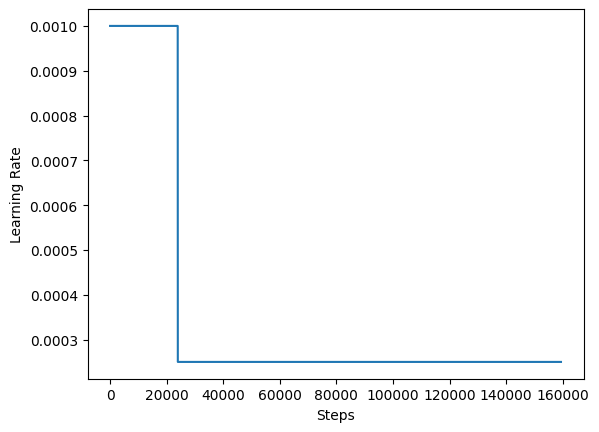

In [25]:
EPOCHS = 100
INITIAL_LR = 1e-3

training_step_size = total_training_examples // BATCH_SIZE
total_training_steps = training_step_size * EPOCHS
print(f"Total training steps: {total_training_steps}.")

lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[training_step_size * 15, training_step_size * 15],values=[INITIAL_LR, INITIAL_LR * 0.5, INITIAL_LR * 0.25])

steps = tf.range(total_training_steps, dtype=tf.int32)
lrs = [lr_schedule(step) for step in steps]

plt.plot(lrs)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

def run_experiment(epochs):

    # Initialize the model
    model = get_shape_segmentation_model(num_points, num_classes)
    
    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),loss=keras.losses.CategoricalCrossentropy(),metrics=["accuracy"])

    # Set up the callbacks
    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_filepath,
                                                           monitor="val_loss",
                                                           save_best_only=True,
                                                           save_weights_only=True)
 
    early_stopping_callback = EarlyStopping(monitor="val_loss",patience=10,restore_best_weights=True)  

    # Fit the model with the callbacks
    history = model.fit(train_dataset,validation_data=val_dataset,epochs=epochs,callbacks=[checkpoint_callback, early_stopping_callback])

  
    model.load_weights(checkpoint_filepath)
    
    return model, history


model, history = run_experiment(epochs=EPOCHS)


Epoch 1/100
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 137s 70ms/step - accuracy: 0.7208 - loss: 29.7177 - val_accuracy: 0.7577 - val_loss: 1.5354
Epoch 2/100
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 94s 59ms/step - accuracy: 0.7800 - loss: 0.7264 - val_accuracy: 0.6227 - val_loss: 2050.0623
Epoch 3/100
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 94s 59ms/step - accuracy: 0.7835 - loss: 5659.3262 - val_accuracy: 0.7176 - val_loss: 755.4741
Epoch 4/100
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 94s 59ms/step - accuracy: 0.6476 - loss: 2010.8064 - val_accuracy: 0.7155 - val_loss: 48.1593
Epoch 5/100
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 94s 59ms/step - accuracy: 0.6905 - loss: 247.9953 - val_accuracy: 0.8399 - val_loss: 44.0560
Epoch 6/100
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 94s 59ms/step - accuracy: 0.7120 - loss: 64.1971 - val_accuracy: 0.7805 - val_loss: 50.8900
Epoch 7/100
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 94s 59ms/step - accuracy: 0.7246 - loss: 22.4660 - val_accuracy: 0.7973 - val_loss: 74.3190
Epoch 8/100
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 94s 5

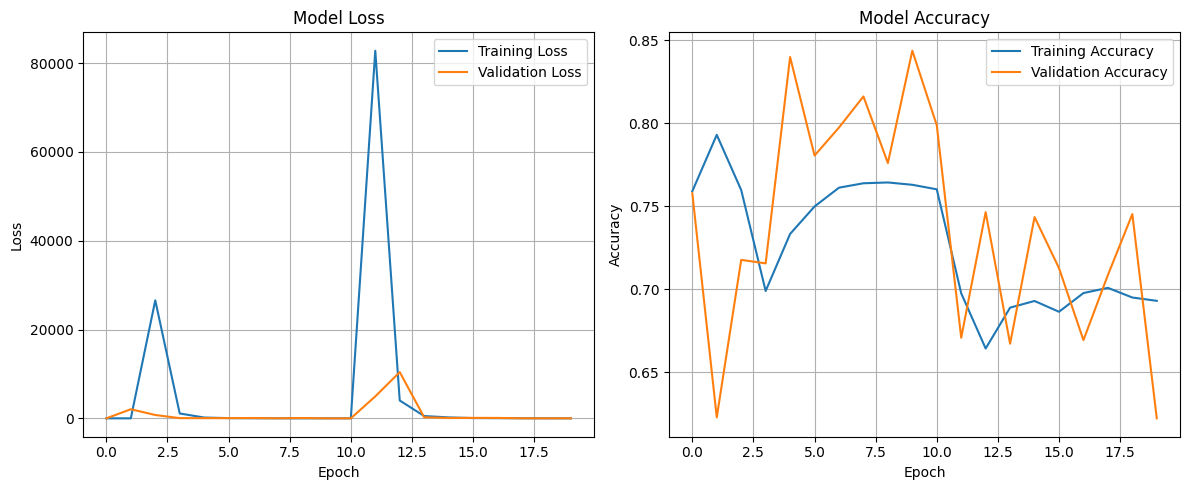

In [27]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [28]:
# Evaluate the model on the validation dataset
evaluation = model.evaluate(val_dataset, return_dict=True)

print("Evaluation Results:")
for metric_name, metric_value in evaluation.items():
    print(f"{metric_name}: {metric_value:.4f}")

399/399 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8431 - loss: 1.2062
Evaluation Results:
accuracy: 0.8437
loss: 1.1978


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Validation prediction shape: (16, 1024, 6)
Index selected: 10


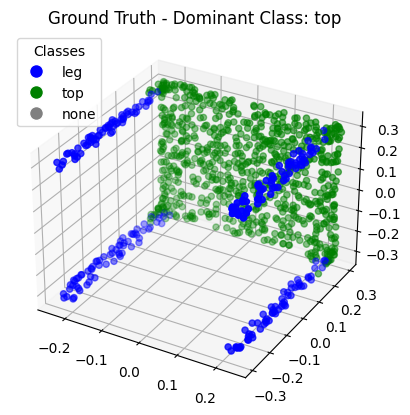

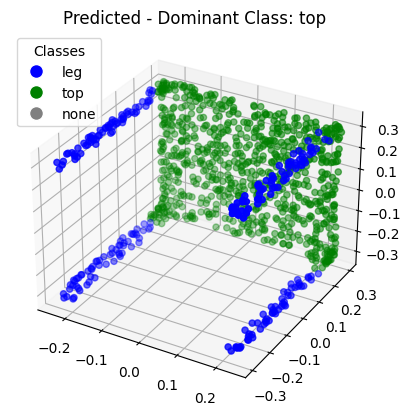

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

metadata = {
    'Airplane': {'directory': '02691156', 'labels': ['wing', 'body', 'tail', 'engine'], 'colors': ['blue', 'green', 'red', 'pink']},
    'Bag': {'directory': '02773838', 'labels': ['handle', 'body'], 'colors': ['blue', 'green']},
    'Cap': {'directory': '02954340', 'labels': ['panels', 'peak'], 'colors': ['blue', 'green']},
    'Car': {'directory': '02958343', 'labels': ['wheel', 'hood', 'roof'], 'colors': ['blue', 'green', 'red']},
    'Chair': {'directory': '03001627', 'labels': ['leg', 'arm', 'back', 'seat'], 'colors': ['blue', 'green', 'red', 'pink']},
    'Earphone': {'directory': '03261776', 'labels': ['earphone', 'headband'], 'colors': ['blue', 'green']},
    'Guitar': {'directory': '03467517', 'labels': ['head', 'body', 'neck'], 'colors': ['blue', 'green', 'red']},
    'Knife': {'directory': '03624134', 'labels': ['handle', 'blade'], 'colors': ['blue', 'green']},
    'Lamp': {'directory': '03636649', 'labels': ['canopy', 'lampshade', 'base'], 'colors': ['blue', 'green', 'red']},
    'Laptop': {'directory': '03642806', 'labels': ['keyboard'], 'colors': ['blue']},
    'Motorbike': {'directory': '03790512', 'labels': ['wheel', 'handle', 'gas_tank', 'light', 'seat'], 'colors': ['blue', 'green', 'red', 'pink', 'yellow']},
    'Mug': {'directory': '03797390', 'labels': ['handle'], 'colors': ['blue']},
    'Pistol': {'directory': '03948459', 'labels': ['trigger_and_guard', 'handle', 'barrel'], 'colors': ['blue', 'green', 'red']},
    'Rocket': {'directory': '04099429', 'labels': ['nose', 'body', 'fin'], 'colors': ['blue', 'green', 'red']},
    'Skateboard': {'directory': '04225987', 'labels': ['wheel', 'deck'], 'colors': ['blue', 'green']},
    'Table': {'directory': '04379243', 'labels': ['leg', 'top'], 'colors': ['blue', 'green']}
}

# Load a batch of validation data
validation_batch = next(iter(val_dataset))
val_predictions = model.predict(validation_batch[0])
print(f"Validation prediction shape: {val_predictions.shape}")

def visualize_single_point_cloud(point_clouds, label_clouds, idx, category, title_prefix="Point Cloud"):
    labels = metadata[category]["labels"]
    colors = metadata[category]["colors"]
    label_map = labels + ["none"]
    color_map = colors + ['gray']

    point_cloud = point_clouds[idx]
    label_cloud = label_clouds[idx]
    visualized_labels = [label_map[np.argmax(label)] for label in label_cloud]
    
    label_to_color = {label: mcolors.to_rgb(color) for label, color in zip(label_map, color_map)}
    point_colors = [label_to_color[label] for label in visualized_labels]
    
    unique_labels, counts = np.unique(visualized_labels, return_counts=True)
    dominant_class = unique_labels[np.argmax(counts)]
    
    visualize_data(point_cloud, point_colors, f"{title_prefix} - Dominant Class: {dominant_class}", label_map, color_map)

def visualize_data(point_cloud, point_colors, title, label_map, color_map):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], c=point_colors)
    plt.title(title)
    
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=label,markerfacecolor=mcolors.to_rgb(color), markersize=10) for label, color in zip(label_map, color_map)]
    ax.legend(handles=legend_elements, title="Classes")
    
    plt.show()

# Select only one index instead of multiple
idx = np.random.choice(len(validation_batch[0]))  
print(f"Index selected: {idx}")

category = 'Table'  

visualize_single_point_cloud(validation_batch[0], validation_batch[1], idx, category, title_prefix="Ground Truth")
visualize_single_point_cloud(validation_batch[0], val_predictions, idx, category, title_prefix="Predicted")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Validation prediction shape: (16, 1024, 6)
Index selected: 15
Ground Truth - Label distribution at idx 15:
  body: 559
  tail: 106
  wing: 359


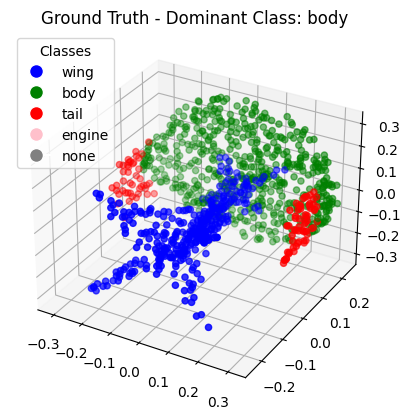

Predicted - Label distribution at idx 15:
  body: 662
  tail: 20
  wing: 342


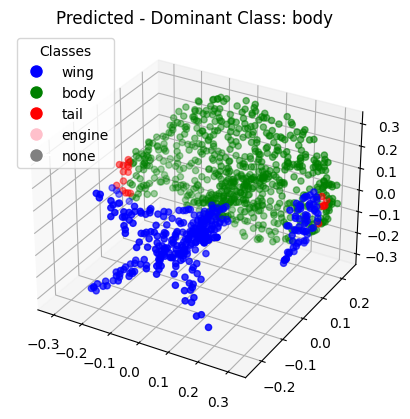

In [30]:

validation_batch = next(iter(val_dataset))
val_predictions = model.predict(validation_batch[0])
print(f"Validation prediction shape: {val_predictions.shape}")

def visualize_single_point_cloud(point_clouds, label_clouds, idx, category, title_prefix="Point Cloud"):
    labels = metadata[category]["labels"]
    colors = metadata[category]["colors"]
    label_map = labels + ["none"]
    color_map = colors + ['gray']

    point_cloud = point_clouds[idx]
    label_cloud = label_clouds[idx]
    visualized_labels = [label_map[np.argmax(label)] for label in label_cloud]
    
    label_to_color = {label: mcolors.to_rgb(color) for label, color in zip(label_map, color_map)}
    point_colors = [label_to_color[label] for label in visualized_labels]
    
    unique_labels, counts = np.unique(visualized_labels, return_counts=True)
    dominant_class = unique_labels[np.argmax(counts)]
    
    # Diagnostic: Print the label distribution to verify
    print(f"{title_prefix} - Label distribution at idx {idx}:")
    for label, count in zip(unique_labels, counts):
        print(f"  {label}: {count}")
    
    visualize_data(point_cloud, point_colors, f"{title_prefix} - Dominant Class: {dominant_class}", label_map, color_map)

def visualize_data(point_cloud, point_colors, title, label_map, color_map):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2], c=point_colors)
    plt.title(title)
    
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=label, 
                              markerfacecolor=mcolors.to_rgb(color), markersize=10) 
                       for label, color in zip(label_map, color_map)]
    ax.legend(handles=legend_elements, title="Classes")
    
    plt.show()

idx = np.random.choice(len(validation_batch[0]))  
print(f"Index selected: {idx}")

category = 'Airplane'

visualize_single_point_cloud(validation_batch[0], validation_batch[1], idx, category, title_prefix="Ground Truth")
visualize_single_point_cloud(validation_batch[0], val_predictions, idx, category, title_prefix="Predicted")